# Follow-up intron diversity

## Setup

In [10]:
#%run data_phase1_ar3_1.ipynb

import sys
import petl as etl
import petlx.bio
import numpy as np
import functools
import allel
sys.path.insert(0, '../../agam-report-base/src/python')
from util import *
from ag1k import phase2_ar1
phase2_ar1.init("../../phase2.AR1")
genome = phase2_ar1.genome_agamp4
accessibility = phase2_ar1.accessibility
allele_counts = phase2_ar1.allele_counts
callset_pass = phase2_ar1.callset

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
# use seaborn defaults
rcParams = plt.rcParams
rcParams['savefig.jpeg_quality'] = 100
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}

In [12]:
# Having a guess at what Alistair's "get_features" function does
def get_features(chrom):
    return get_geneset_features(phase2_ar1.geneset_agamp44_fn, chrom)

In [13]:
CLS_UPSTREAM = 1
CLS_5UTR = 2
CLS_EXON_FIRST = 3
CLS_INTRON_FIRST = 4
CLS_EXON_MID = 5
CLS_INTRON_LAST = 6
CLS_EXON_LAST = 7
CLS_3UTR = 8
CLS_DOWNSTREAM = 9
CLS_INTRON_MID = 10


def compute_features(chrom):
  #  log('compute features', chrom)

    # extract features
    ###################
    
    tbl_features = (
        get_features(chrom)
        .convert('start', lambda v: v-1)
        .rename('end', 'stop')
        .unpackdict('attributes', ['Parent', 'ID'])
        .rename('Parent', 'parent')
        .addfield('length', lambda rec: rec.stop-rec.start, index=5)
        .cache()
    )
    
    # obtain genes
    ###############
    
    tbl_genes = tbl_features.eq('type', 'gene')    

    # obtain CDSs
    ##############
    
    def child_first(prv, cur, nxt):
        return (
            (cur.strand == '+' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '-') and (nxt is None or cur.parent != nxt.parent)
        )

    def child_last(prv, cur, nxt):
        return (
            (cur.strand == '-' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '+') and (nxt is None or cur.parent != nxt.parent)
        )

    tbl_cdss = (
        tbl_features
        .eq('type', 'CDS')
        .select('parent', lambda v: v.endswith('RA'))
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )    

    # obtain introns
    #################
    
    def cds2intron(parent, cdss):
        cdss = list(cdss)
        seqid = cdss[0].seqid
        strand = cdss[0].strand
        type = 'intron'
        for i in range(1, len(cdss)):
            start = cdss[i-1].stop
            stop = cdss[i].start
            yield (seqid, type, start, stop, stop-start, strand, parent)

    tbl_introns = (
        tbl_cdss
        .rowgroupmap(key='parent', mapper=cds2intron, header=['seqid', 'type', 'start', 'stop', 'length', 'strand', 'parent'])
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )
    
    # setup outputs
    ################
    
    seq = np.asarray(genome[chrom])
    seq_cls = np.zeros(seq.size, dtype='u1')
    seq_relpos = np.zeros(seq.size, dtype='u4')
    seq_relpos_end = np.zeros(seq.size, dtype='u4')
    seq_flen = np.zeros(seq.size, dtype='u4')

    # build the upstream and downstream classes
    ############################################
    
    prv_gene = None
    for gene in tbl_genes.records():

        if prv_gene is not None and (gene.start - prv_gene.stop) > 1000:

            # midpoint between previous and current genes
            m = (prv_gene.stop + gene.start) // 2

            # deal with previous gene
            if prv_gene.strand == '+':
                prv_cls = CLS_DOWNSTREAM
            else:
                prv_cls = CLS_UPSTREAM
            seq_cls[prv_gene.stop:m] = prv_cls
            seq_relpos[prv_gene.stop:m] = np.arange(m - prv_gene.stop)
            seq_relpos_end[prv_gene.stop:m] = np.arange(m - prv_gene.stop)[::-1]
            seq_flen[prv_gene.stop:m] = m - prv_gene.stop
            
            # deal with current gene
            if gene.strand == '+':
                cls = CLS_UPSTREAM
            else:
                cls = CLS_DOWNSTREAM
            seq_cls[m:gene.start] = cls
            seq_relpos[m:gene.start] = np.arange(gene.start - m)[::-1]
            seq_relpos_end[m:gene.start] = np.arange(gene.start - m)
            seq_flen[m:gene.start] = gene.start - m

        prv_gene = gene

    # build the UTR classes
    ########################
    
    for f in tbl_features.records():

        cls = None
        if f['type'] == 'five_prime_UTR':
            cls = CLS_5UTR
        elif f['type'] == 'three_prime_UTR':
            cls = CLS_3UTR

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the exon classes
    #########################
    
    for f in tbl_cdss.records():

        cls = None
        if f.first and not f.last:
            cls = CLS_EXON_FIRST
        elif not f.first and f.last:
            cls = CLS_EXON_LAST
        elif not f.first and not f.last:
            cls = CLS_EXON_MID

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the intron classes
    ###########################
    
    for f in tbl_introns.records():

        cls = None
        if f.first and not f.last:
            cls = CLS_INTRON_FIRST
        elif not f.first and f.last:
            cls = CLS_INTRON_LAST
        elif not f.first and not f.last:
            cls = CLS_INTRON_MID

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start

    return seq_cls, seq_relpos, seq_relpos_end, seq_flen


@functools.lru_cache(maxsize=None)
def compute_feature_diversity(chrom, pop='all'):
  #  log('compute feature diversity', chrom, pop)
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen = compute_features(chrom)
    
    # compute mean pairwise difference
    ###################################
    
    seq_mpd = np.zeros(seq_cls.size, dtype='f8')
    ac = allel.AlleleCountsArray(allele_counts[chrom][pop])
    mpd = allel.mean_pairwise_difference(ac)
    pos = callset_pass[chrom]['variants/POS'][:]
    seq_mpd[pos-1] = mpd
    
    # compute watterson's theta
    ############################
    
    seq_wt = np.zeros(seq_cls.size, dtype='f8')
    is_seg = ac.is_segregating().astype('f8')
    n = ac.sum(axis=1).max()
    wt = is_seg / np.sum(1 / np.arange(1, n))
    seq_wt[pos-1] = wt
    
    # filter for accessibility
    ###########################
    
    is_accessible = accessibility[chrom]['is_accessible'][:]
    seq_cls = seq_cls[is_accessible]
    seq_relpos = seq_relpos[is_accessible]
    seq_relpos_end = seq_relpos_end[is_accessible]
    seq_flen = seq_flen[is_accessible]
    seq_mpd = seq_mpd[is_accessible]
    seq_wt = seq_wt[is_accessible]

    # return outputs
    return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt


## Analysis

In [19]:
def plot_feature_diversity(chrom, cls, x_max, y_max=0.04, title=None, min_flen=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


In [20]:
def plot_feature_diversity_end(chrom, cls, x_max, y_max=0.04, title=None, min_flen=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos_end < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos_end[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Physical distance from feature end ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


In [21]:
def plot_all_feature_diversity(chrom, x_max=200, y_max=0.04, min_flen=None):
    plot_feature_diversity(chrom, CLS_INTRON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_INTRON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_INTRON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_EXON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First CDS, %s" % chrom)
    plot_feature_diversity(chrom, CLS_EXON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid CDS, %s" % chrom)
    plot_feature_diversity(chrom, CLS_EXON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last CDS, %s" % chrom)
    plot_feature_diversity(chrom, CLS_3UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="3' UTR, %s" % chrom)
    plot_feature_diversity(chrom, CLS_5UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="5' UTR, %s" % chrom)
    plot_feature_diversity(chrom, CLS_UPSTREAM, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Upstream, %s" % chrom)
    plot_feature_diversity(chrom, CLS_DOWNSTREAM, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Downstream, %s" % chrom)


In [22]:
def plot_all_feature_diversity_end(chrom, x_max=200, y_max=0.04, min_flen=None):
    plot_feature_diversity_end(chrom, CLS_INTRON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_INTRON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_INTRON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_EXON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First CDS, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_EXON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid CDS, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_EXON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last CDS, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_3UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="3' UTR, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_5UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="5' UTR, %s" % chrom)


### Distance from start

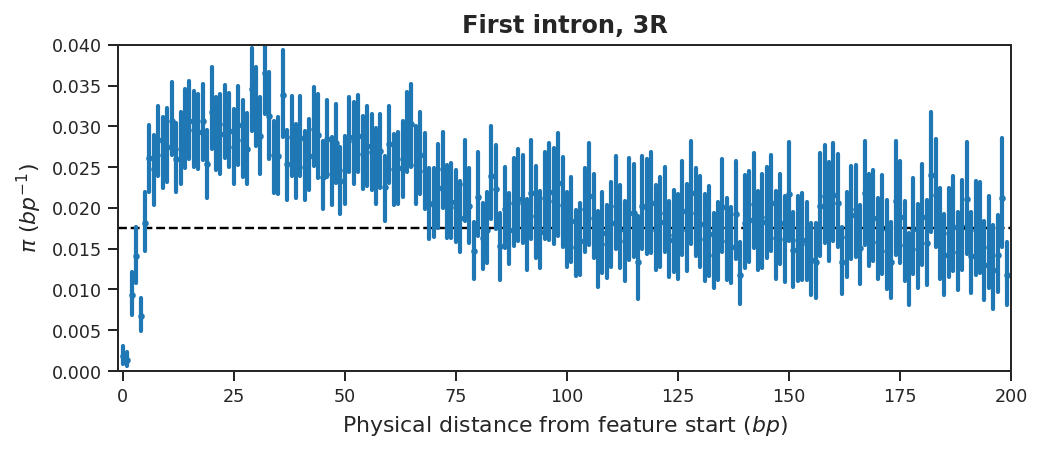

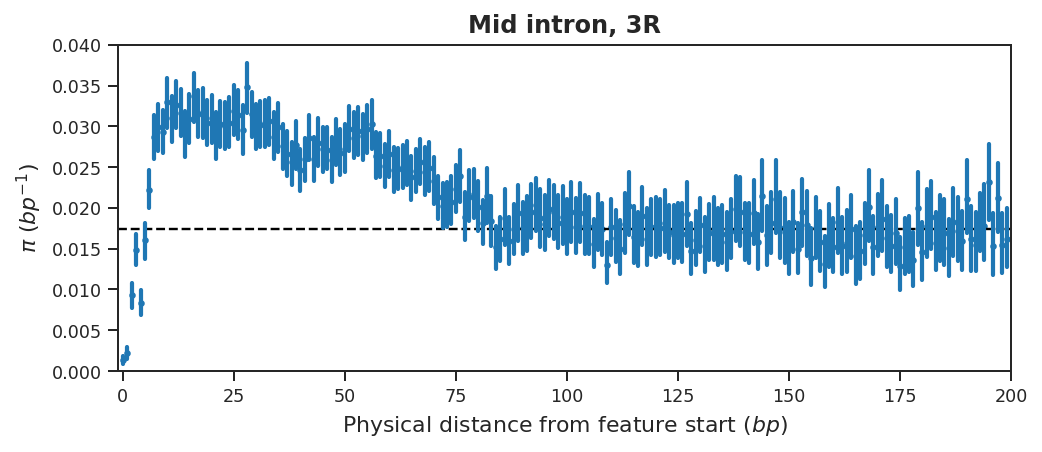

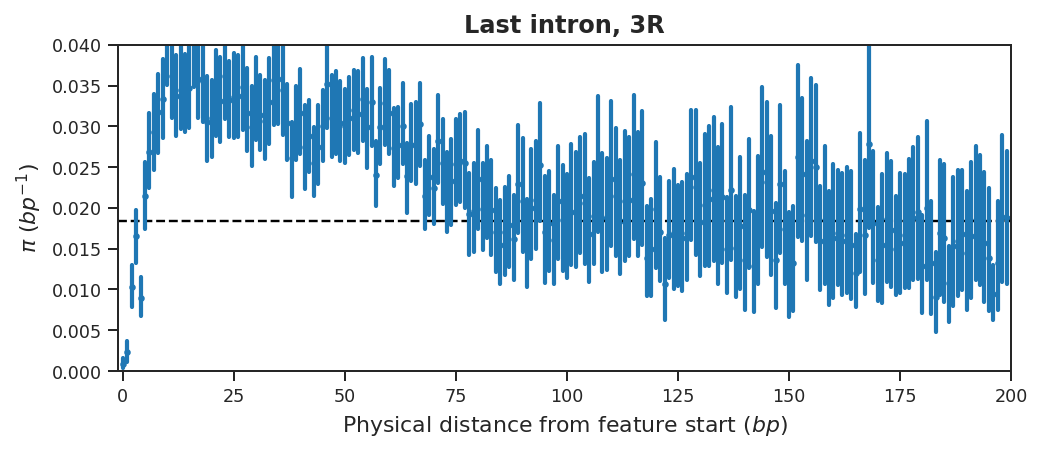

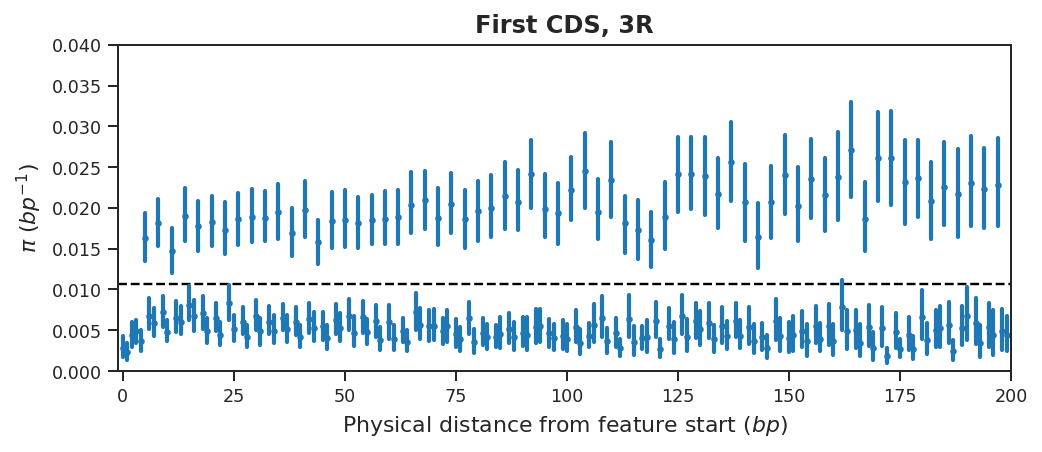

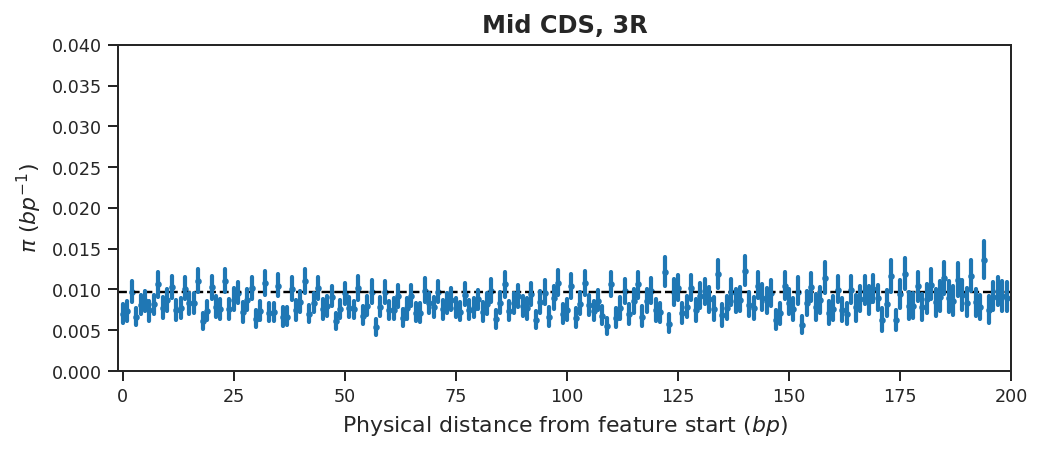

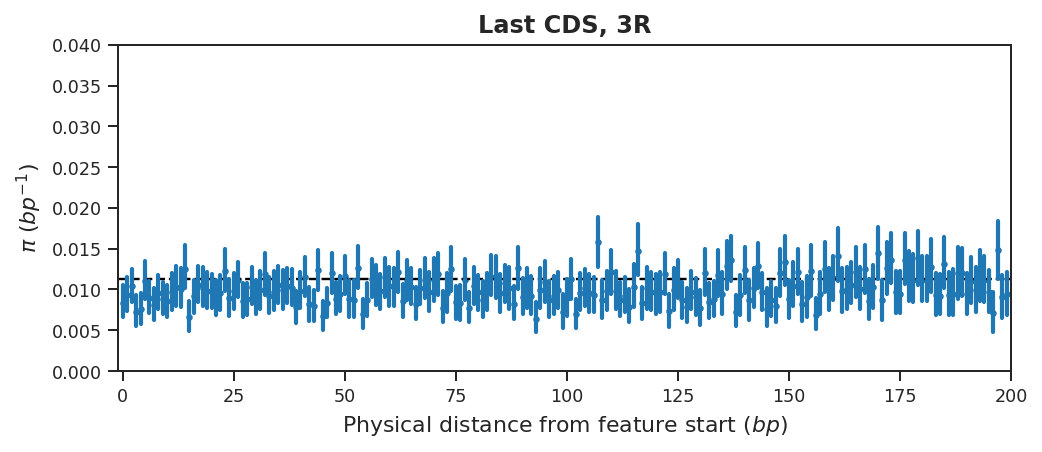

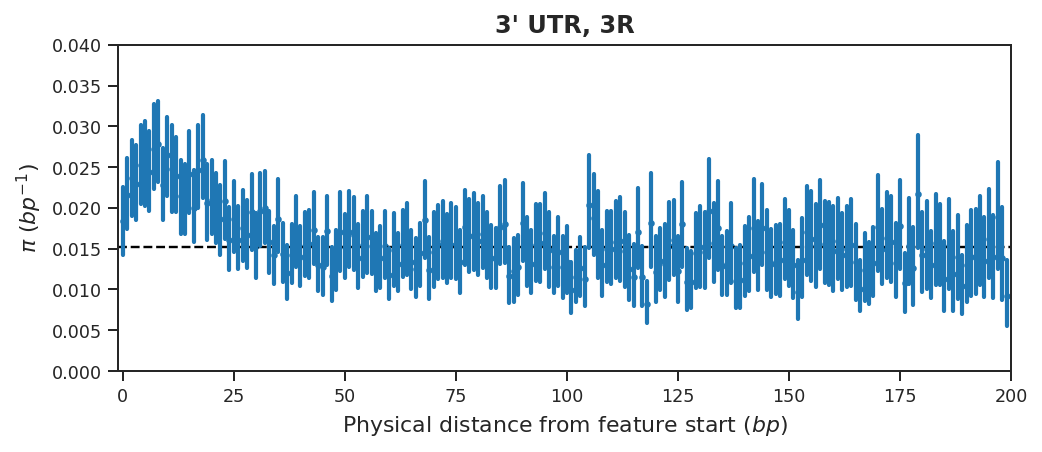

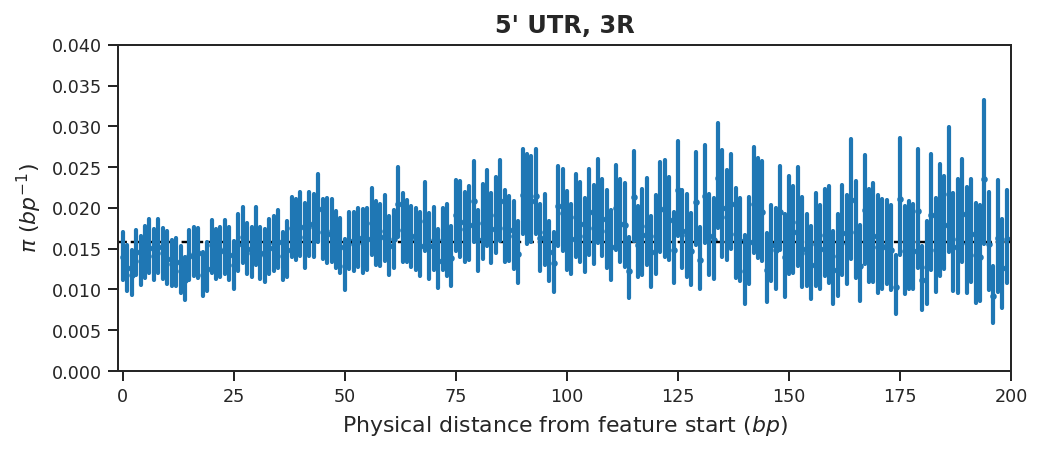

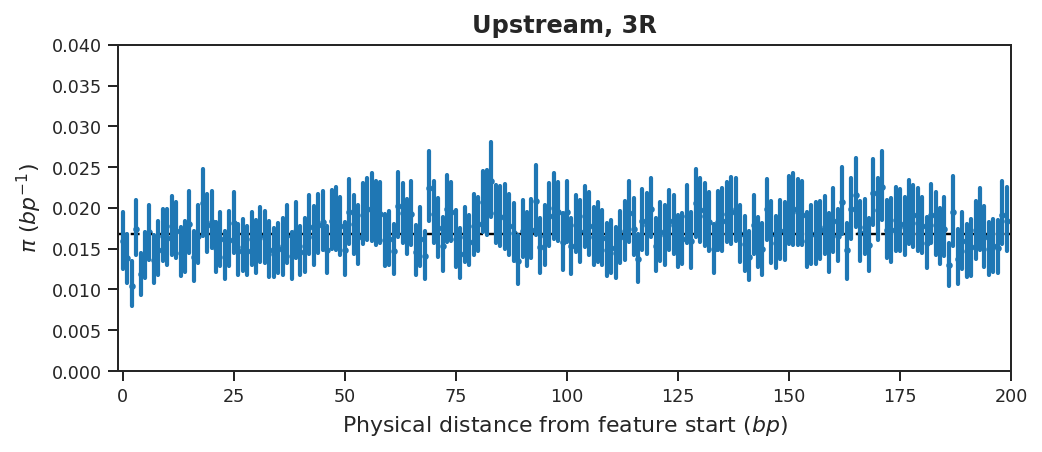

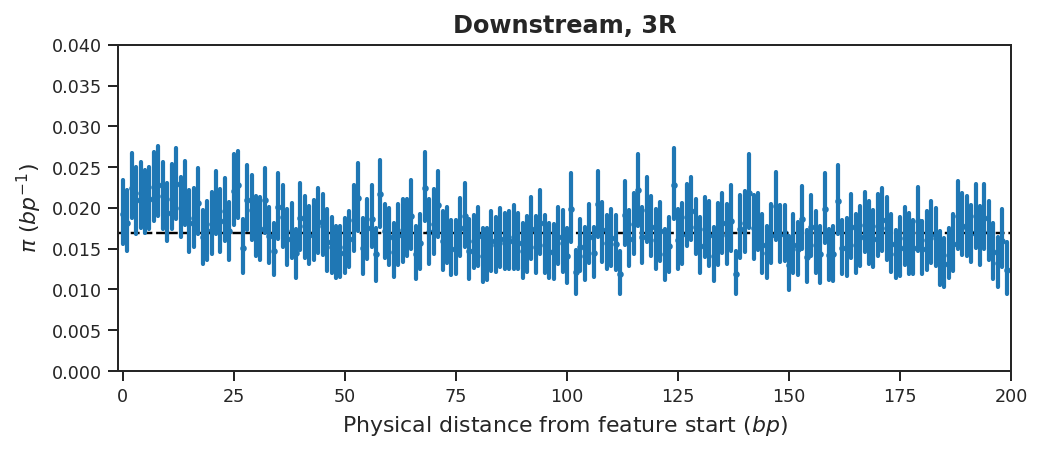

In [23]:
plot_all_feature_diversity('3R')

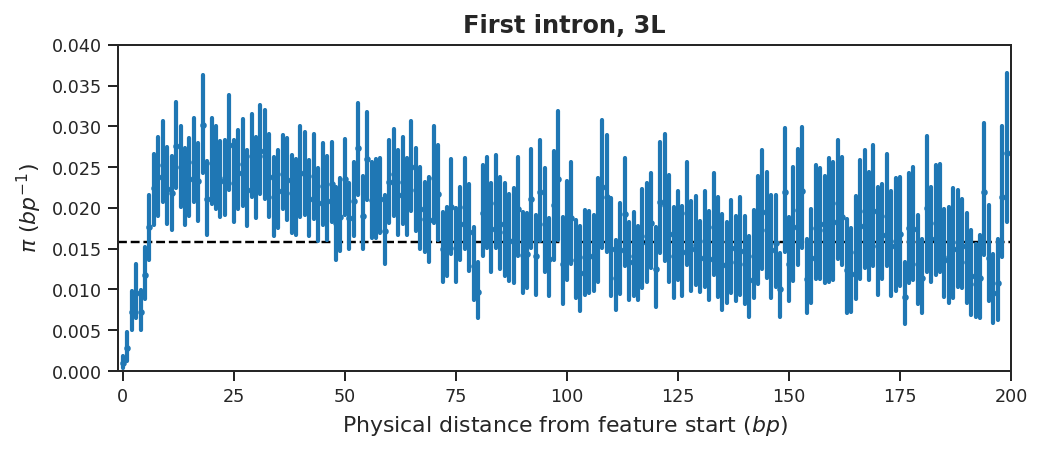

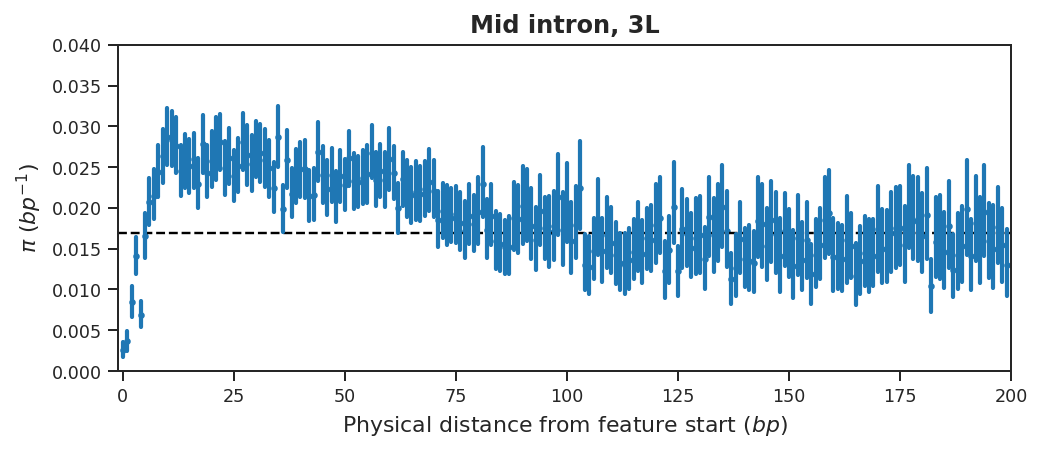

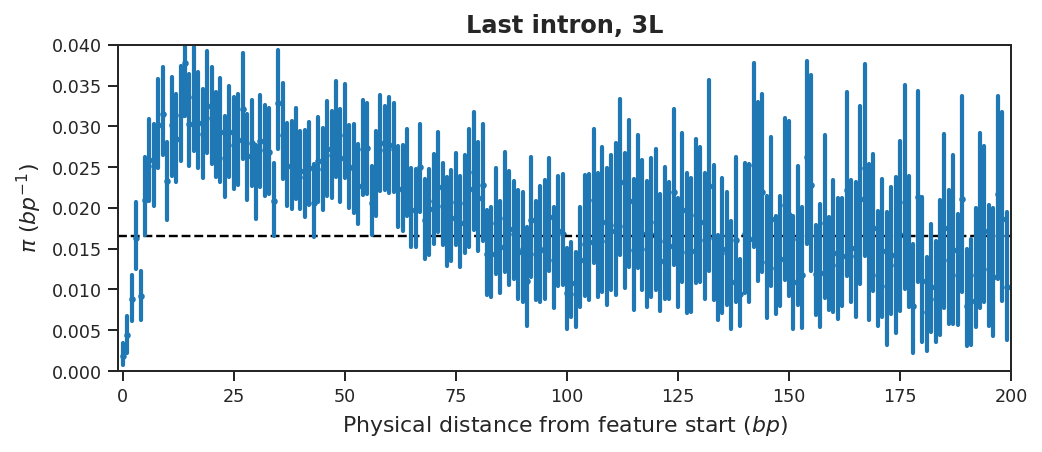

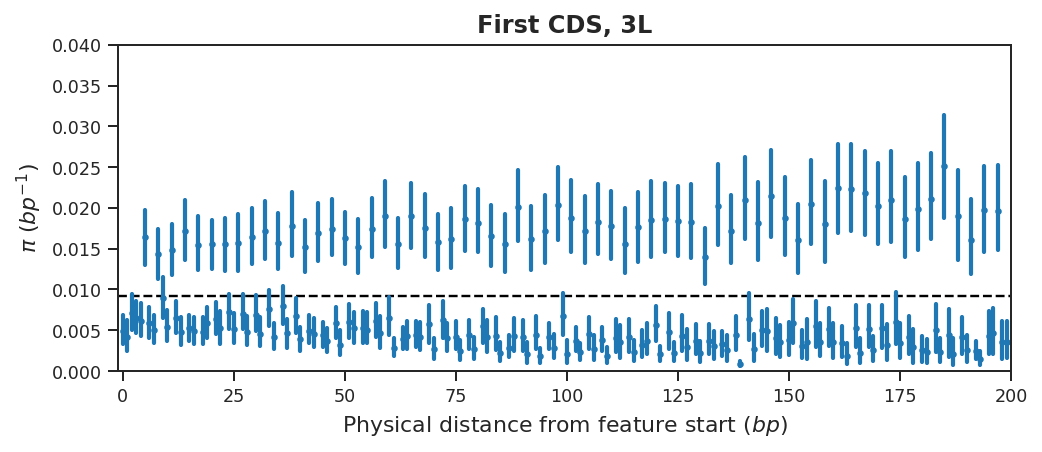

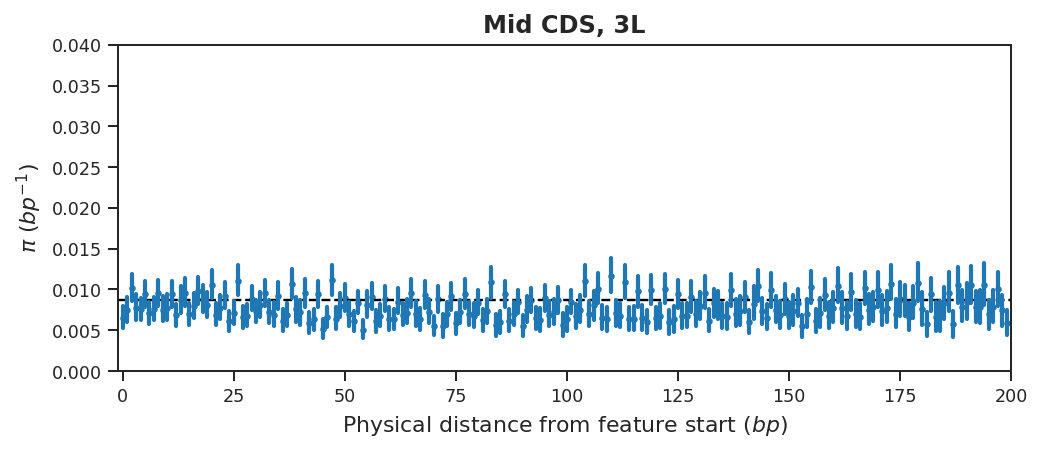

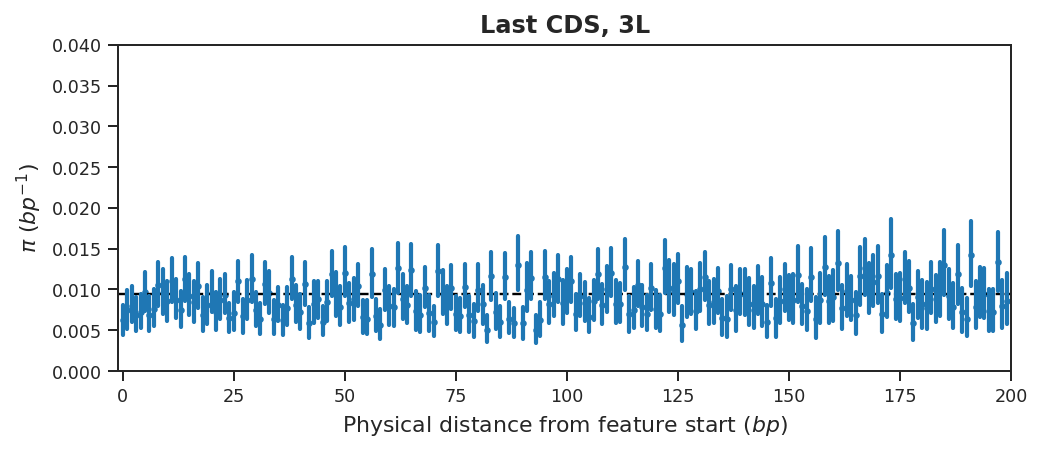

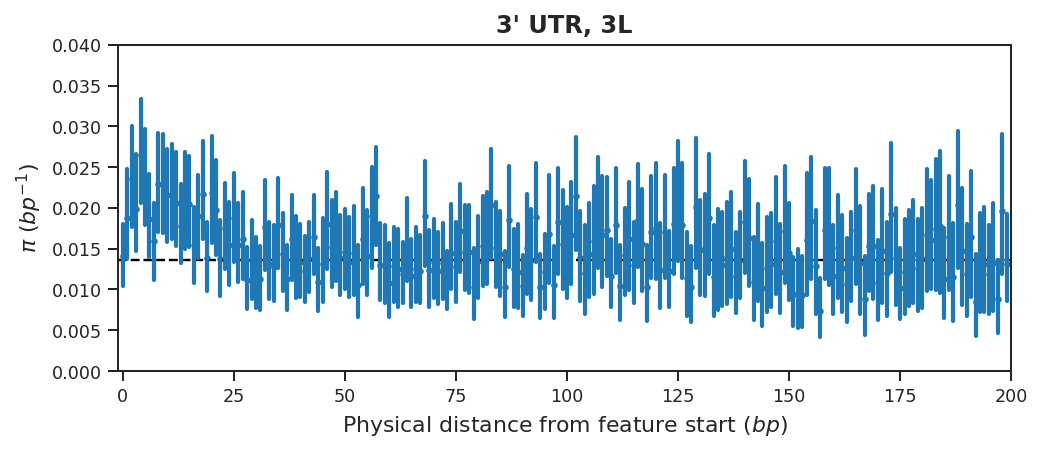

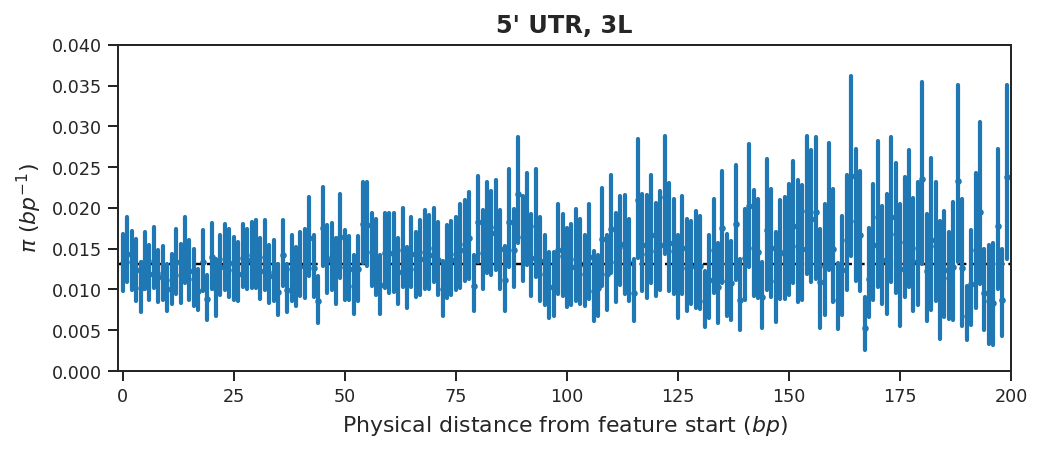

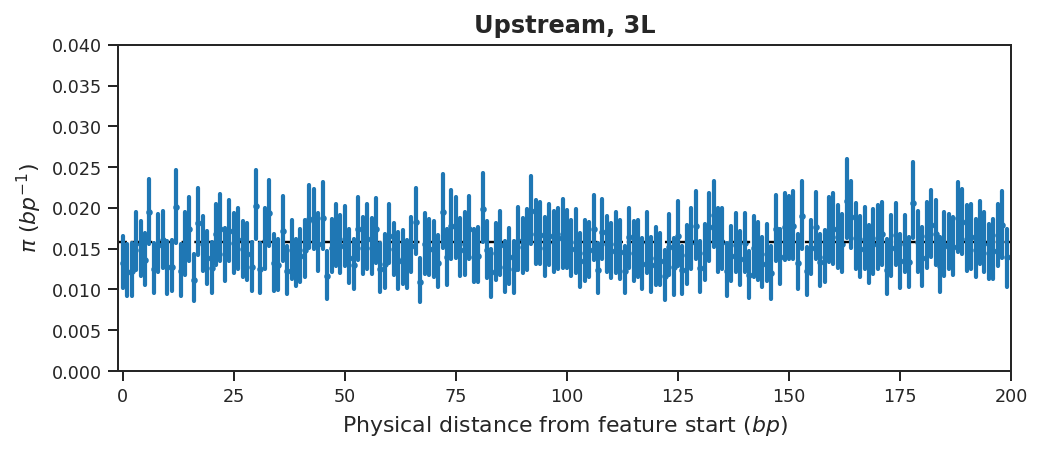

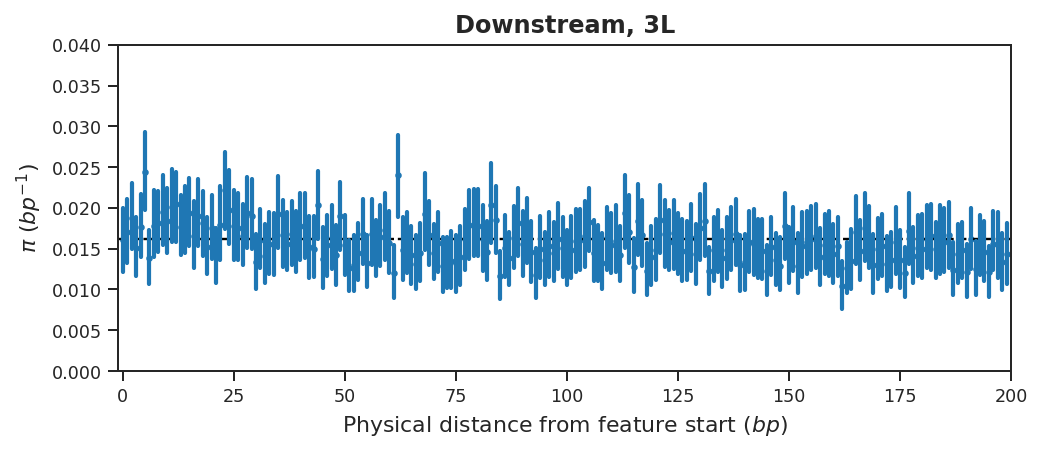

In [24]:
plot_all_feature_diversity('3L')

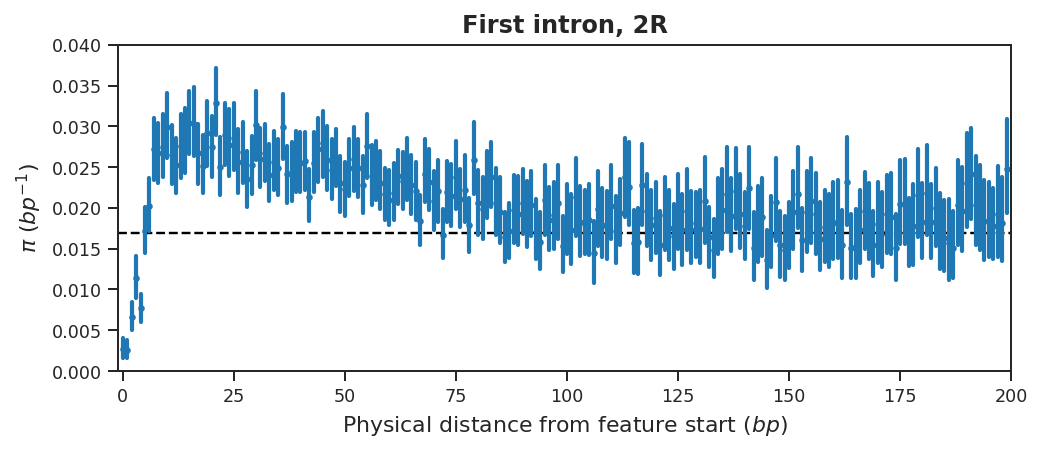

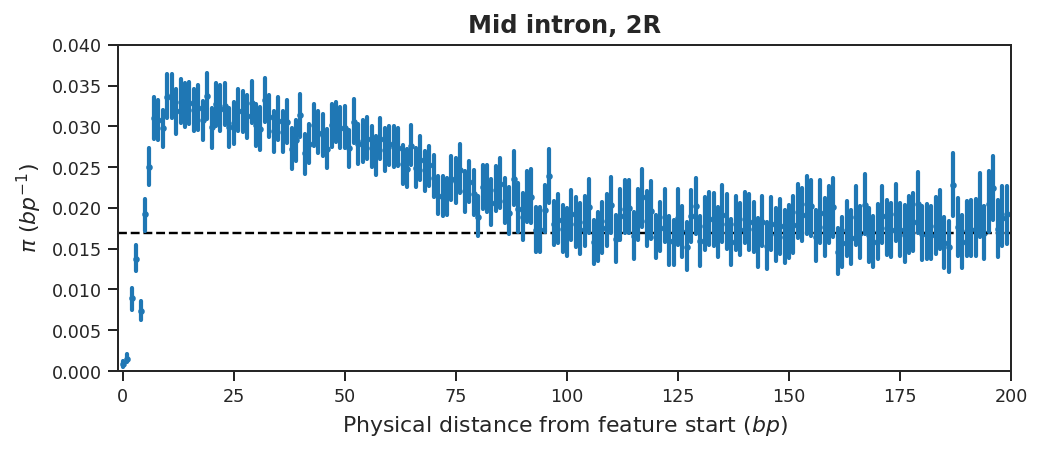

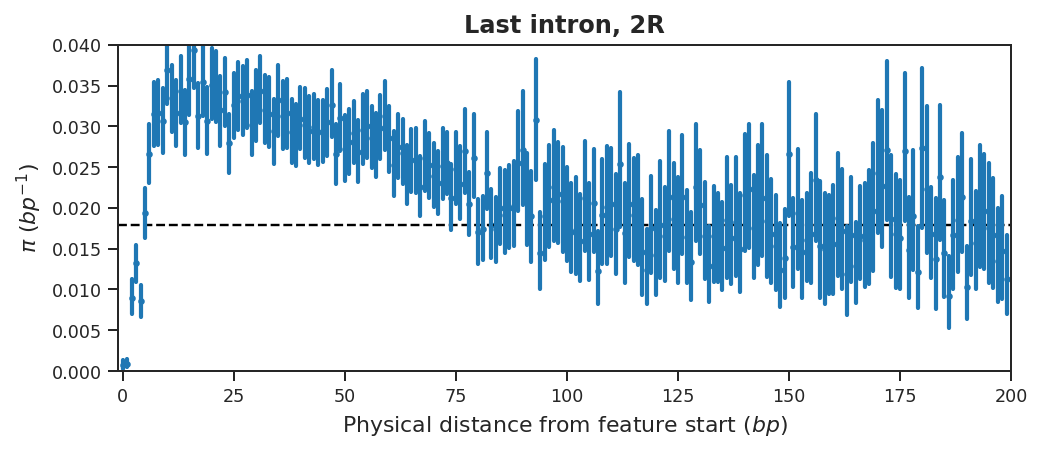

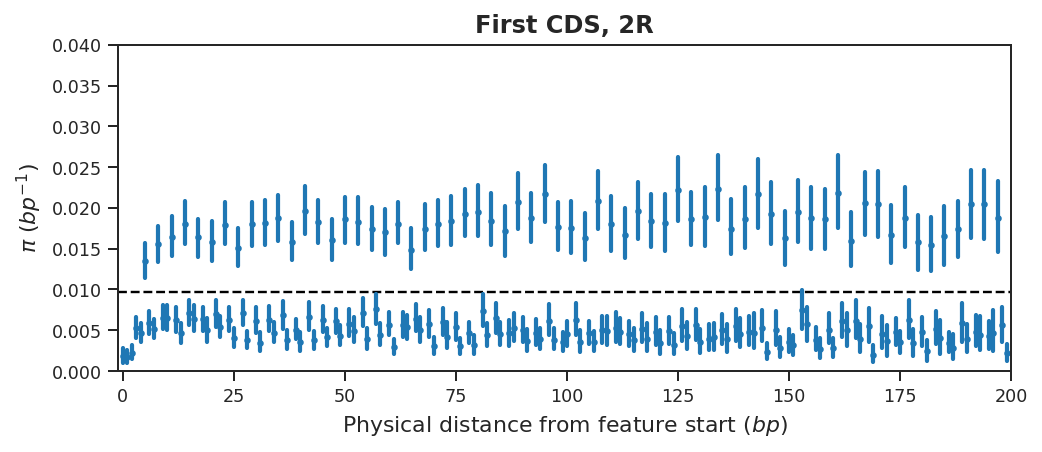

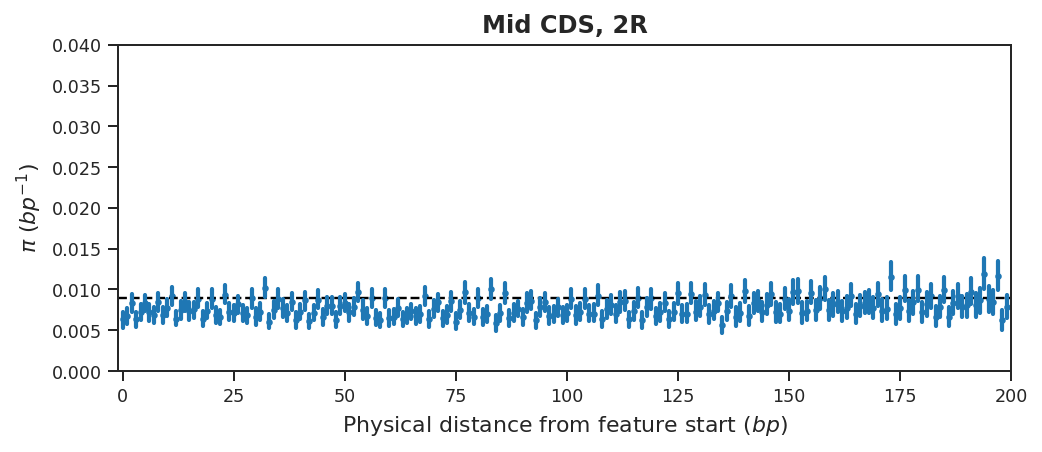

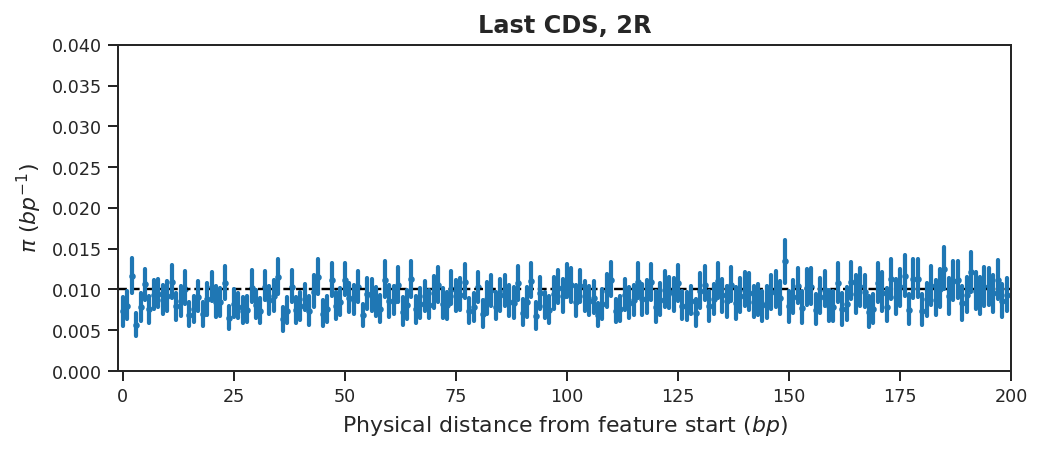

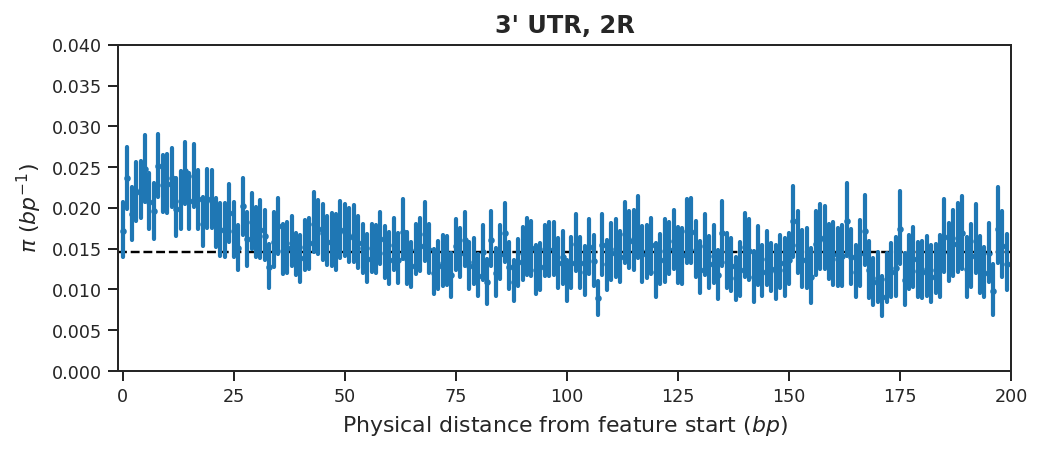

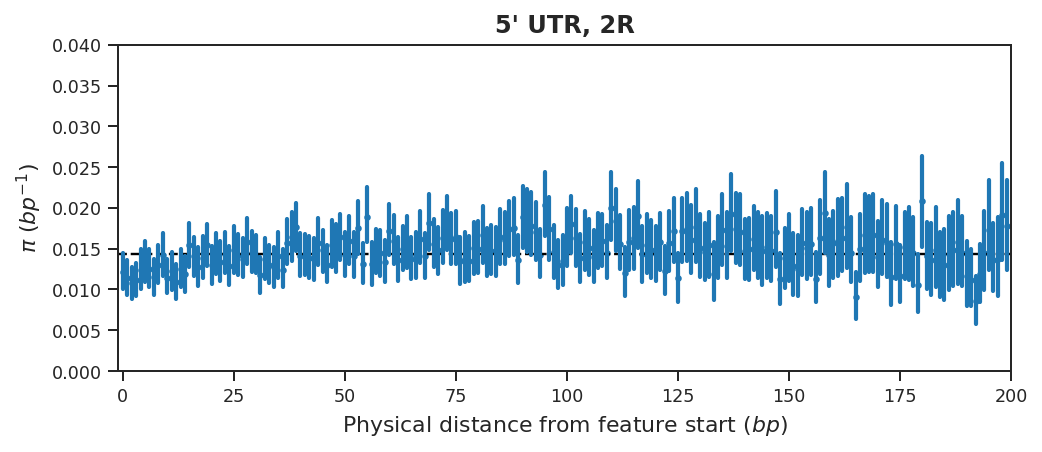

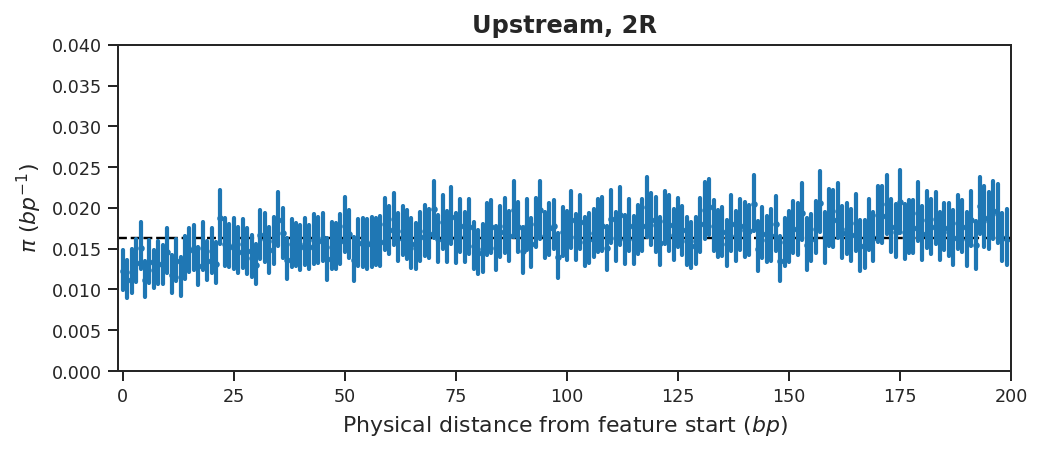

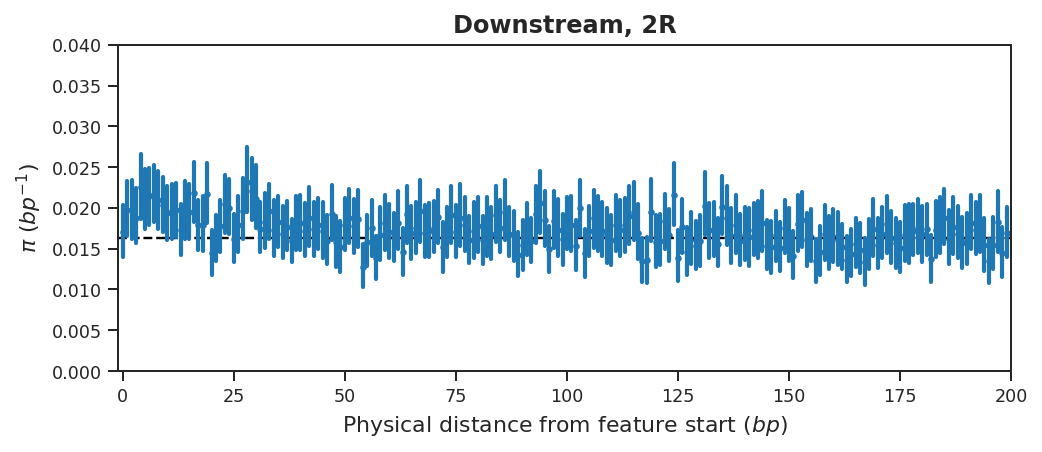

In [25]:
plot_all_feature_diversity('2R')

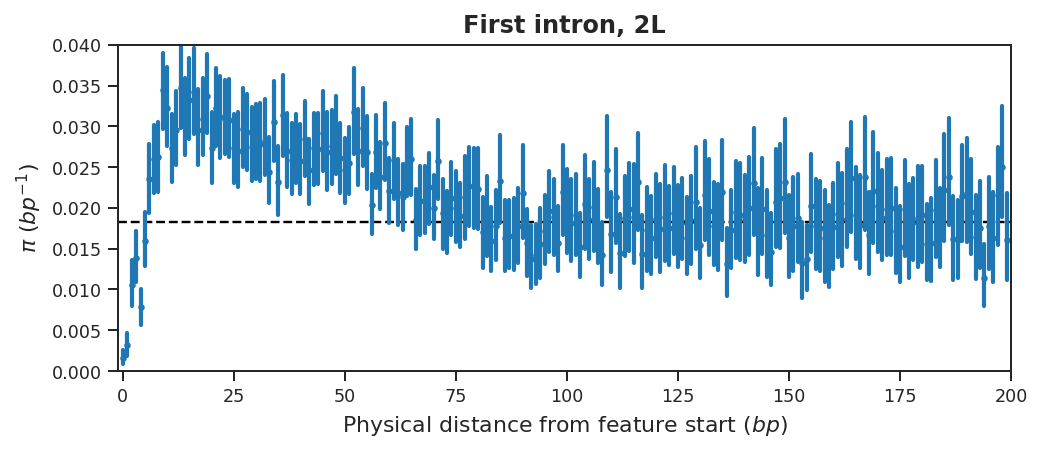

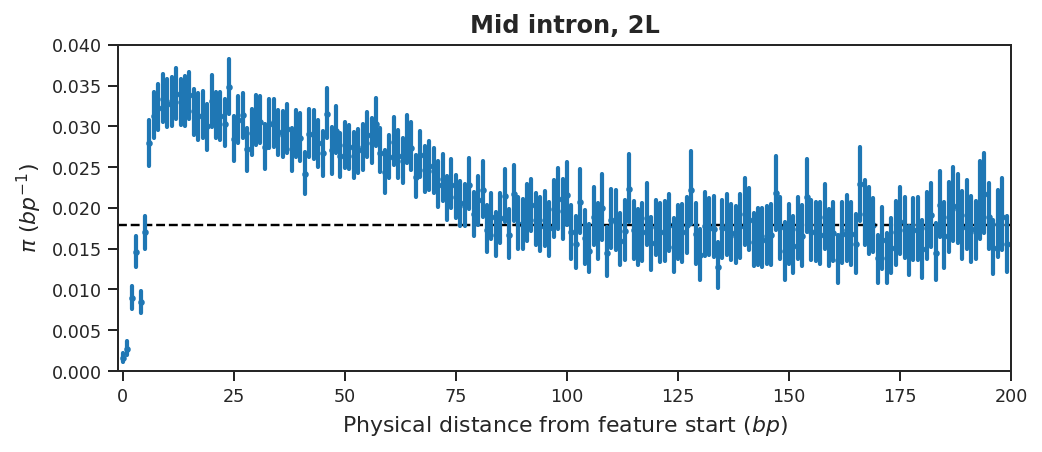

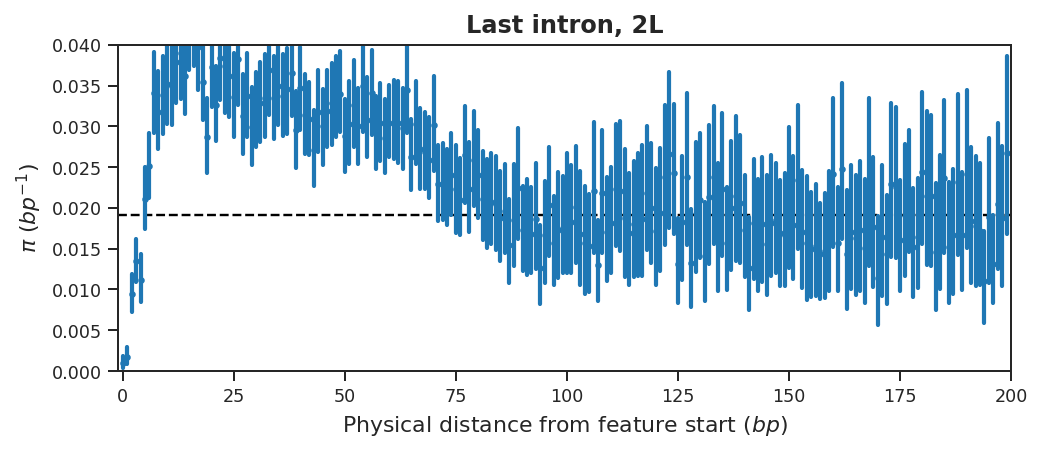

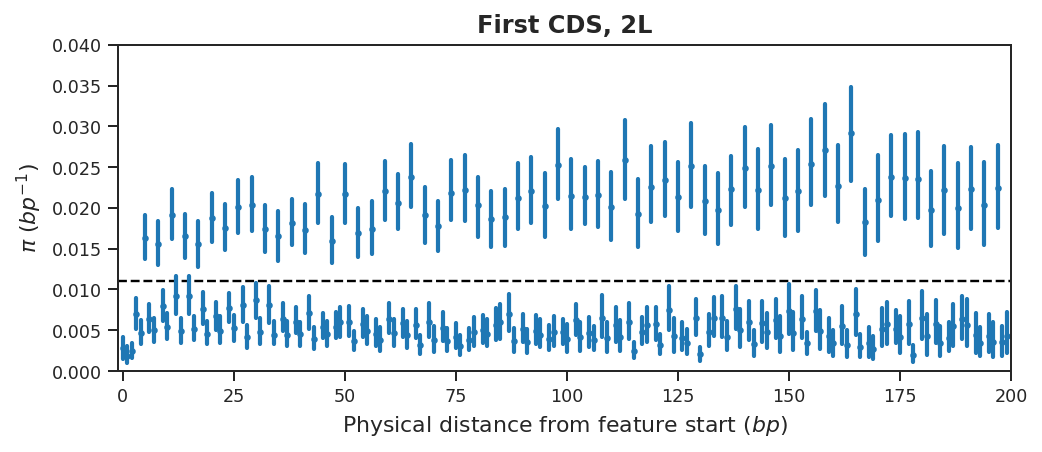

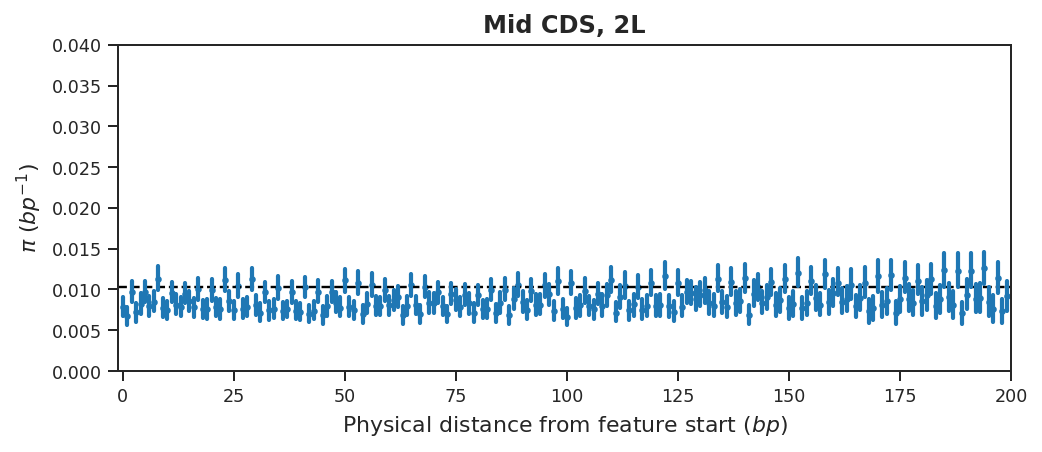

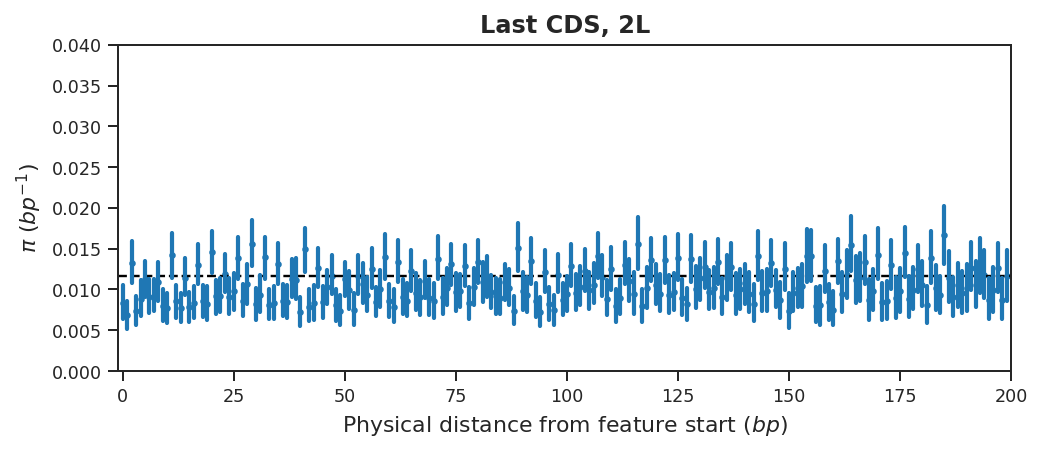

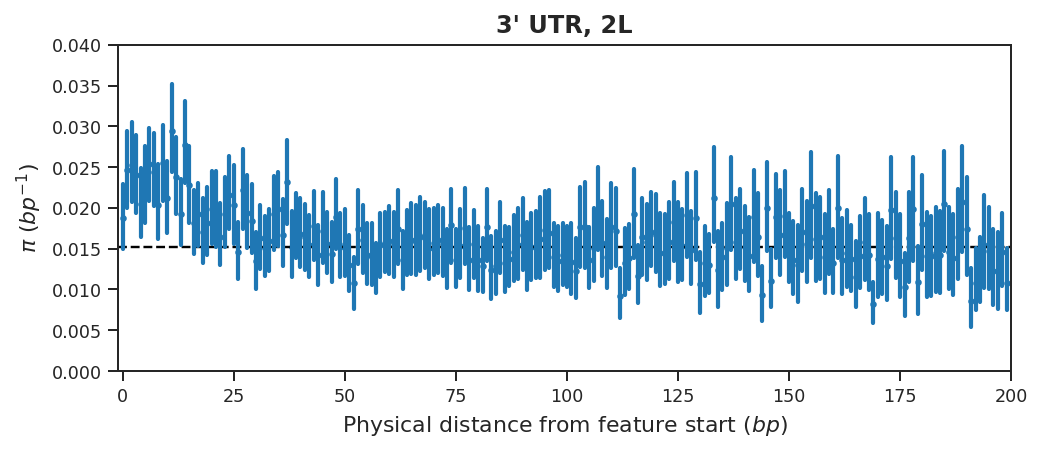

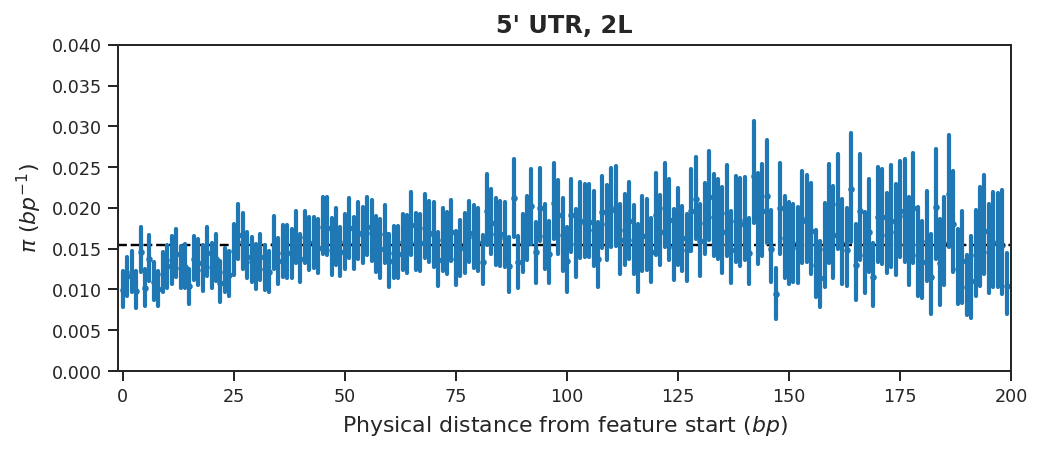

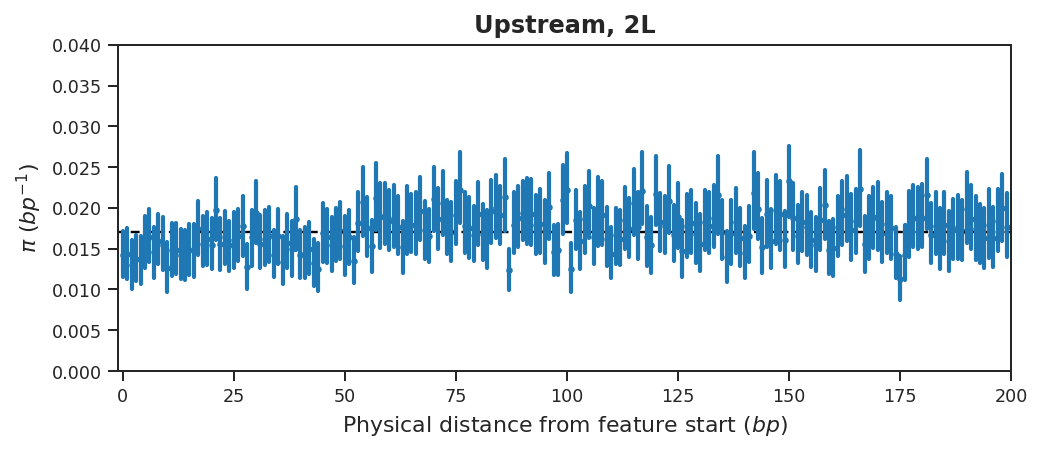

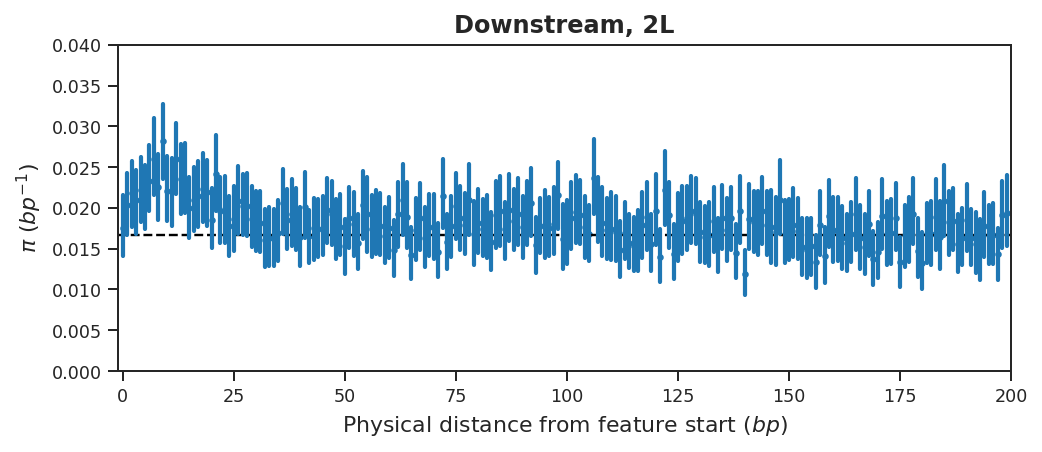

In [26]:
plot_all_feature_diversity('2L')

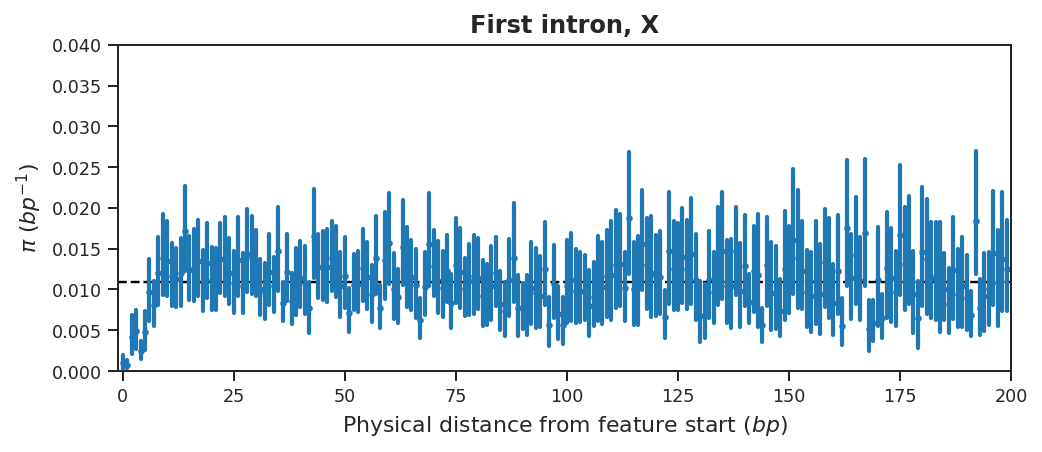

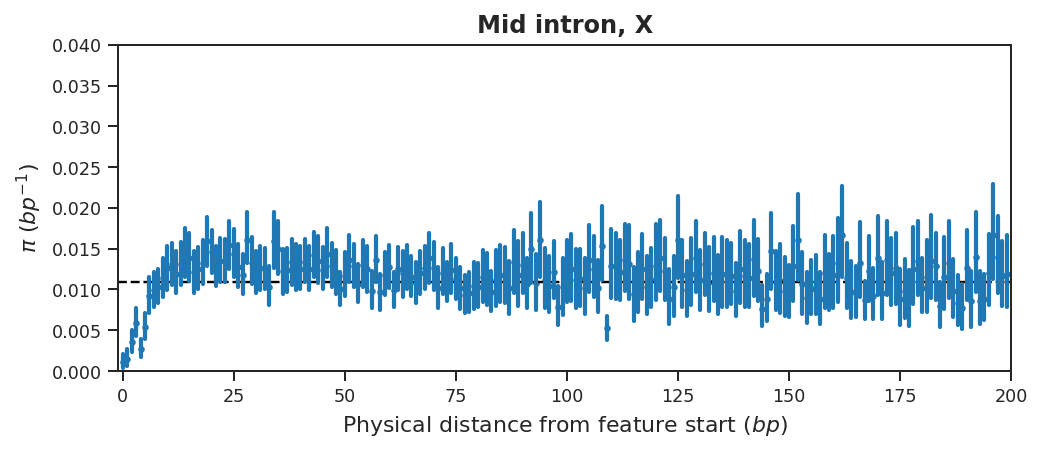

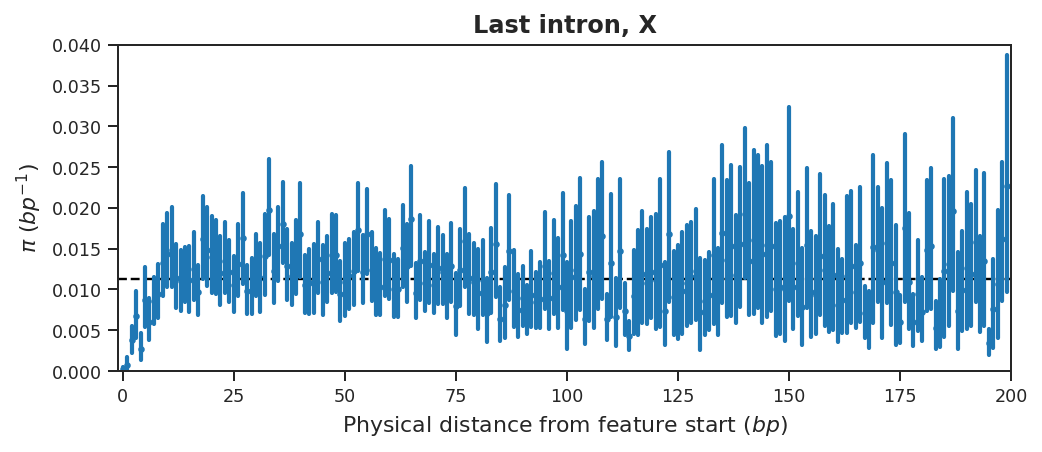

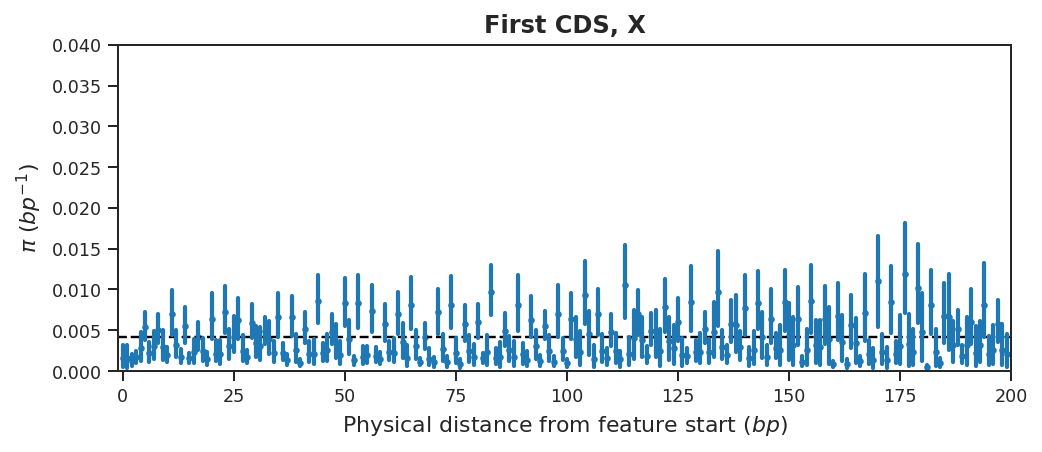

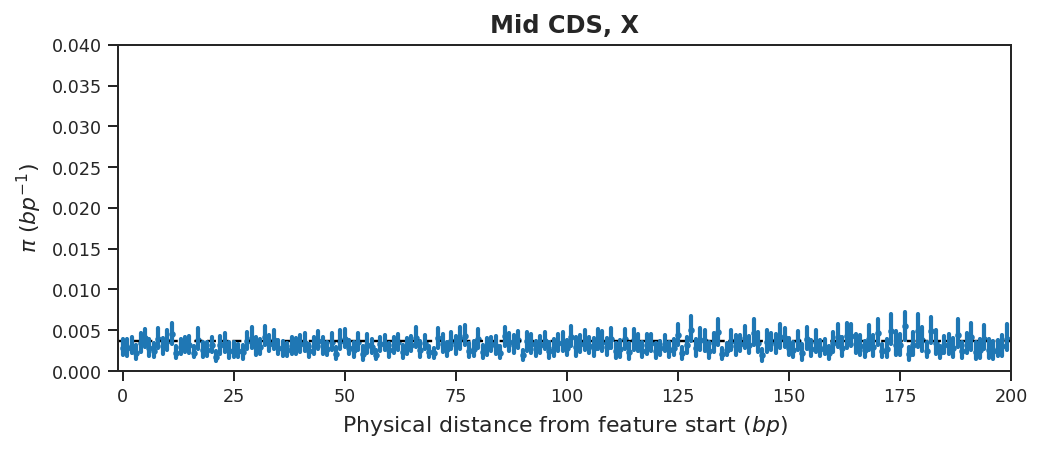

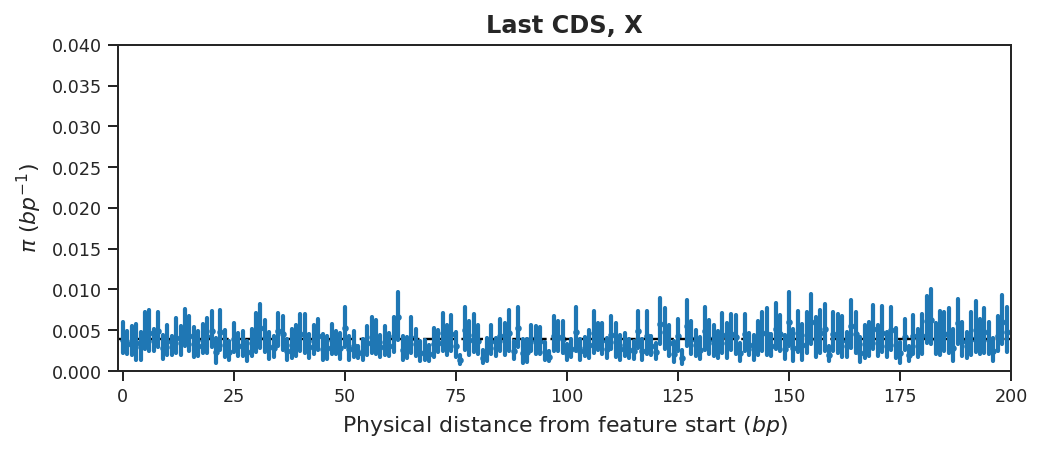

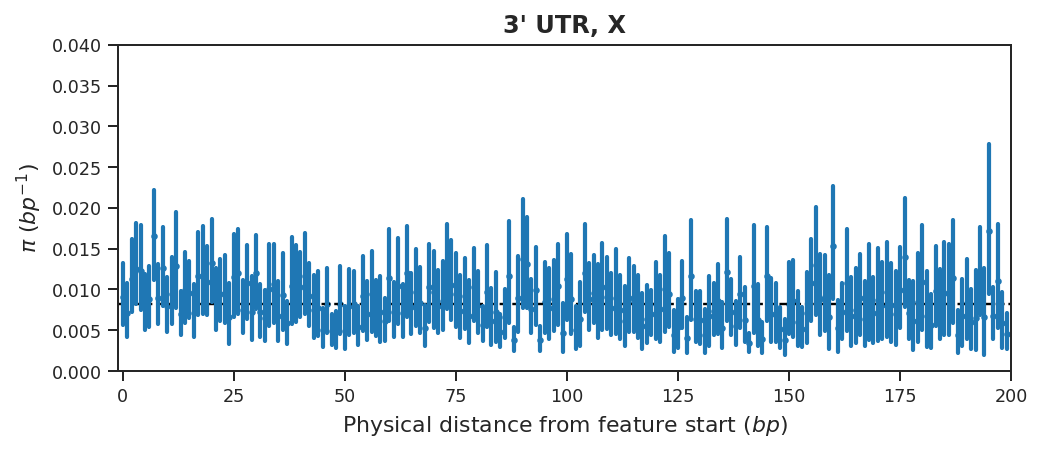

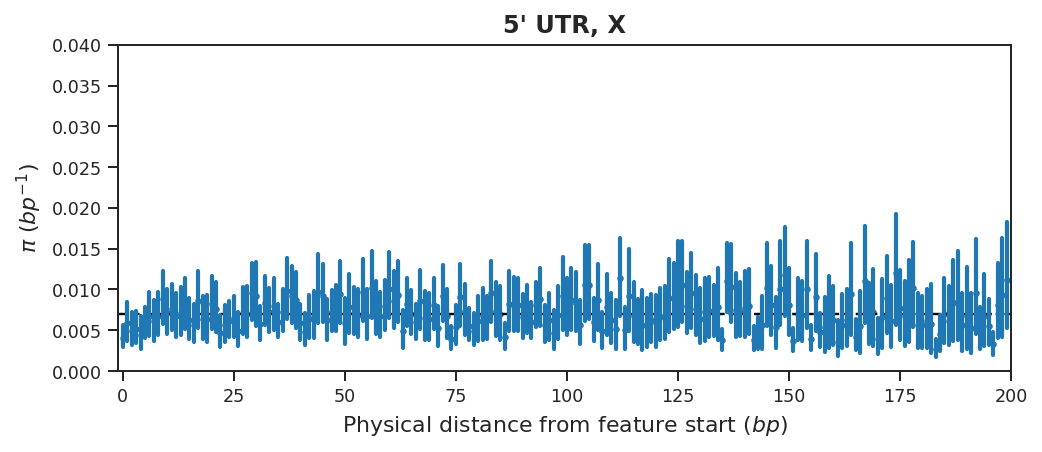

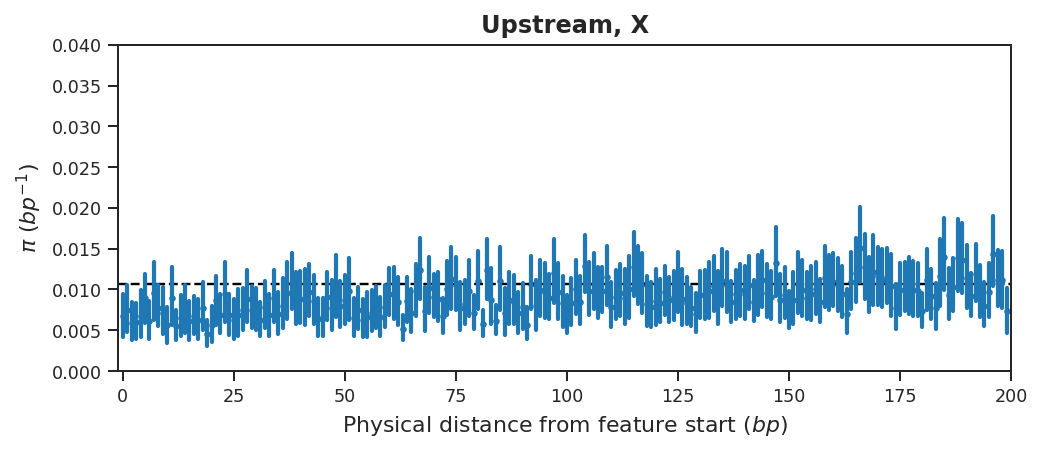

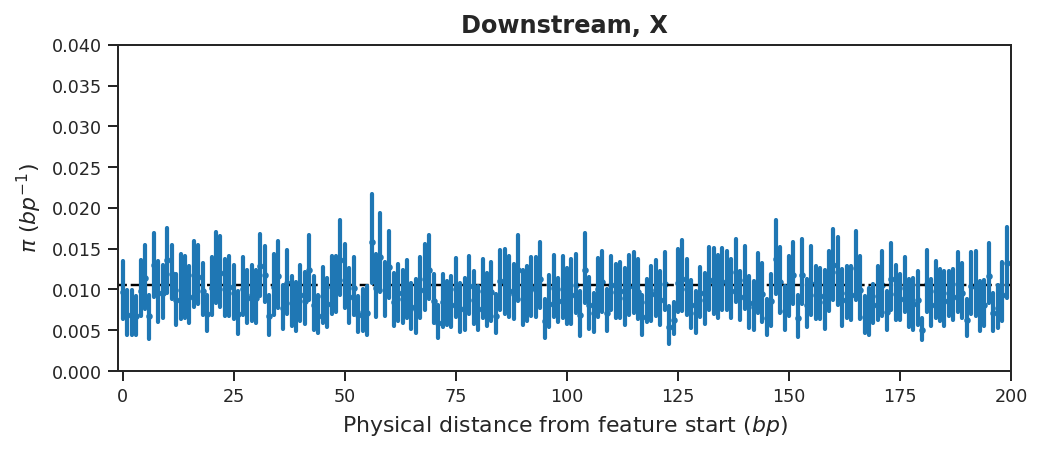

In [27]:
plot_all_feature_diversity('X')

### Distance from end

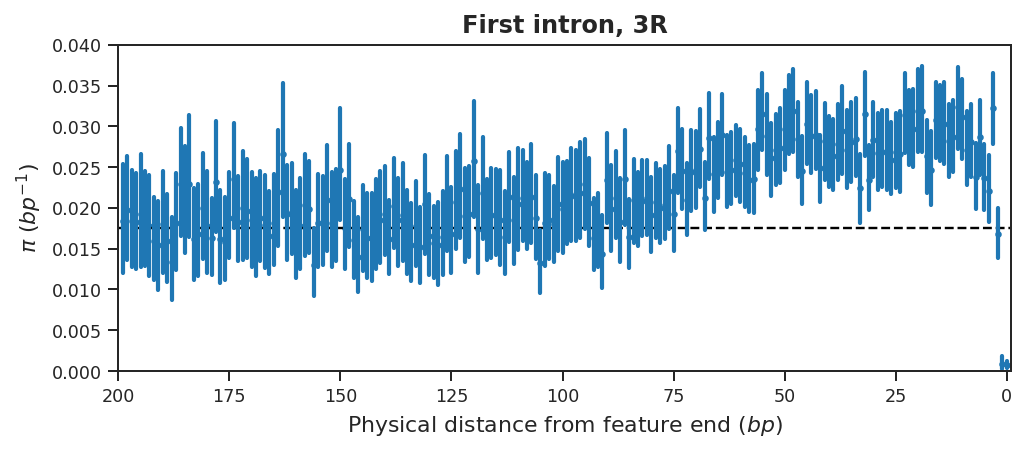

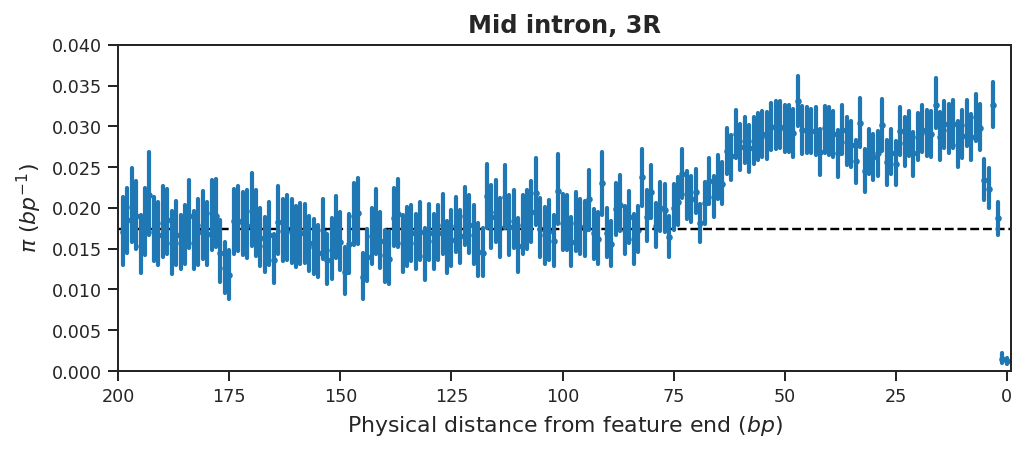

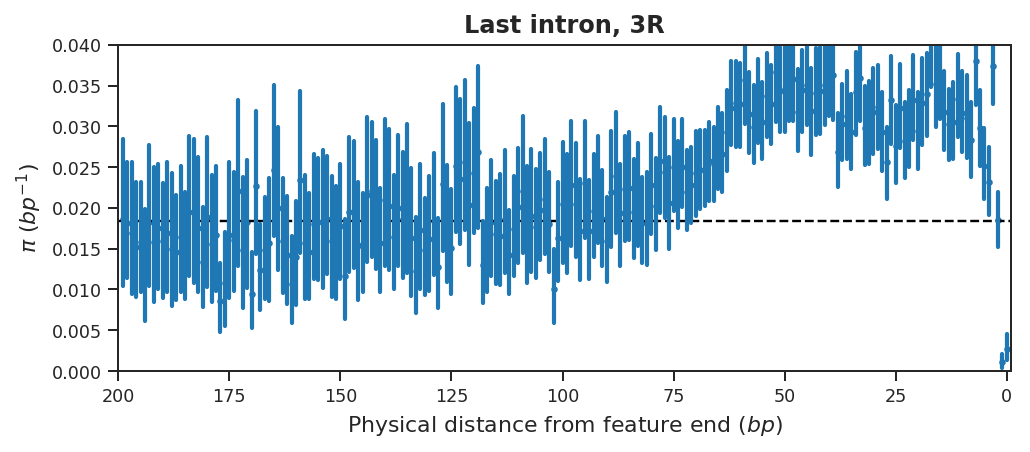

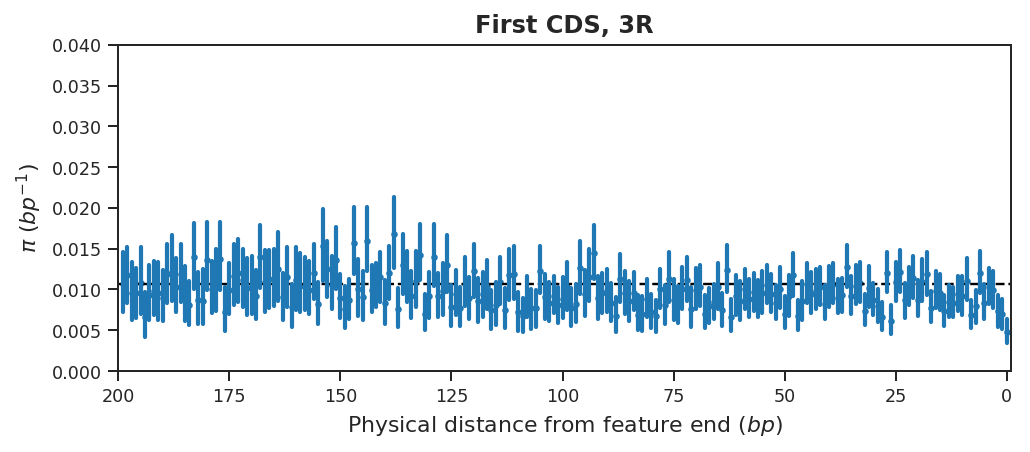

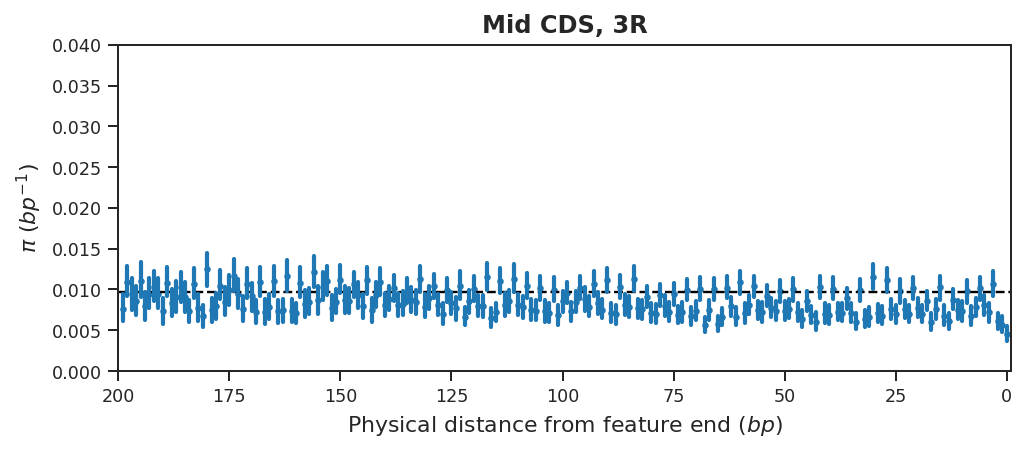

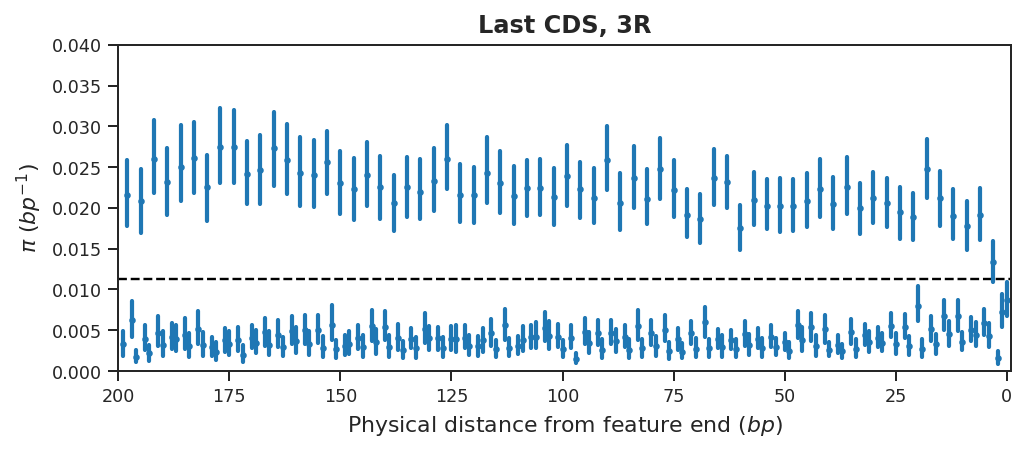

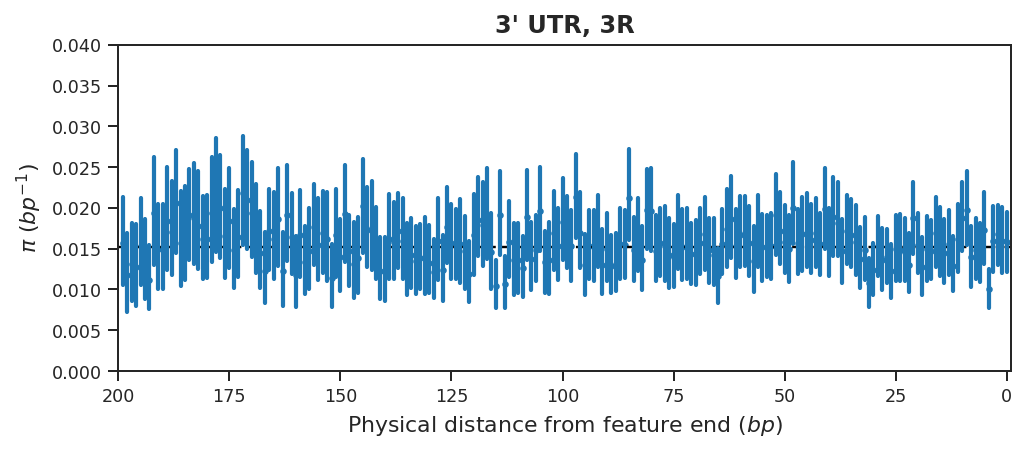

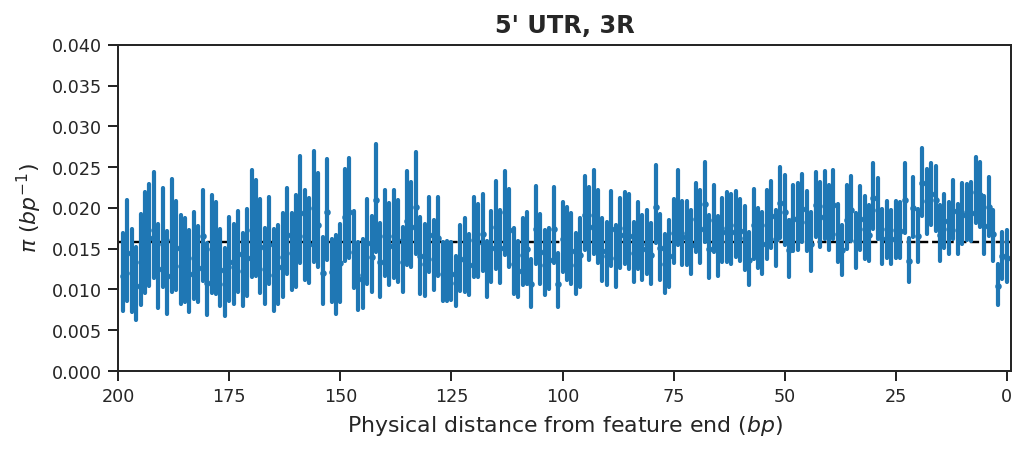

In [28]:
plot_all_feature_diversity_end('3R')

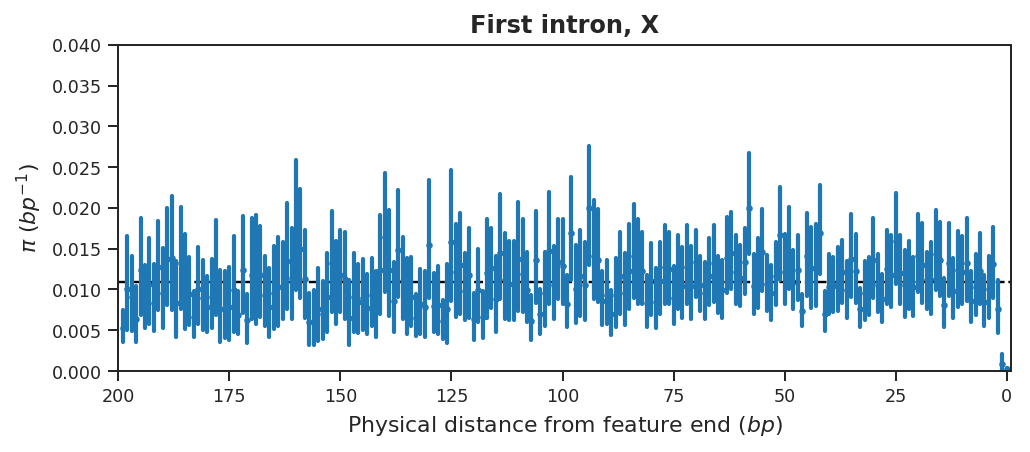

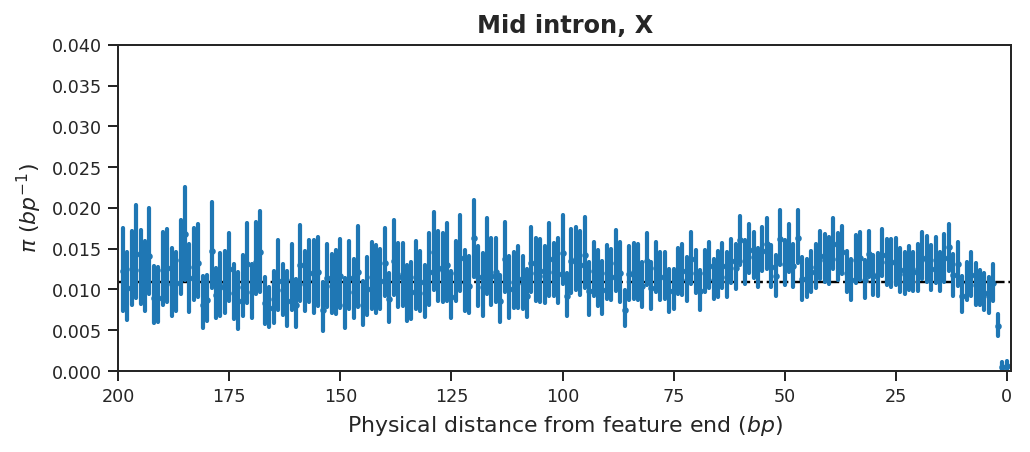

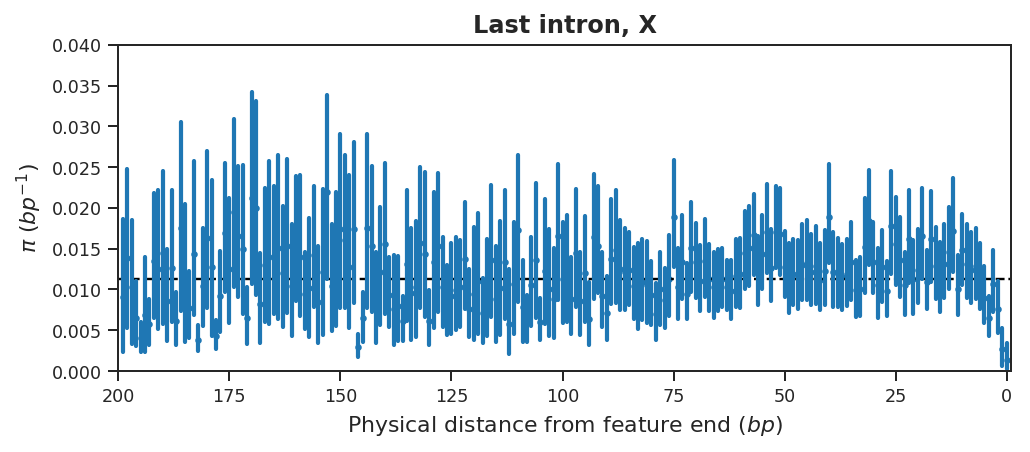

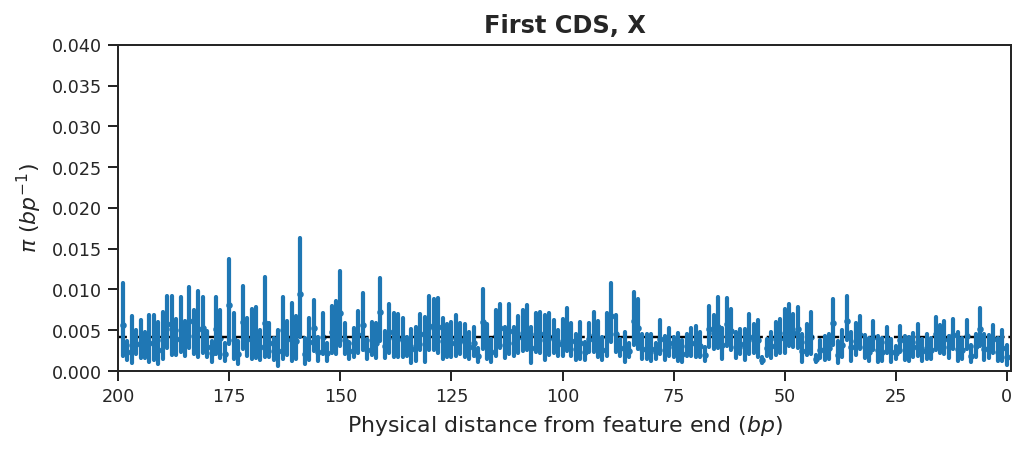

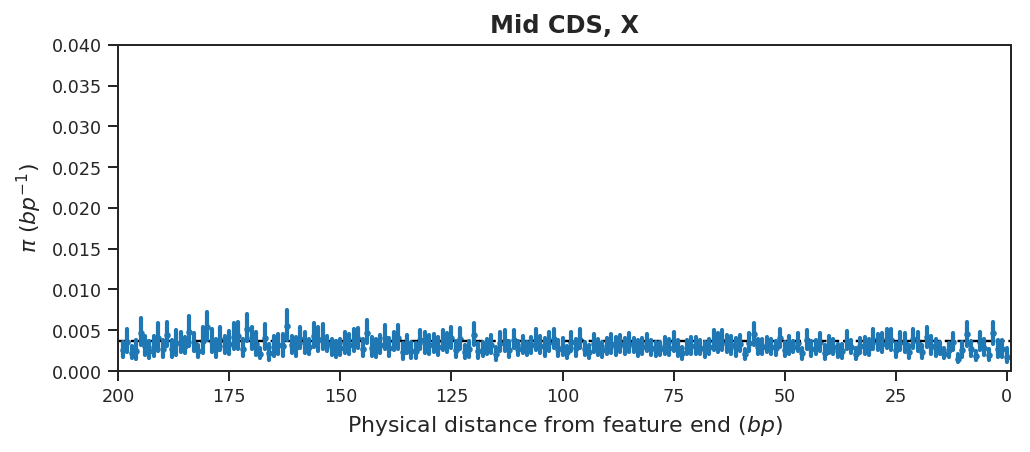

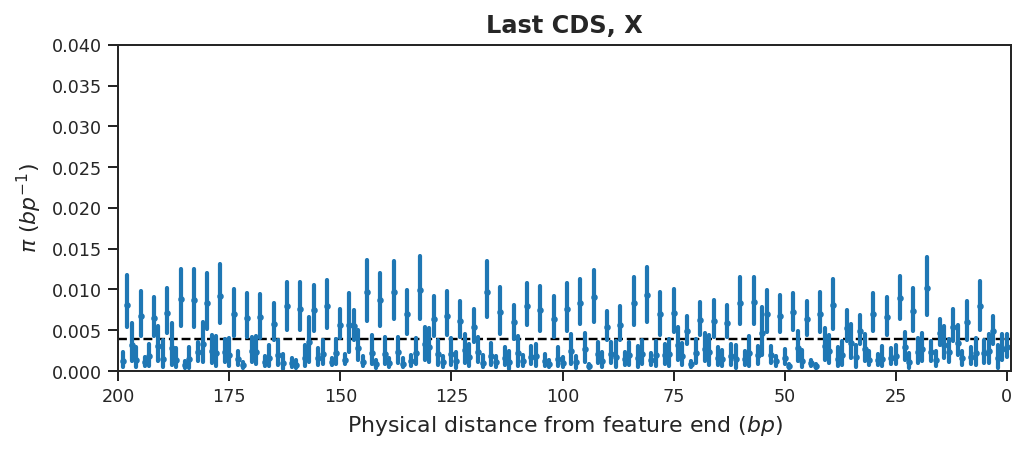

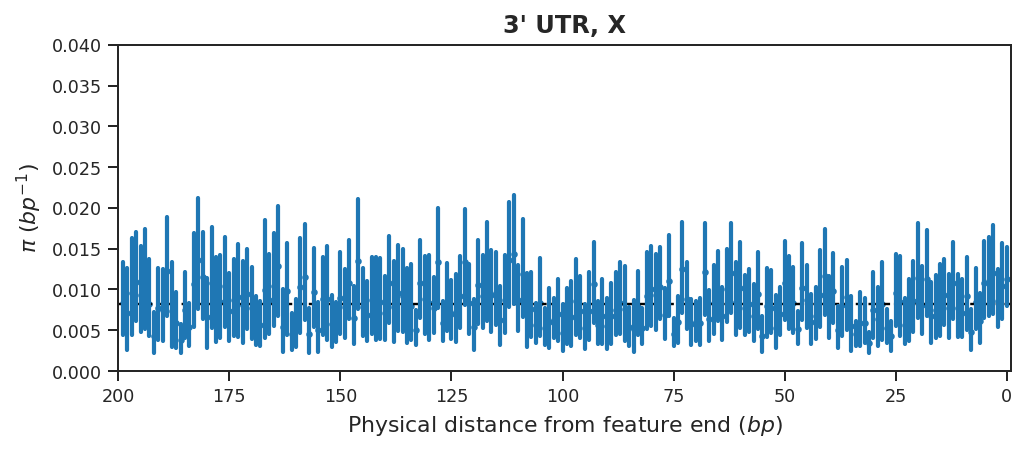

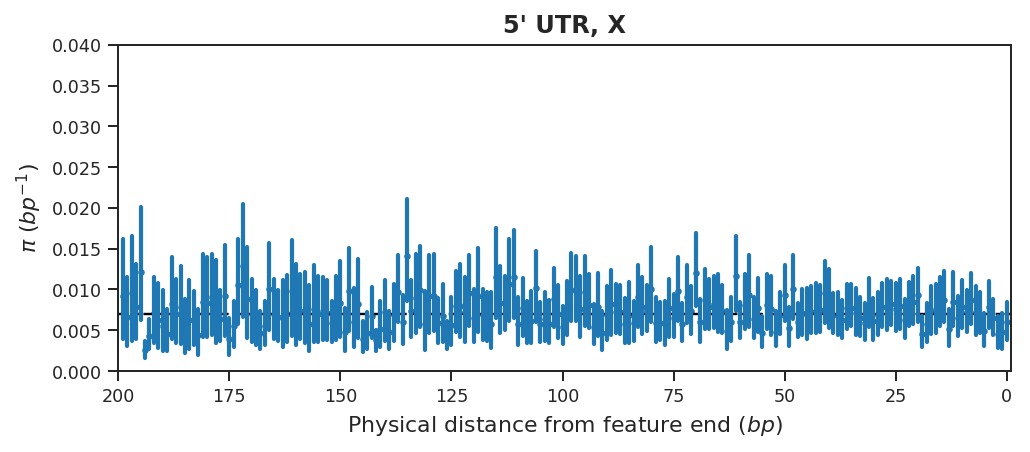

In [29]:
plot_all_feature_diversity_end('X')

### Feature length

In [30]:
def plot_feature_diversity_length(chrom, cls, x_min, x_max, x_bin_width, y_max=0.04, title=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_flen < x_max) & (seq_flen > x_min)
    dist = seq_flen[flt]
    values = seq_mpd[flt]

    # plot
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111, facecolor='none')
    sns.despine(ax=ax, offset=5)
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, x_bins=np.arange(x_min, x_max, x_bin_width) + (x_bin_width//2),
                fit_reg=False, ax=ax, scatter_kws=dict(s=15, color='k'))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Feature length ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_zorder(2)
        
    ax = ax.twinx()
    sns.despine(ax=ax, top=True, left=True, bottom=True, right=False, offset=5)
    ax.hist(dist, bins=np.arange(x_min, x_max, x_bin_width), zorder=-20)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.yaxis.set_label_position('right')
    ax.set_xlim(left=-1, right=x_max)
    ax.set_zorder(1)
    plt.show()


In [31]:
def plot_all_feature_diversity_length(chrom, x_min=1, x_max=1000, x_bin_width=20, y_max=0.04):
    plot_feature_diversity_length(chrom, CLS_INTRON_FIRST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="First intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_INTRON_MID, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Mid intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_INTRON_LAST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Last intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_EXON_FIRST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="First CDS, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_EXON_MID, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Mid CDS, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_EXON_LAST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Last CDS, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_3UTR, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="3' UTR, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_5UTR, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="5' UTR, %s" % chrom)


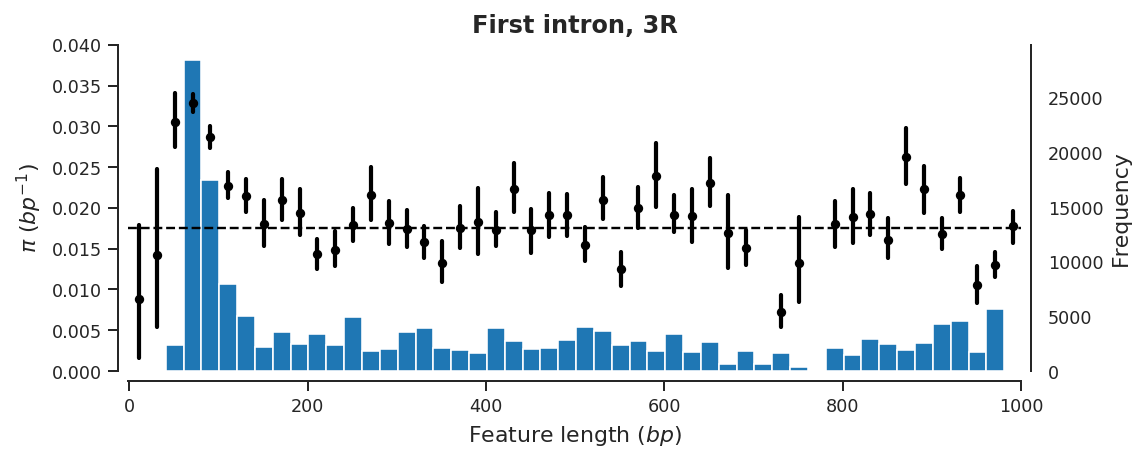

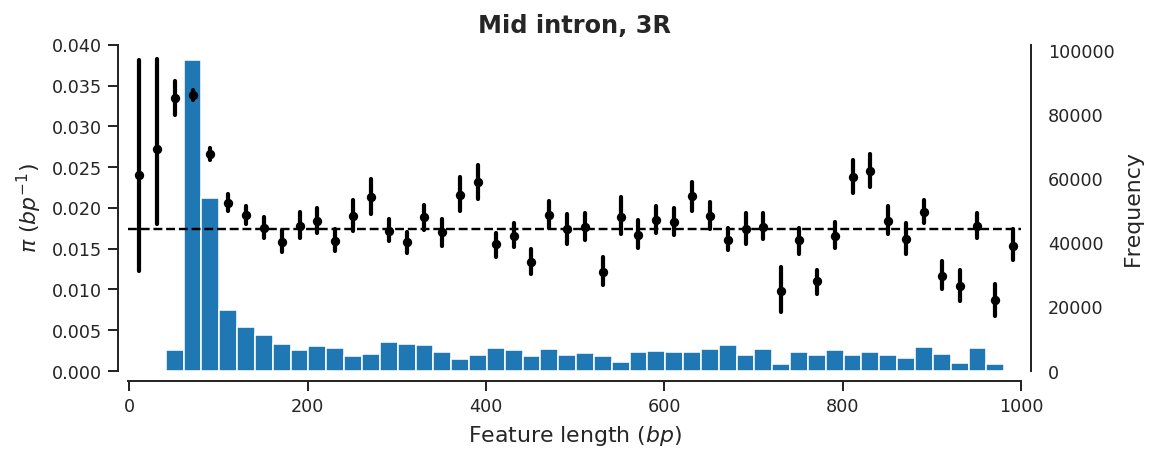

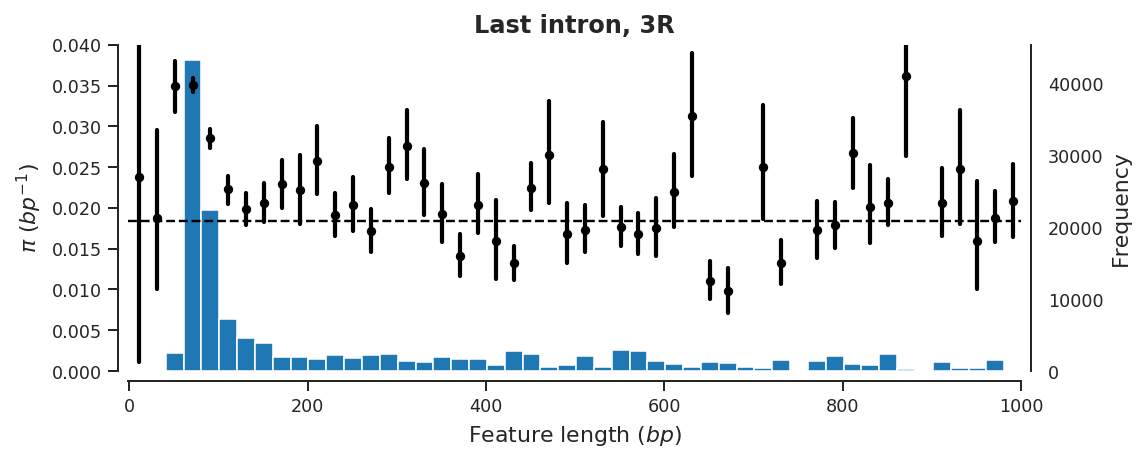

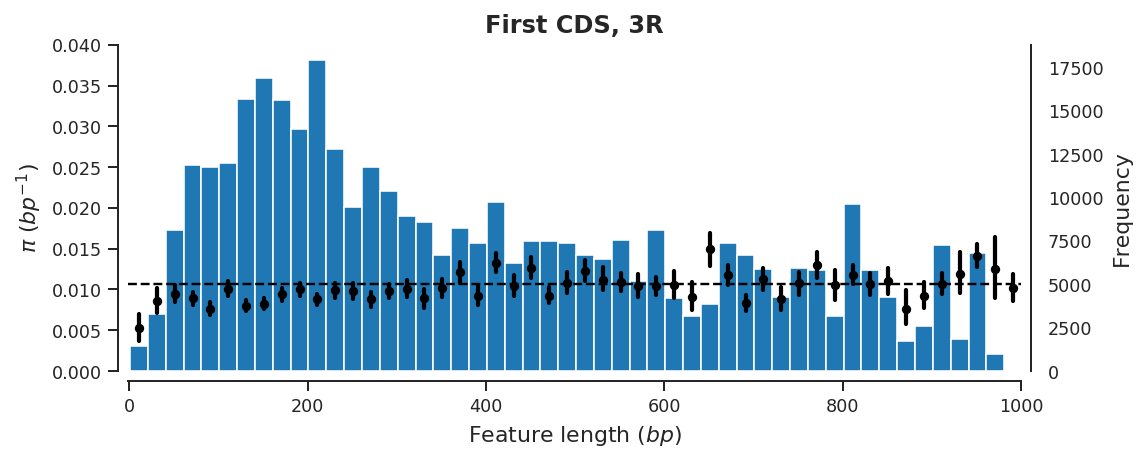

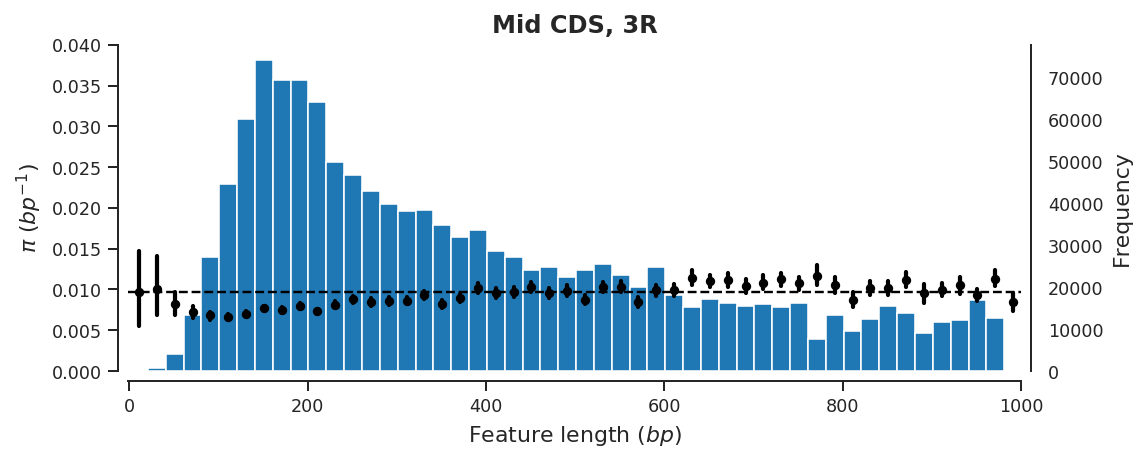

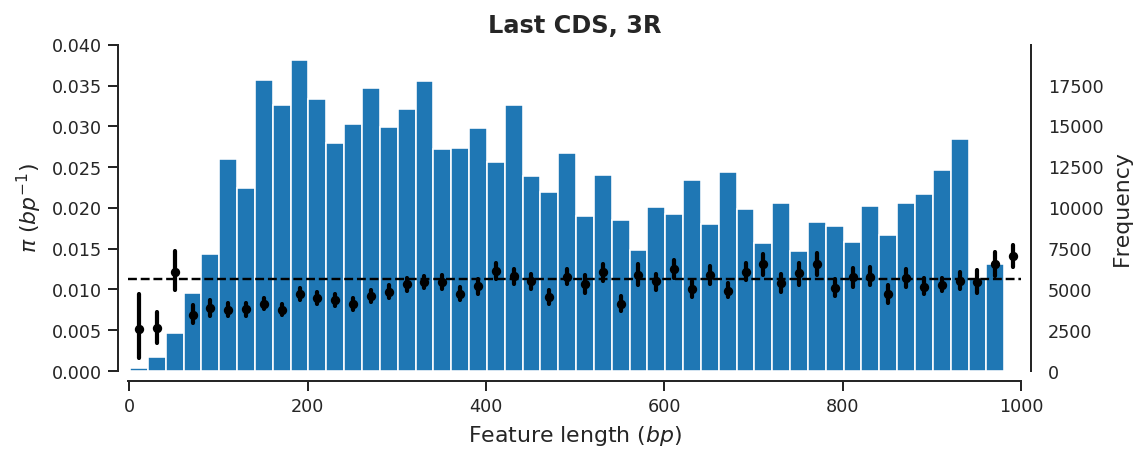

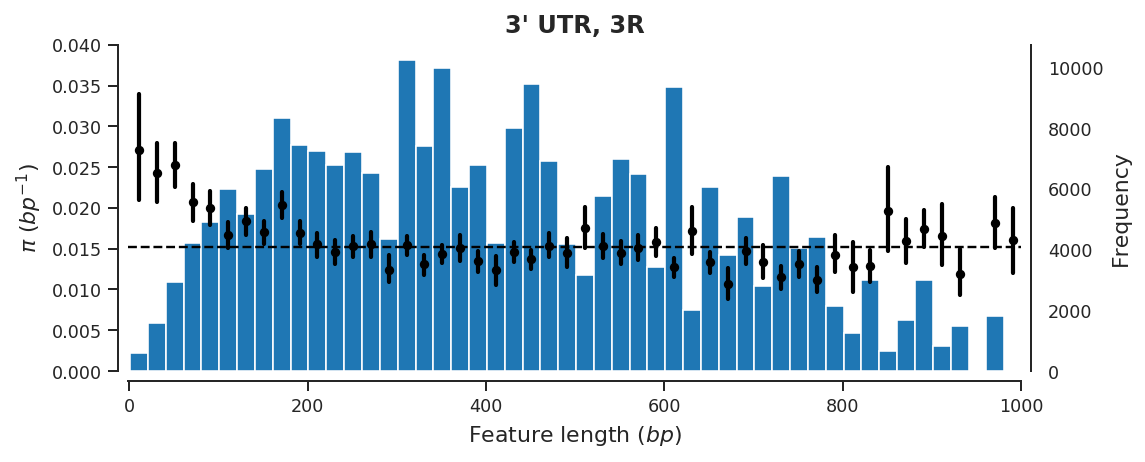

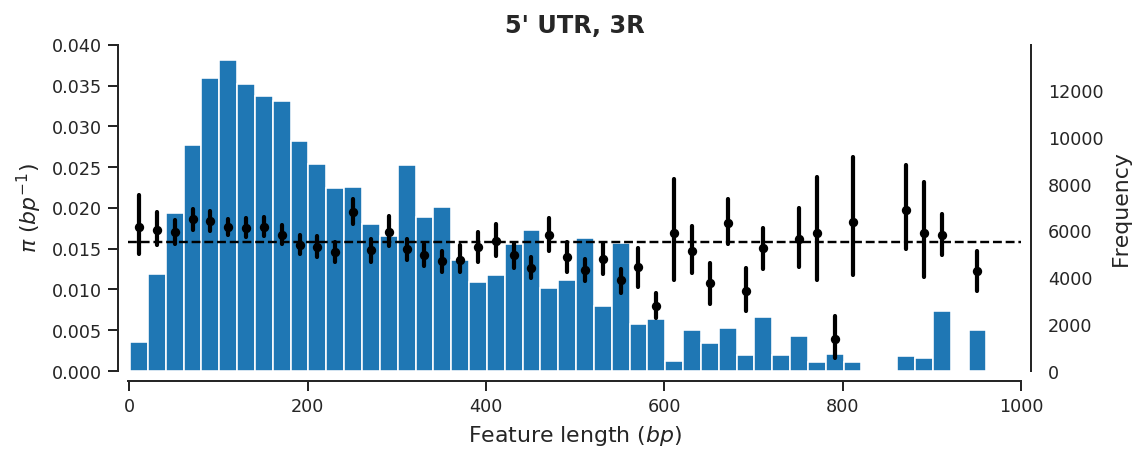

In [32]:
plot_all_feature_diversity_length('3R')

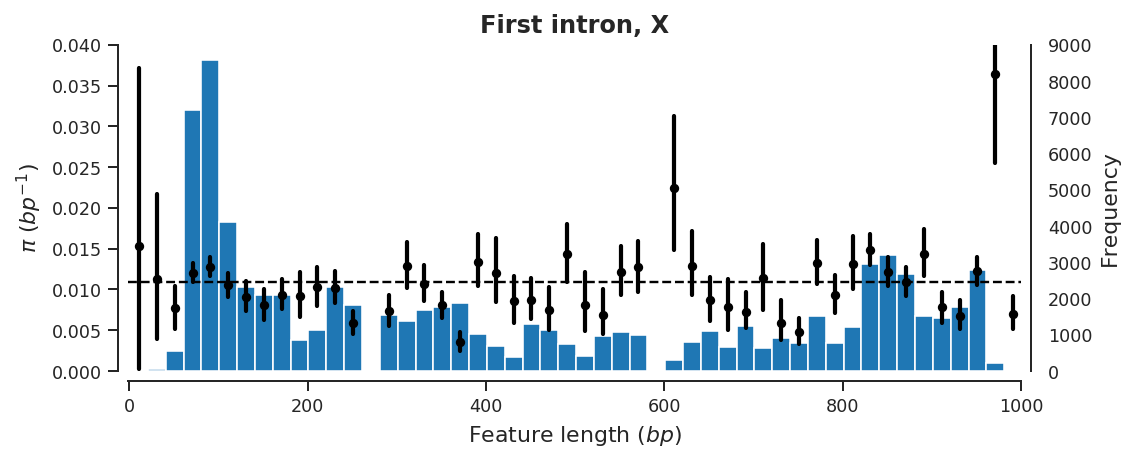

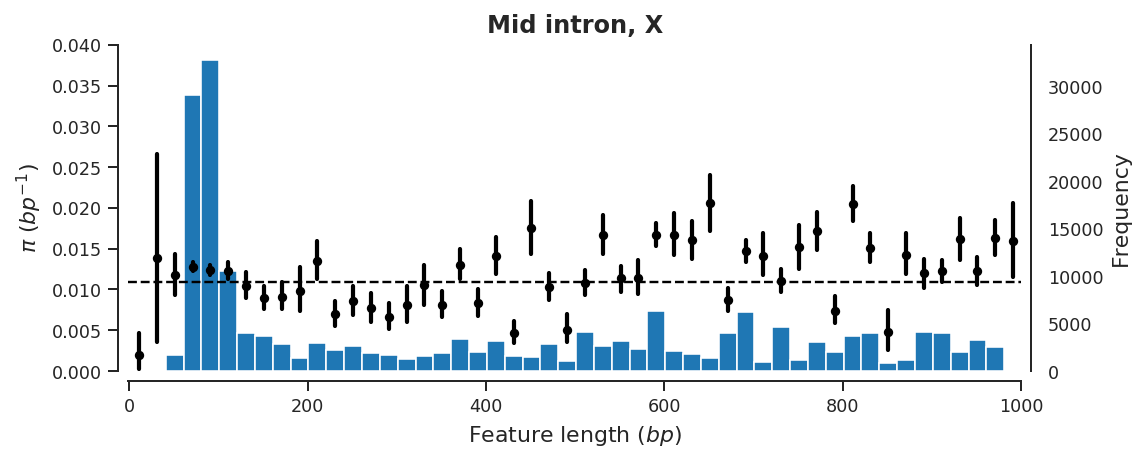

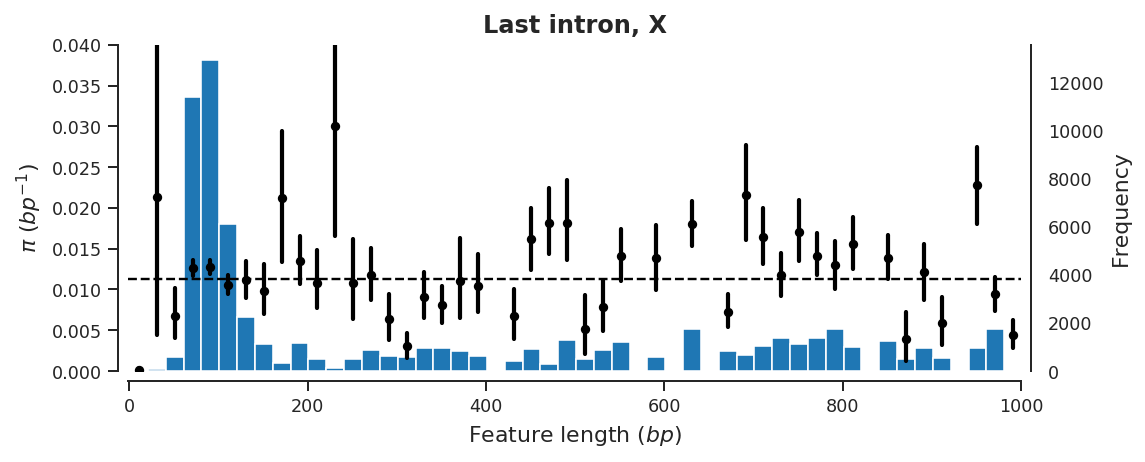

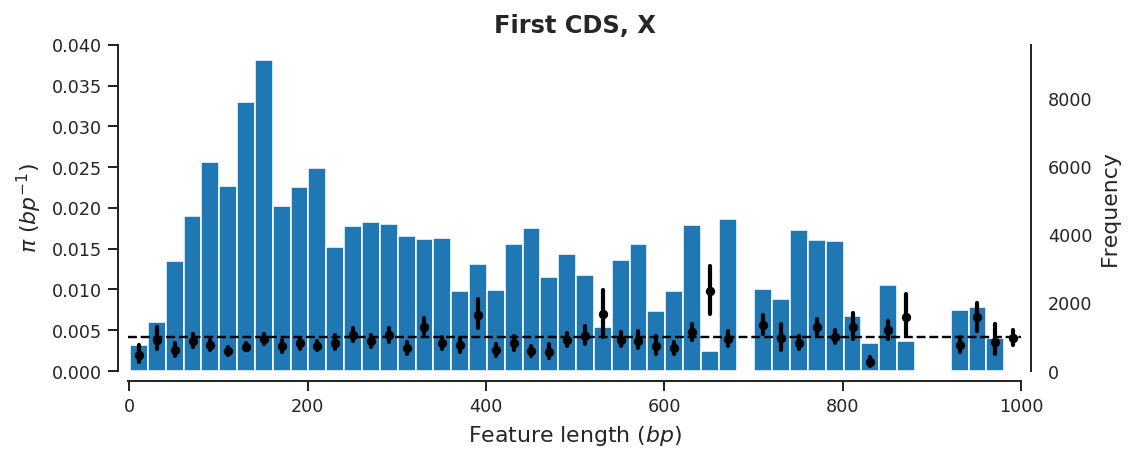

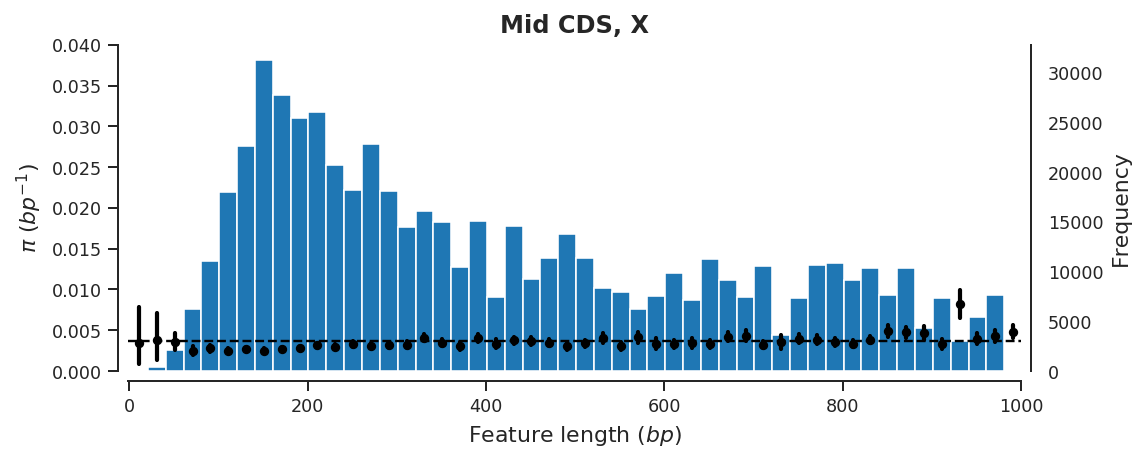

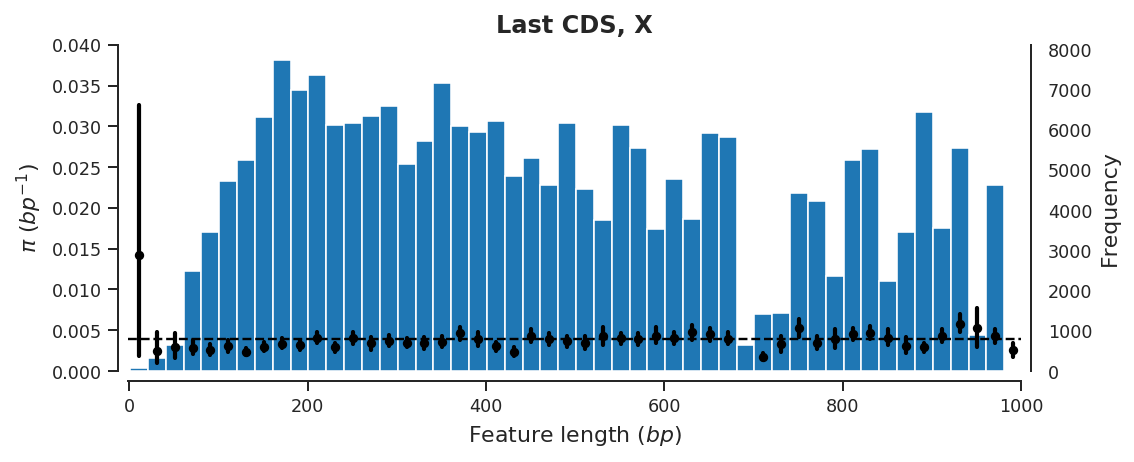

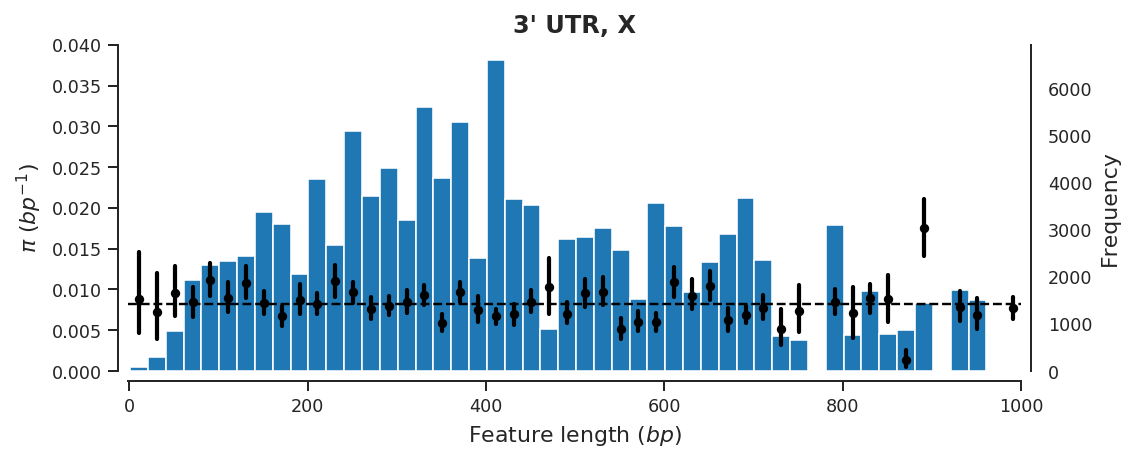

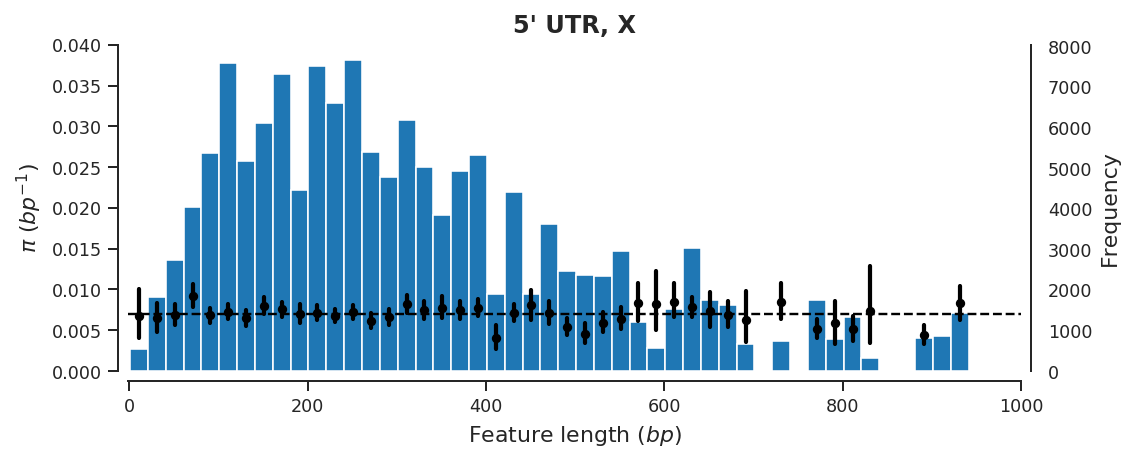

In [33]:
plot_all_feature_diversity_length('X')

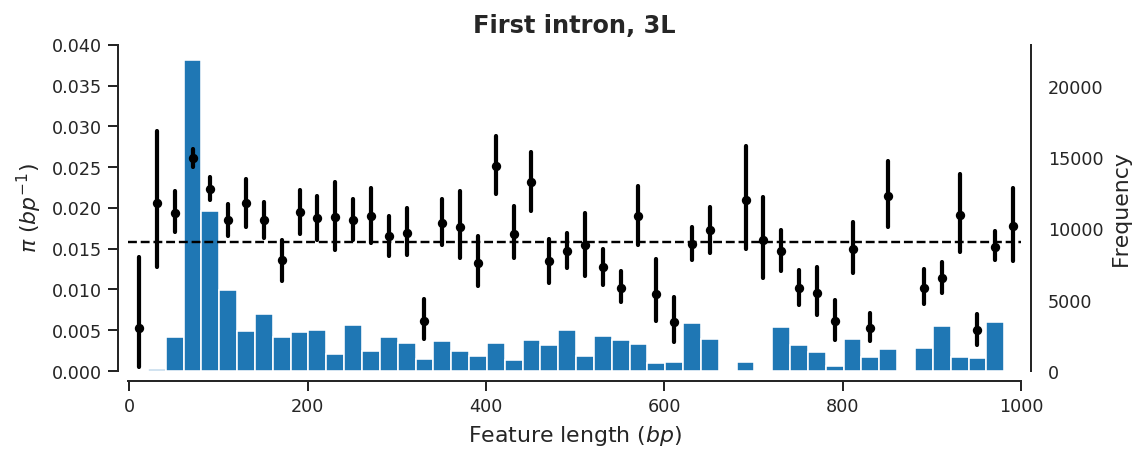

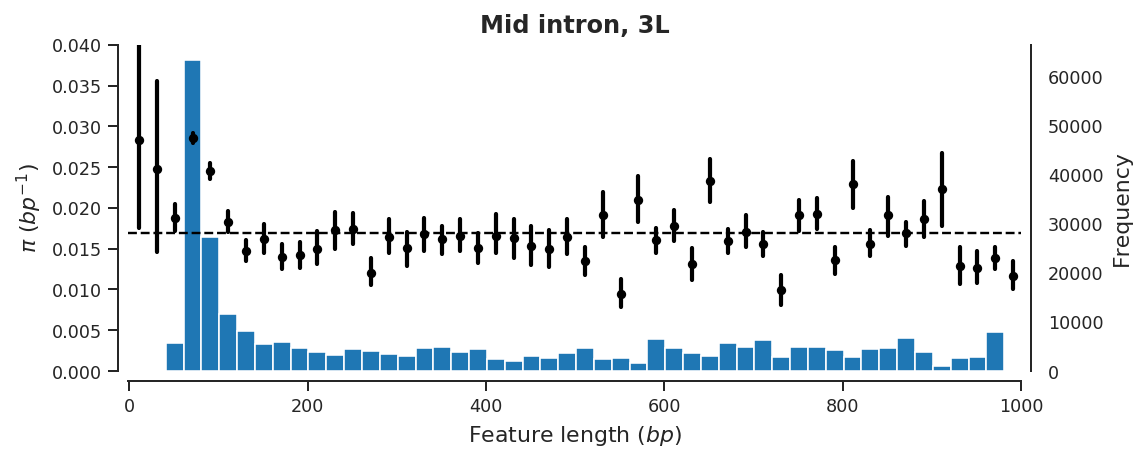

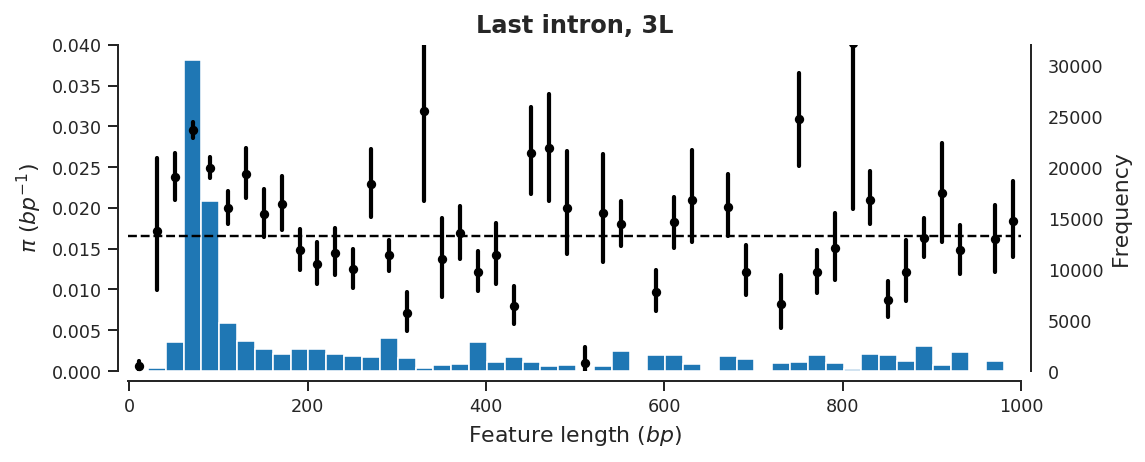

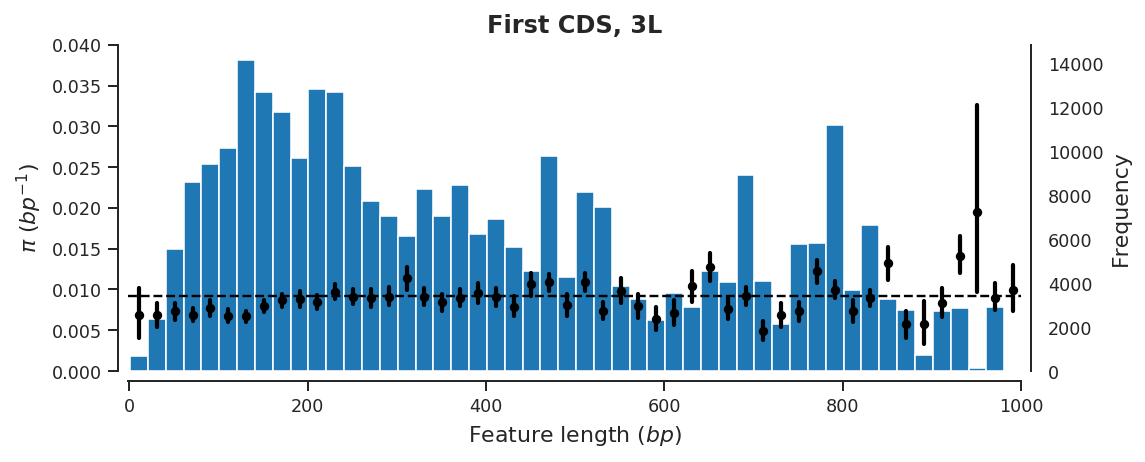

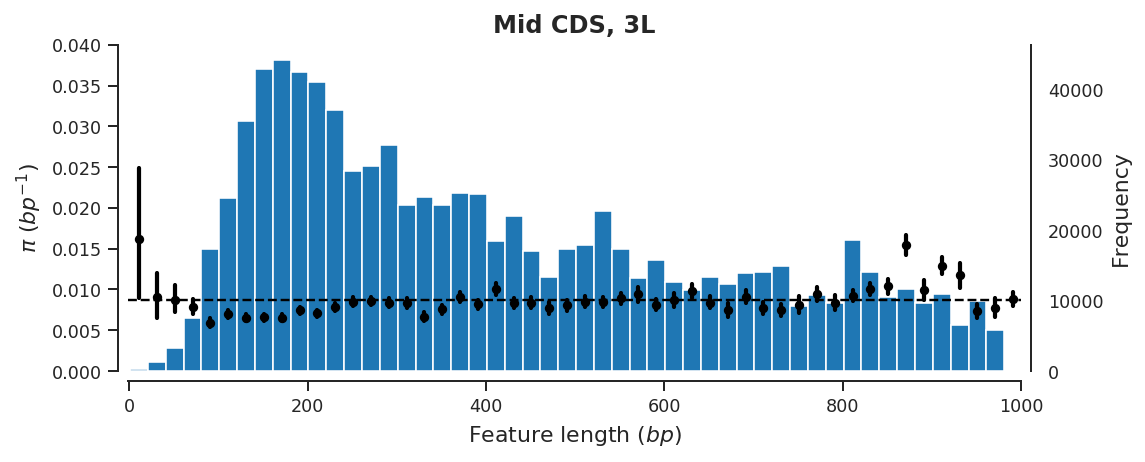

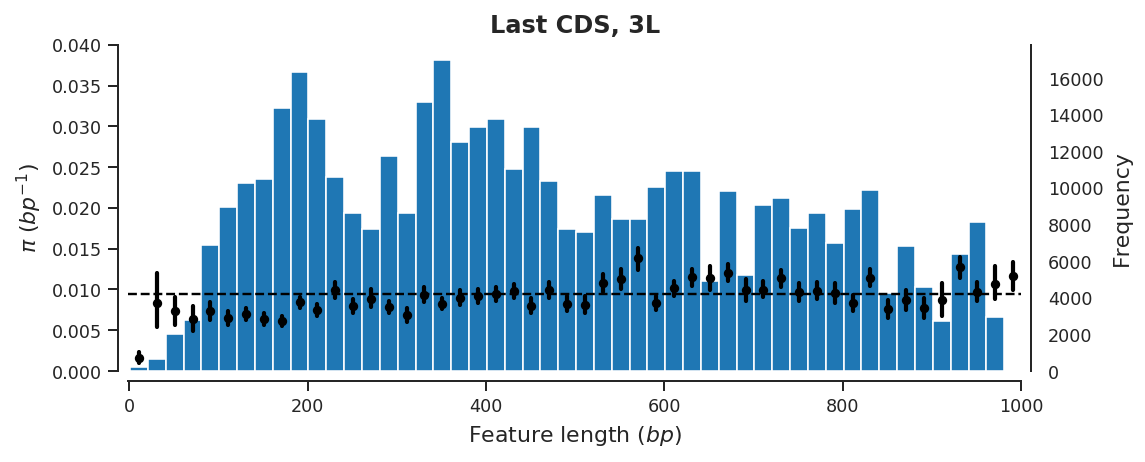

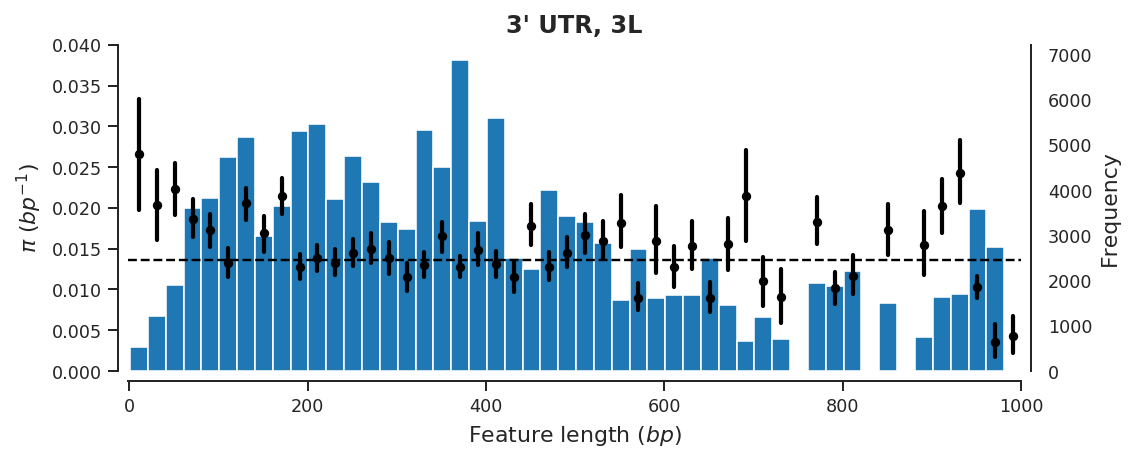

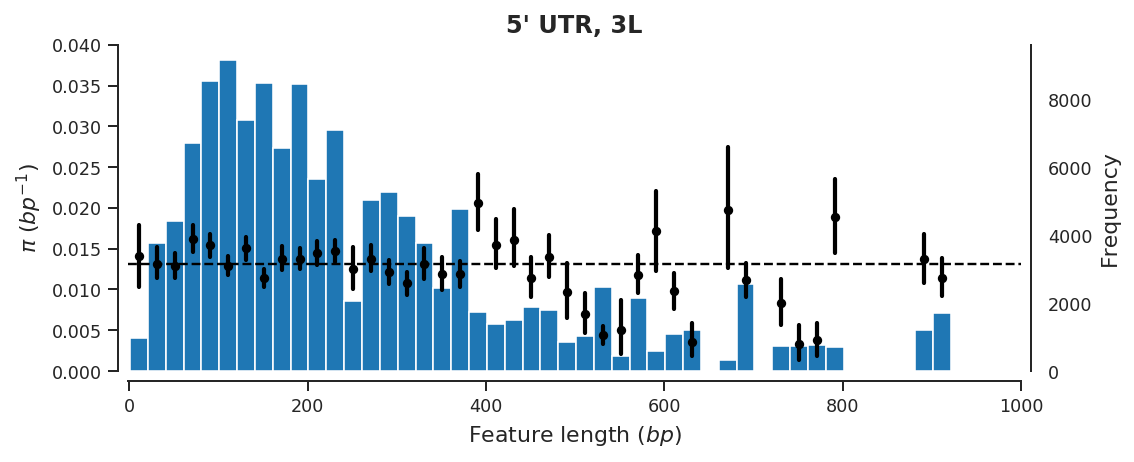

In [34]:
plot_all_feature_diversity_length('3L')

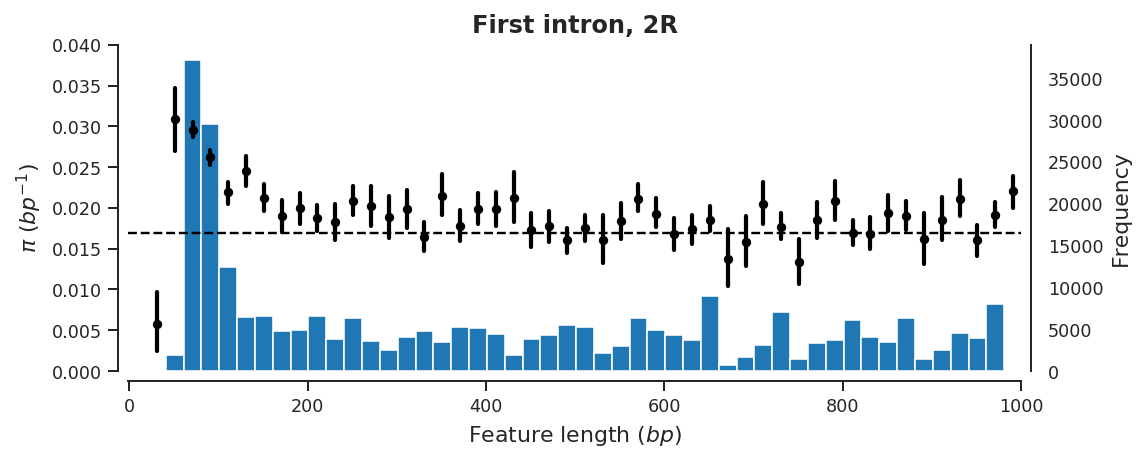

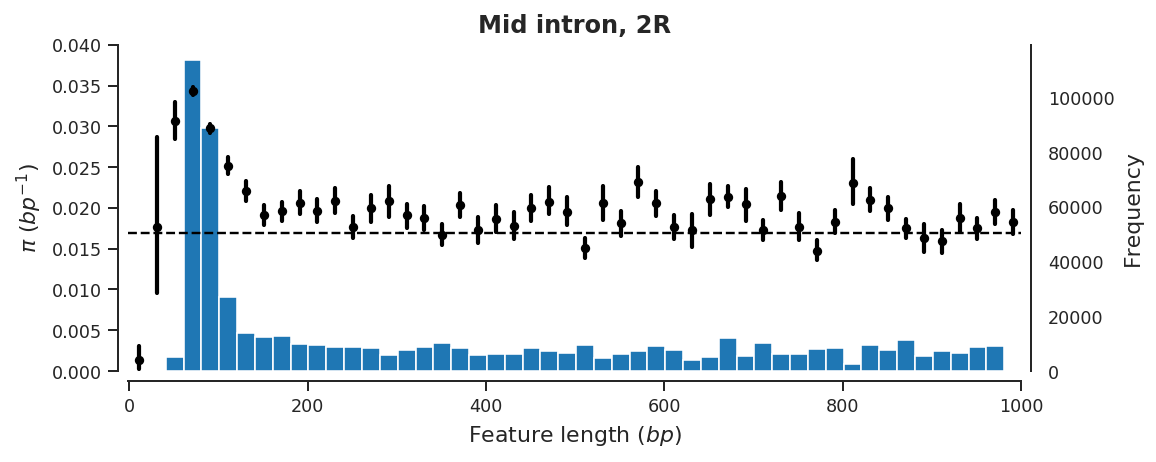

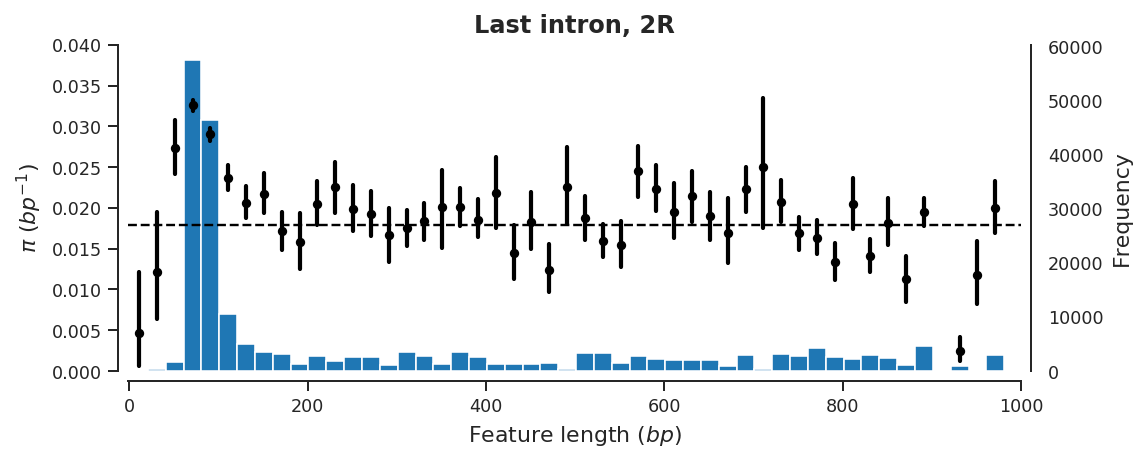

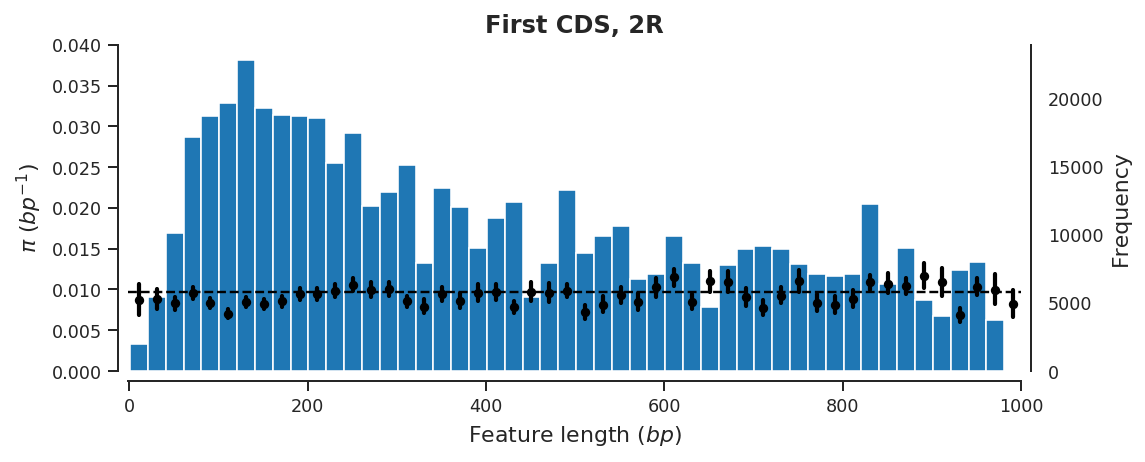

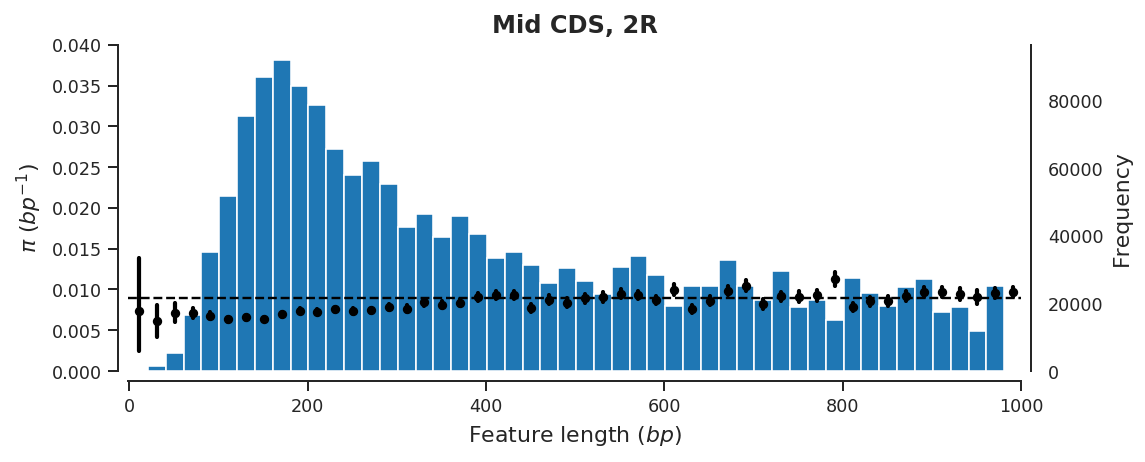

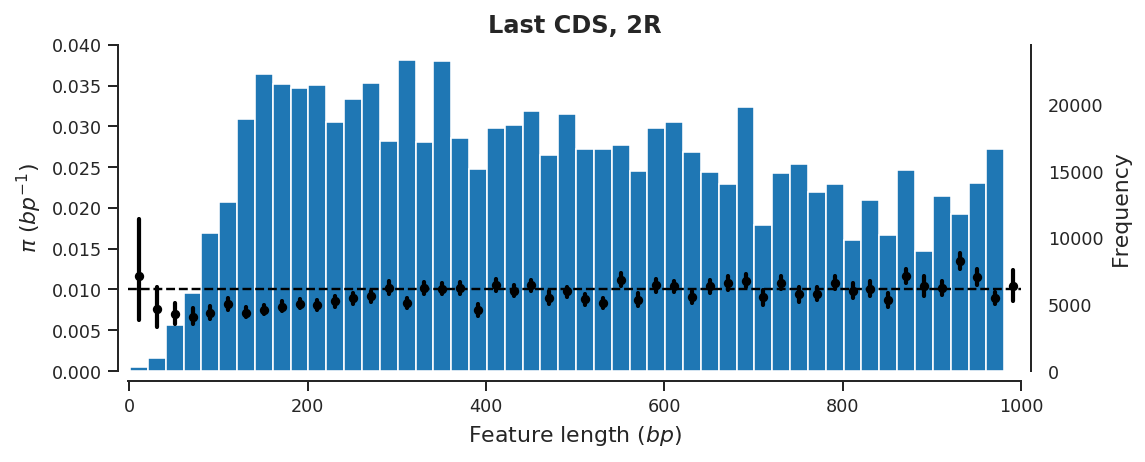

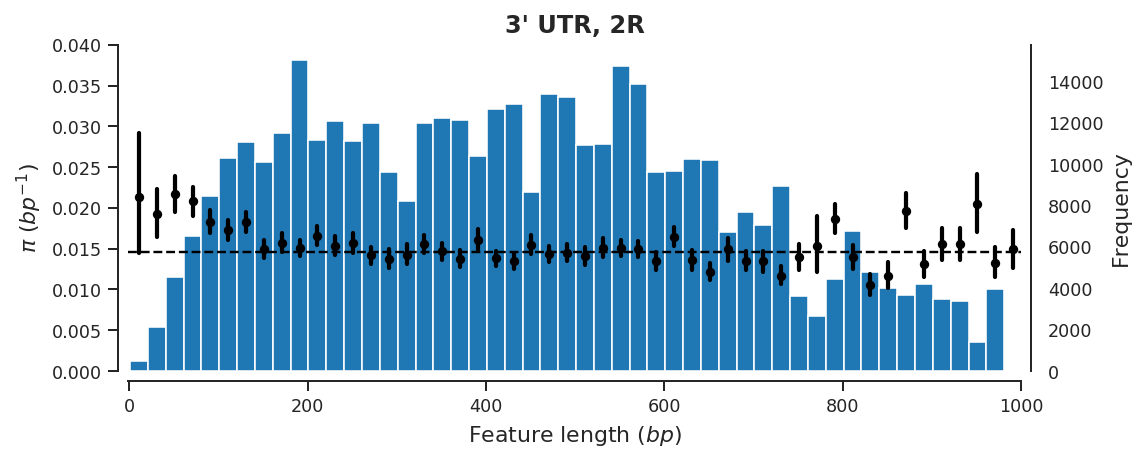

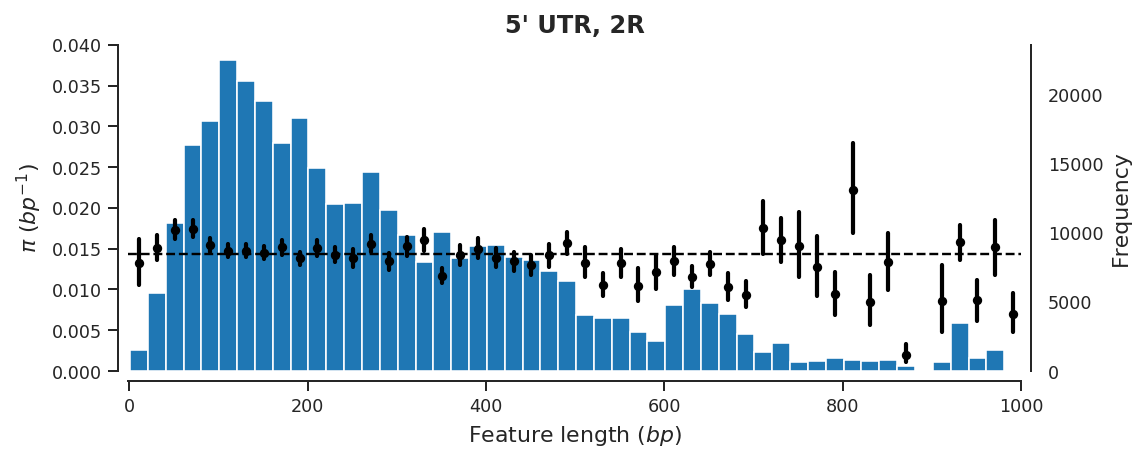

In [35]:
plot_all_feature_diversity_length('2R')

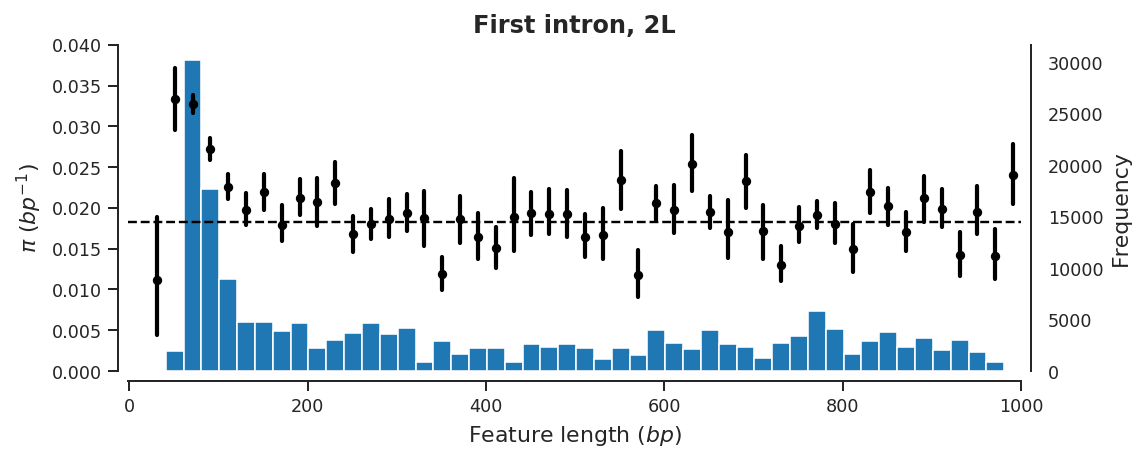

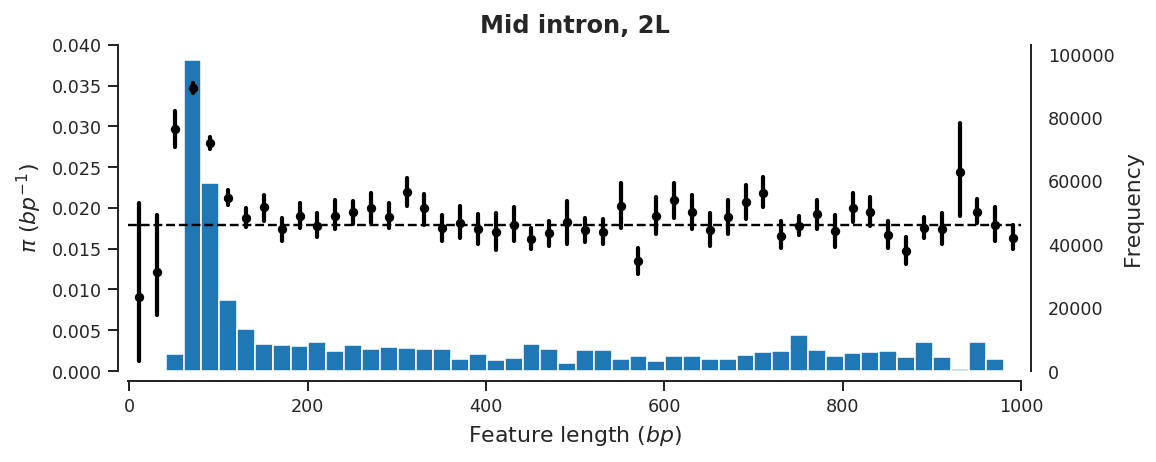

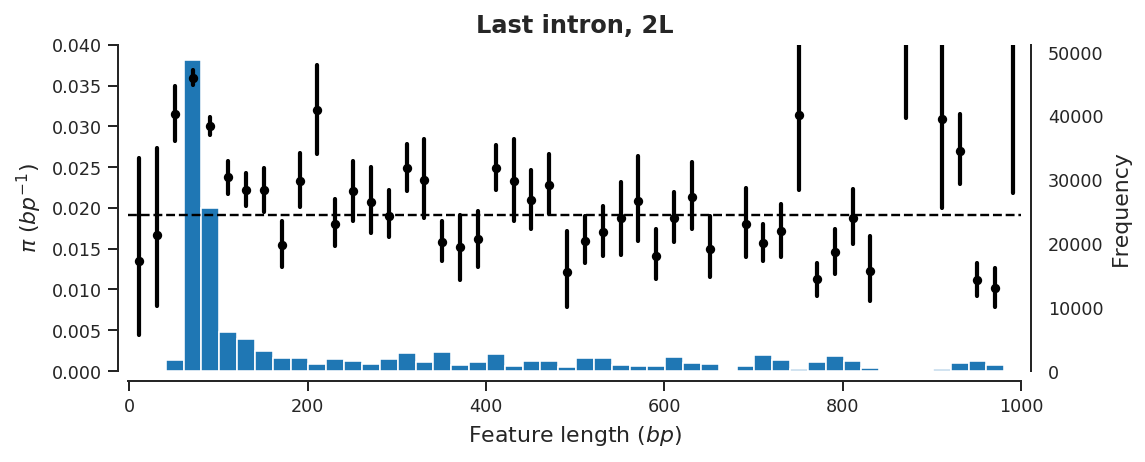

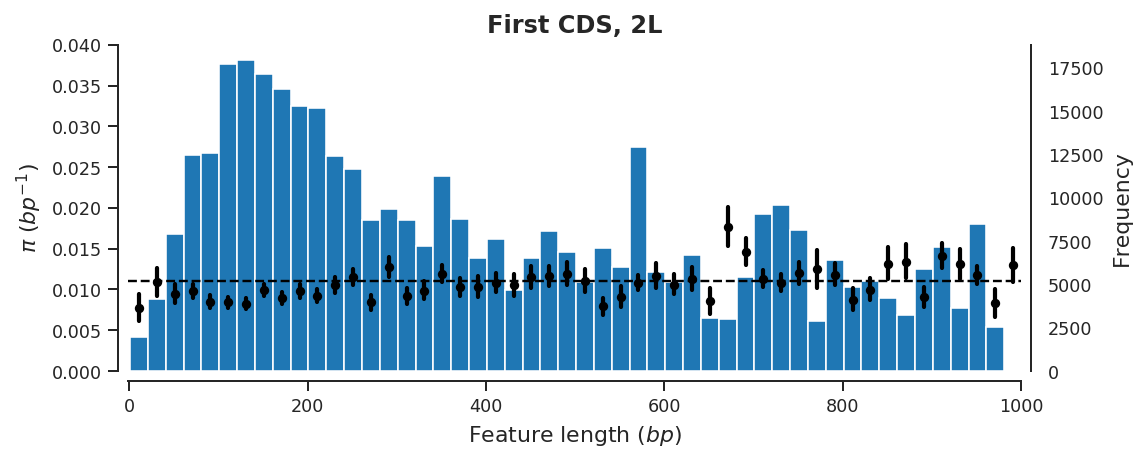

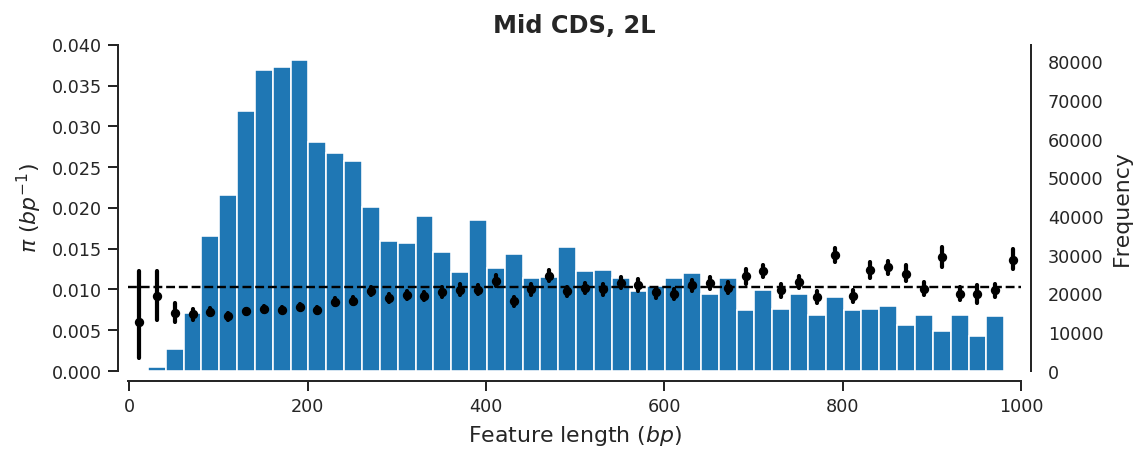

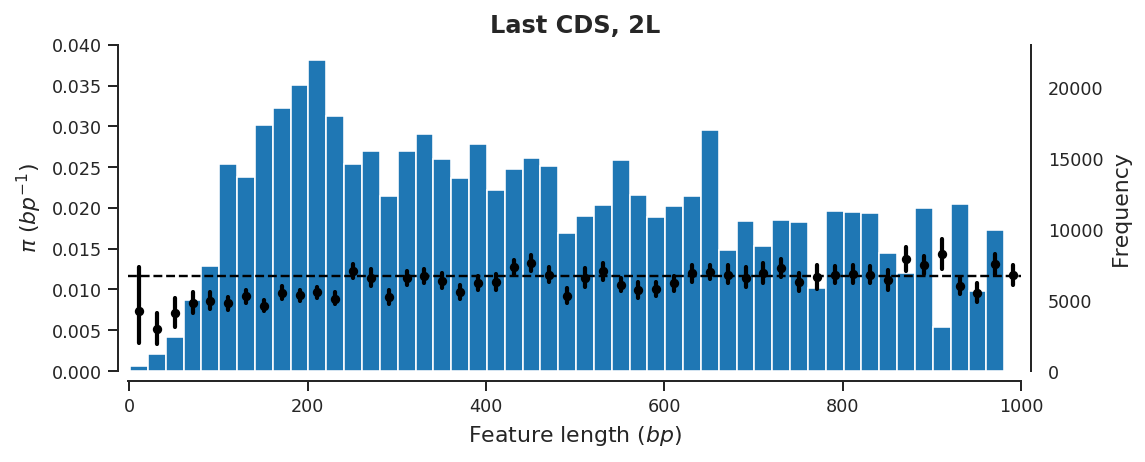

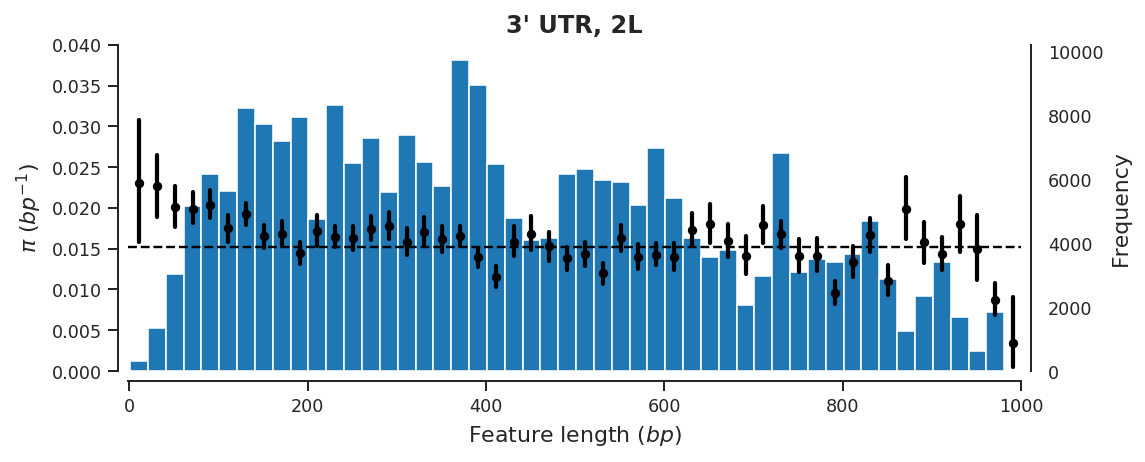

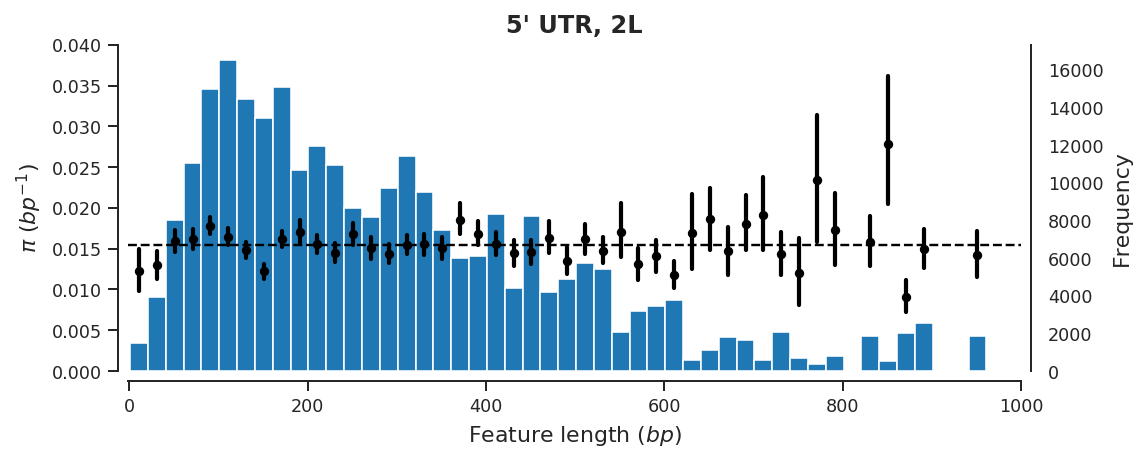

In [36]:
plot_all_feature_diversity_length('2L')

### Distance from start/end (min feature length)

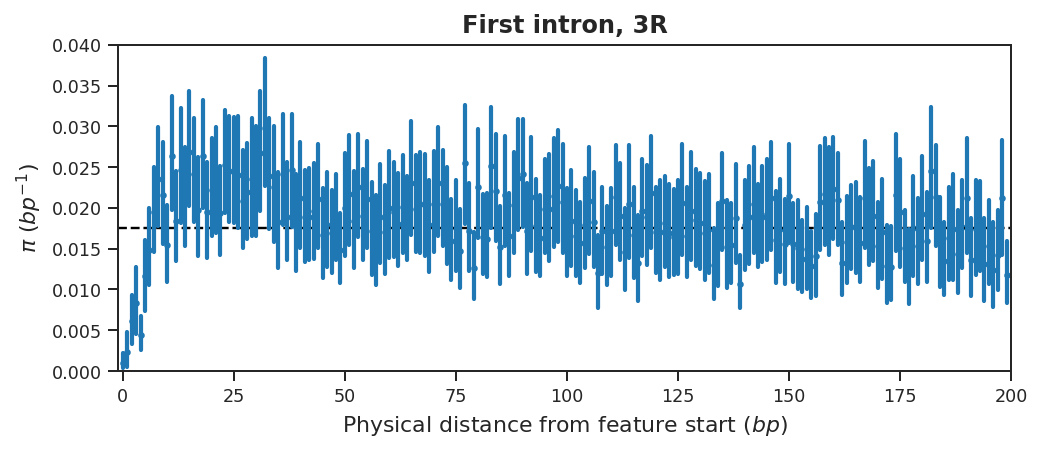

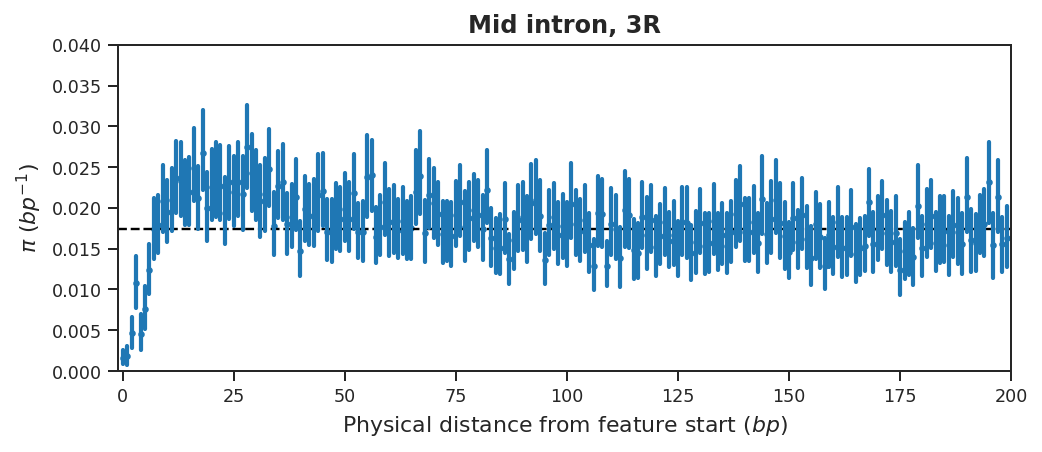

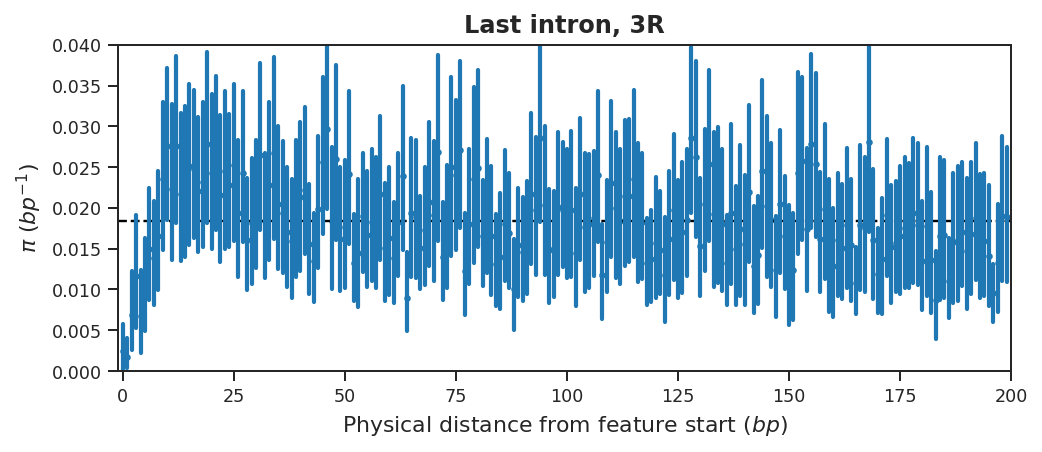

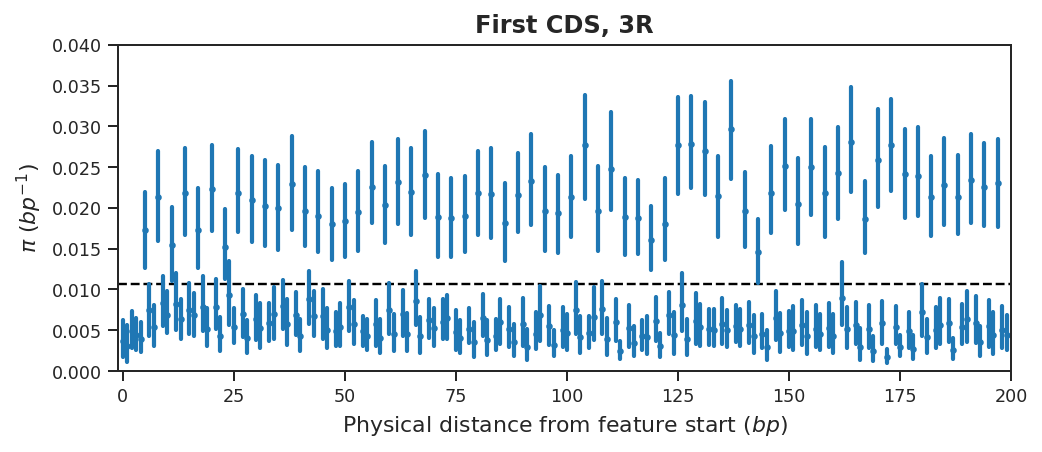

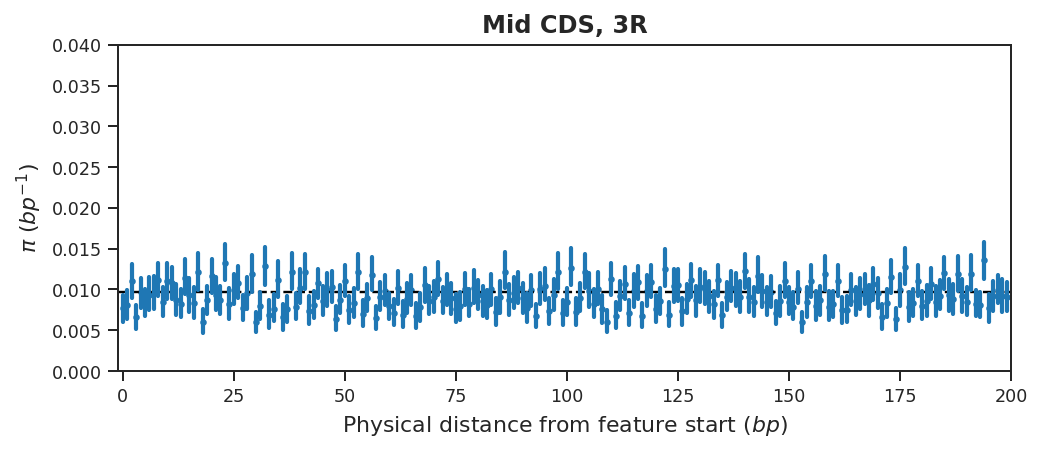

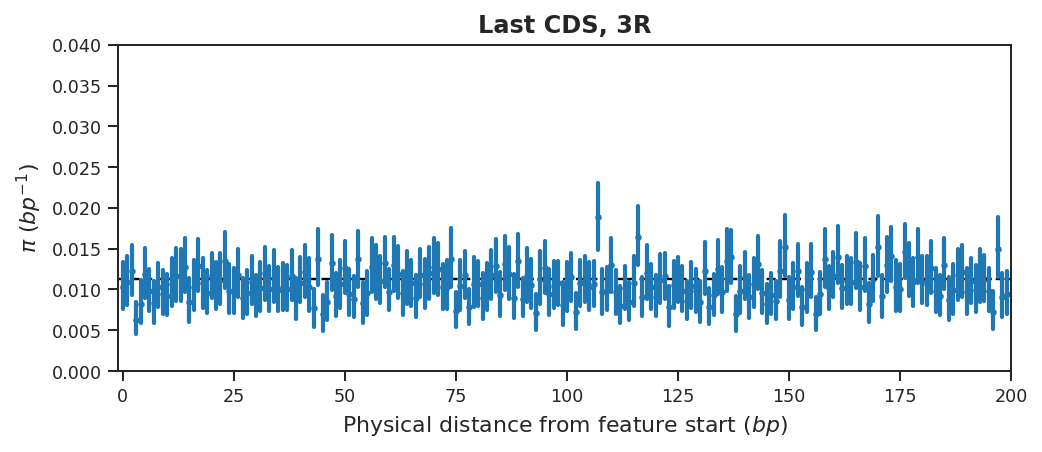

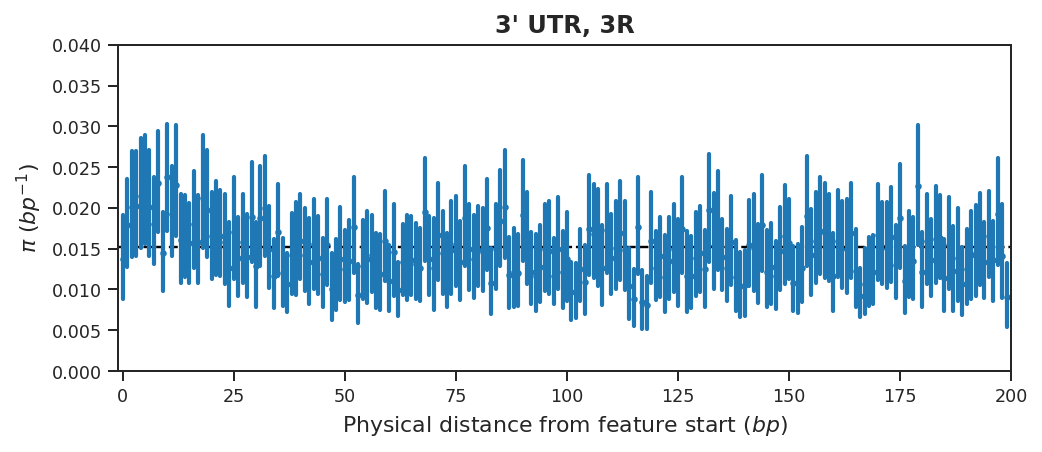

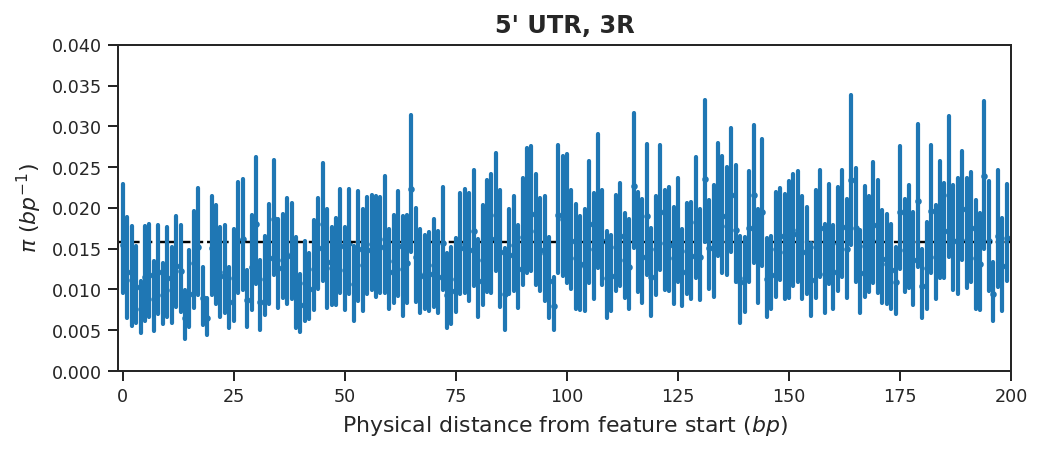

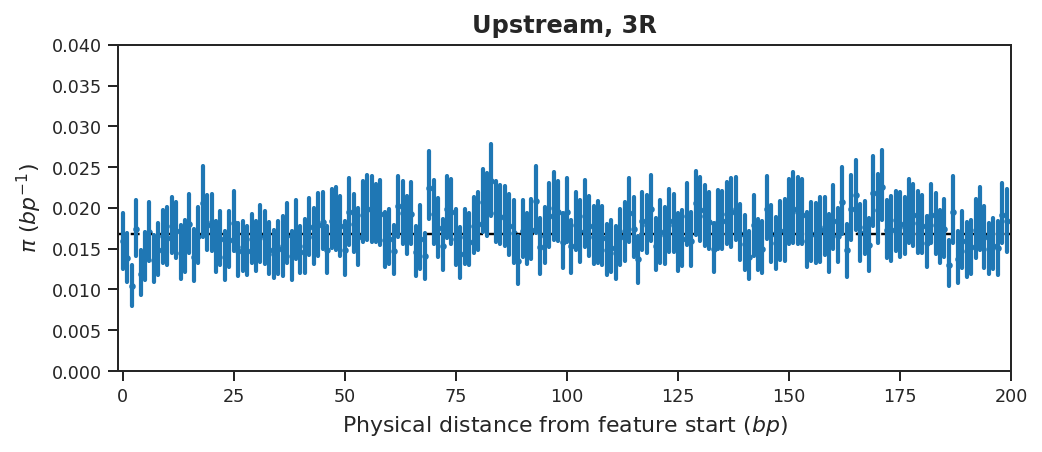

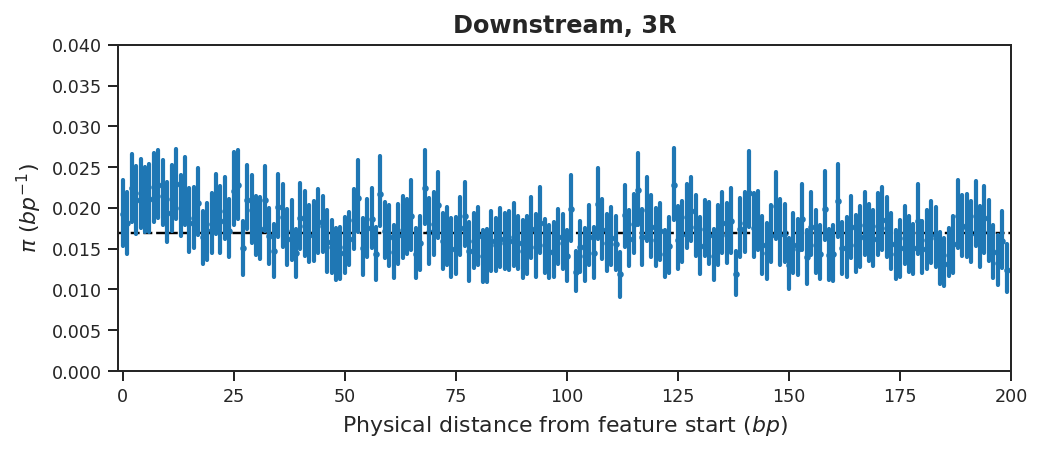

In [37]:
plot_all_feature_diversity('3R', min_flen=200)

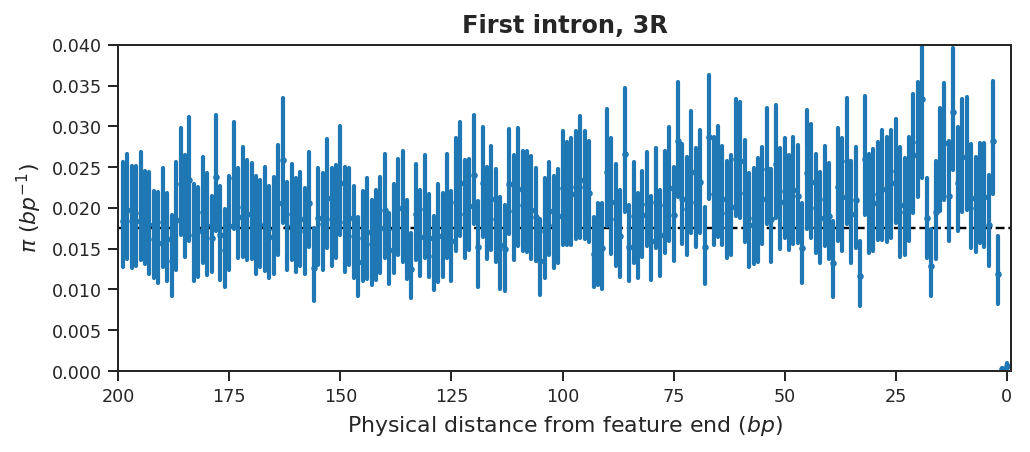

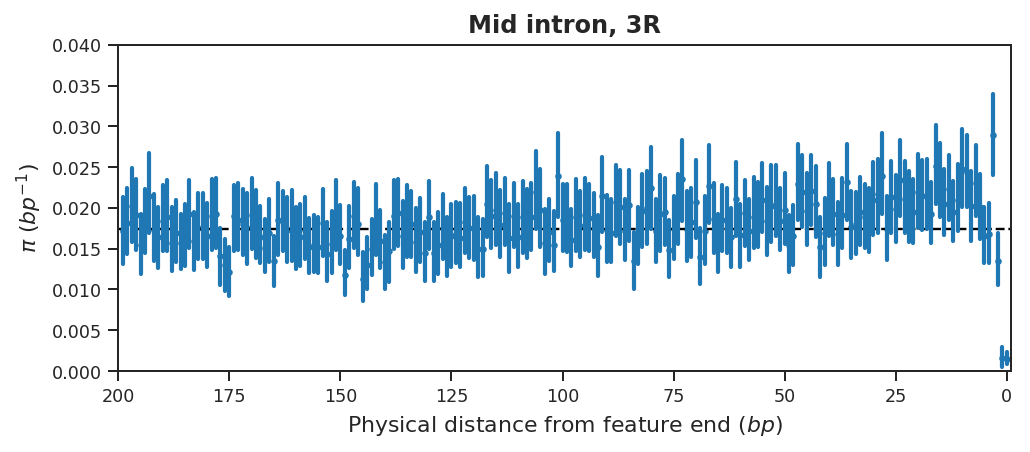

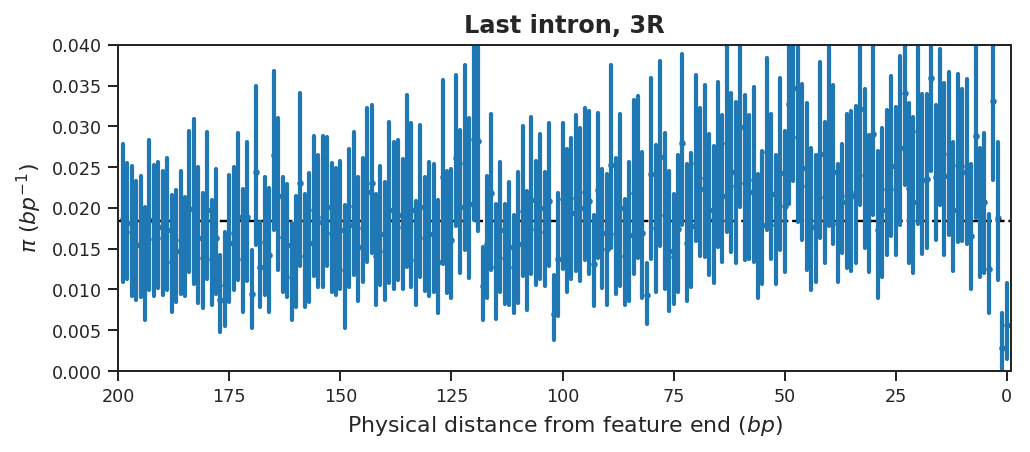

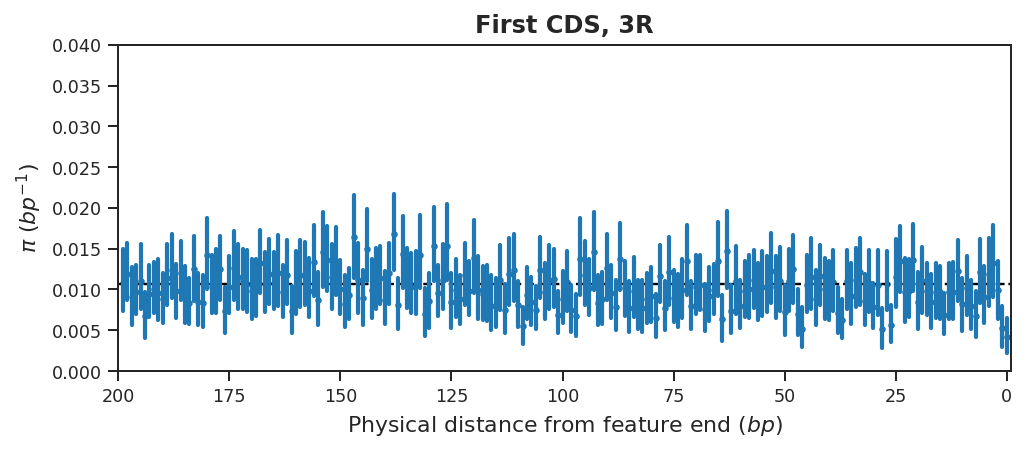

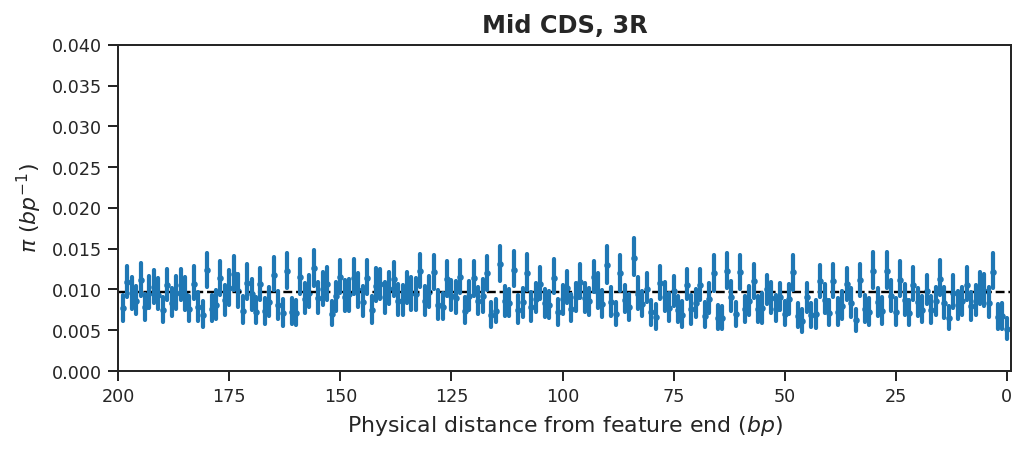

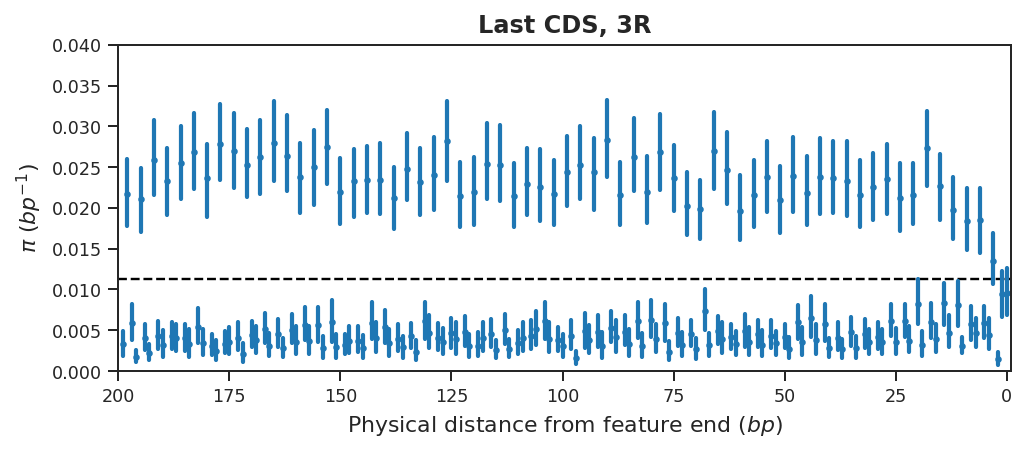

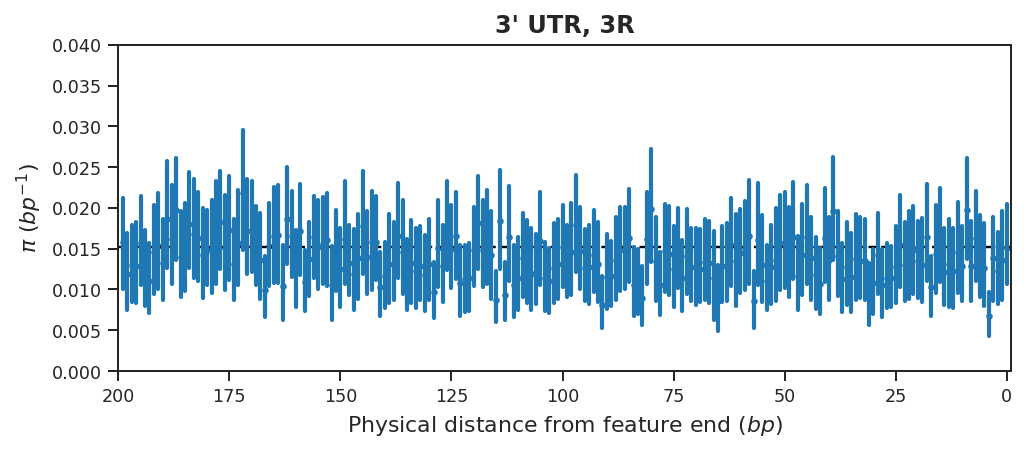

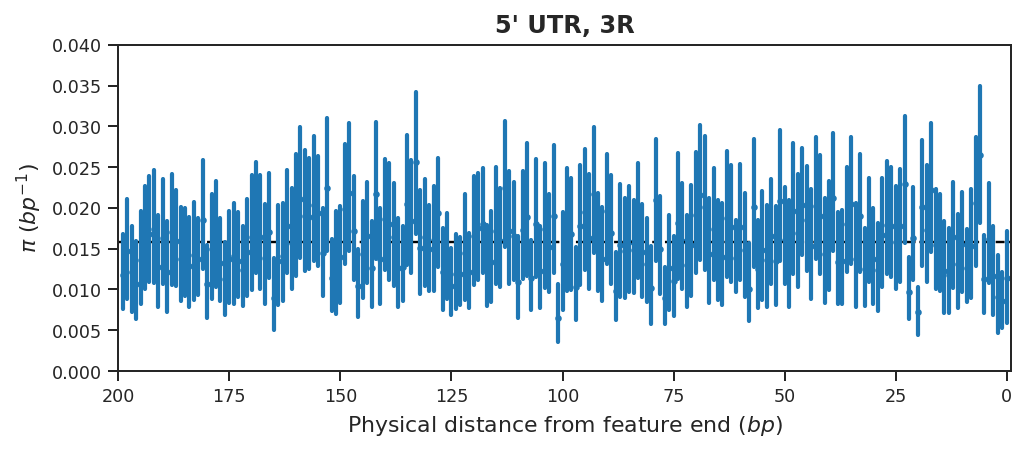

In [38]:
plot_all_feature_diversity_end('3R', min_flen=200)

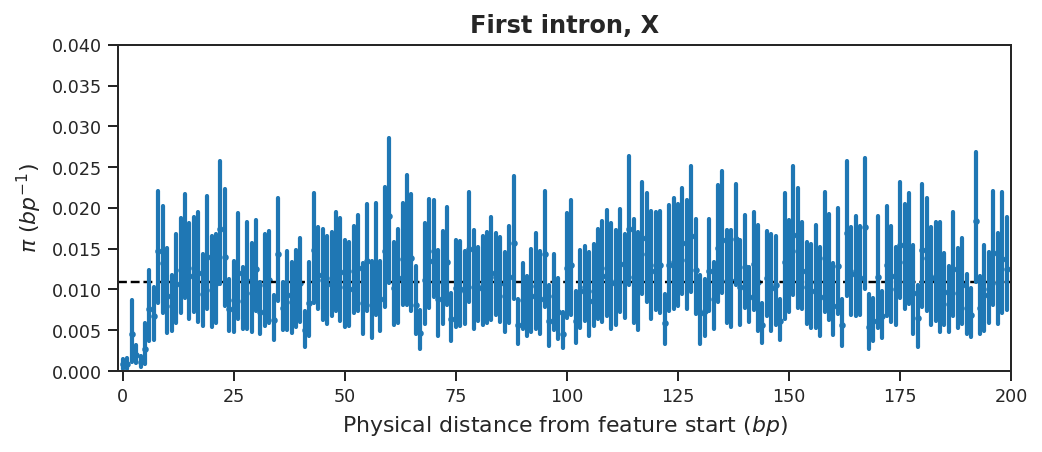

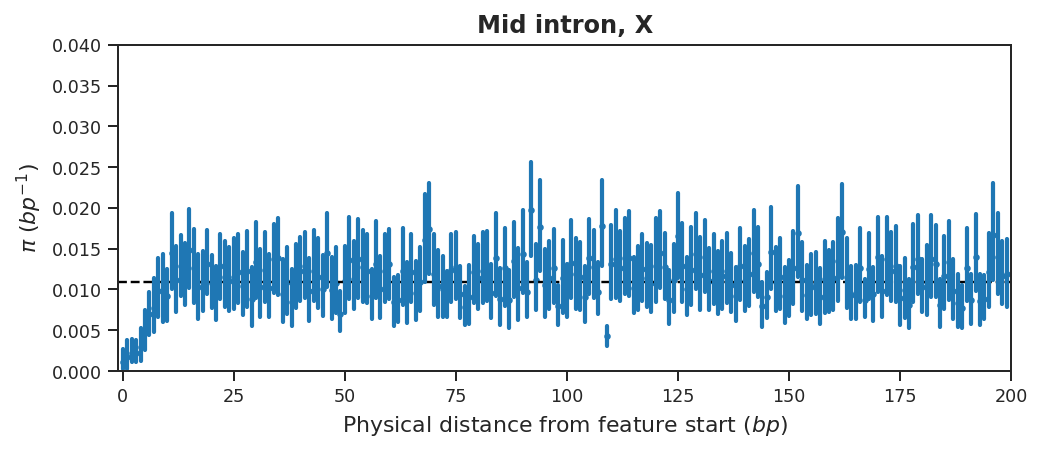

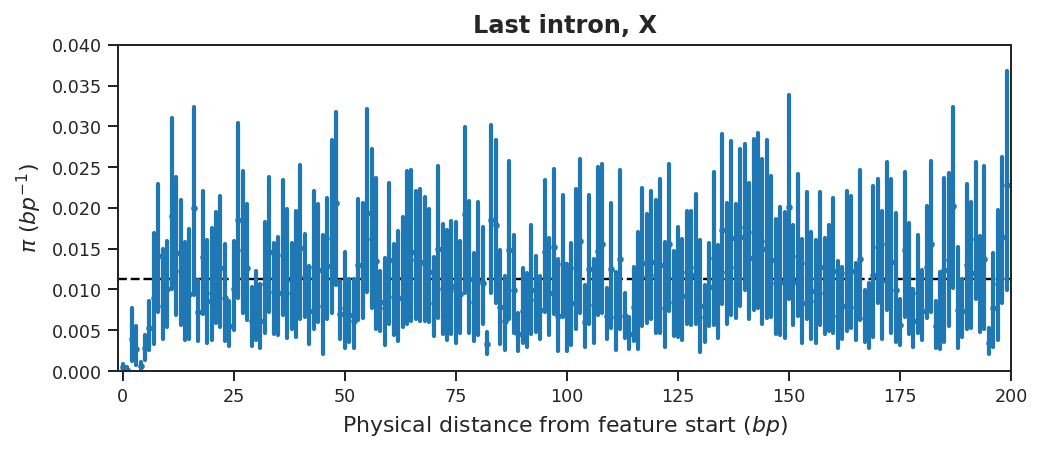

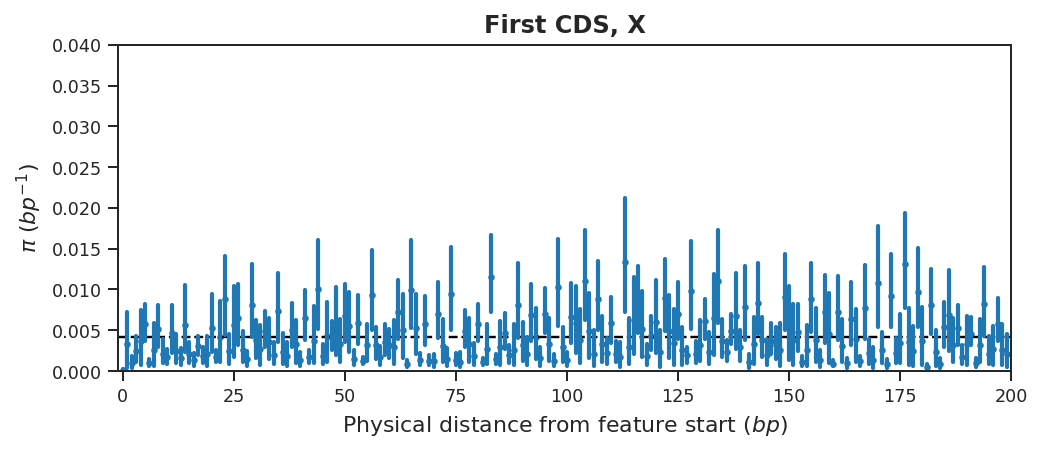

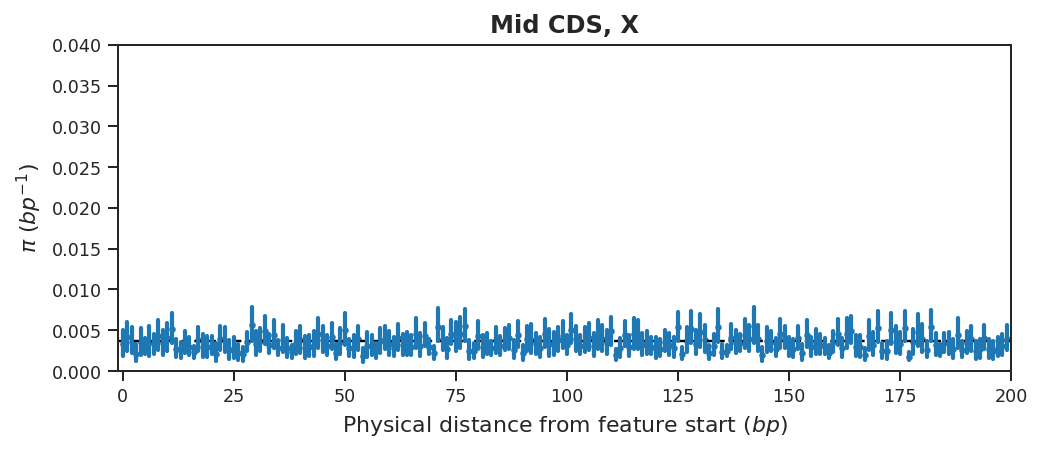

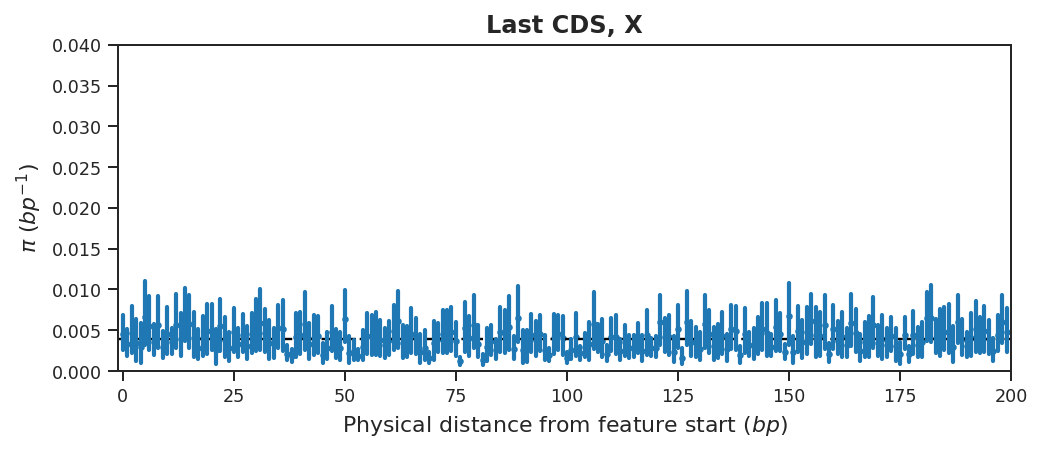

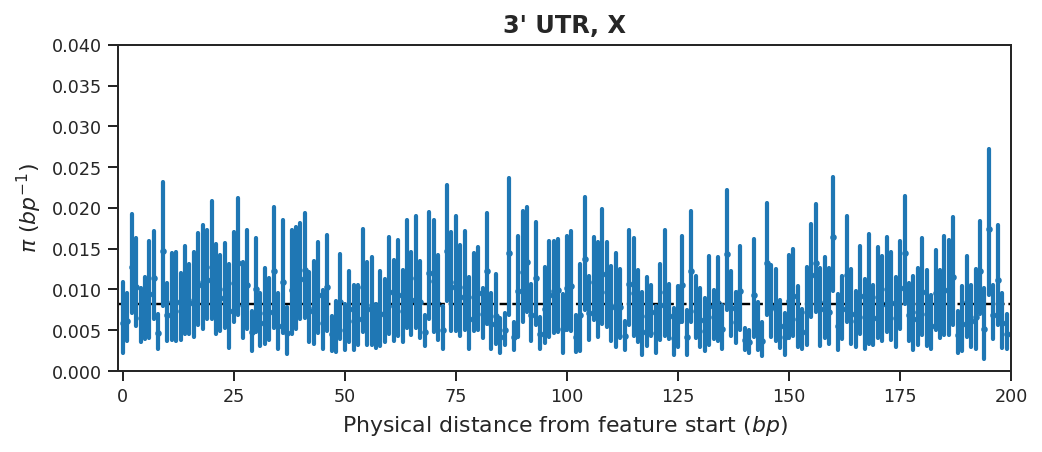

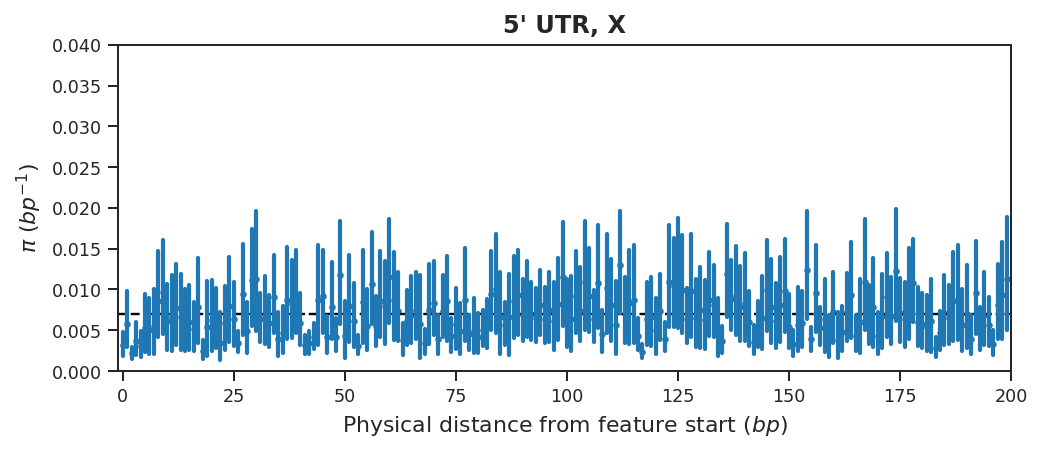

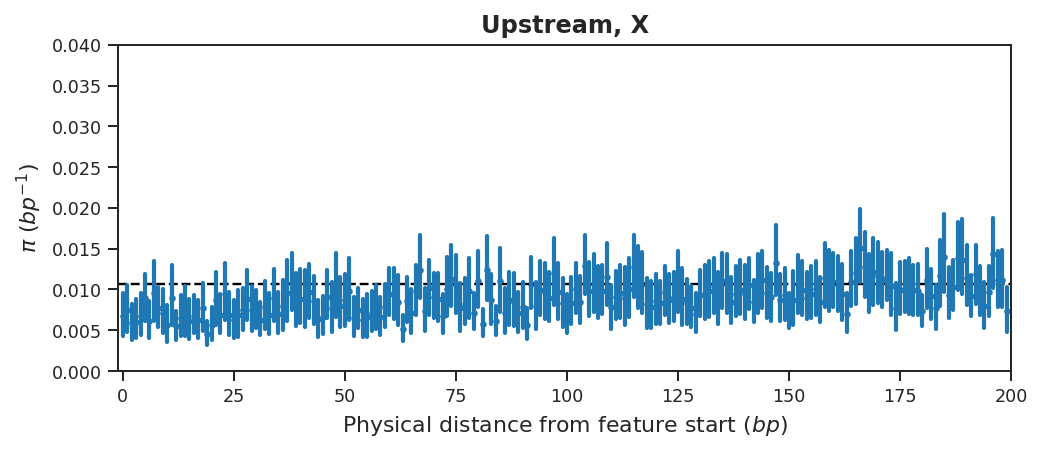

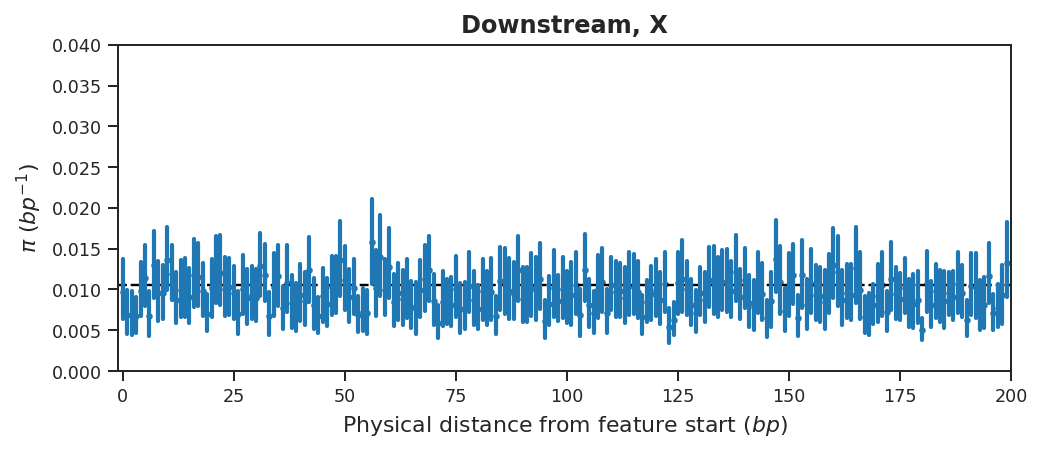

In [39]:
plot_all_feature_diversity('X', min_flen=200)

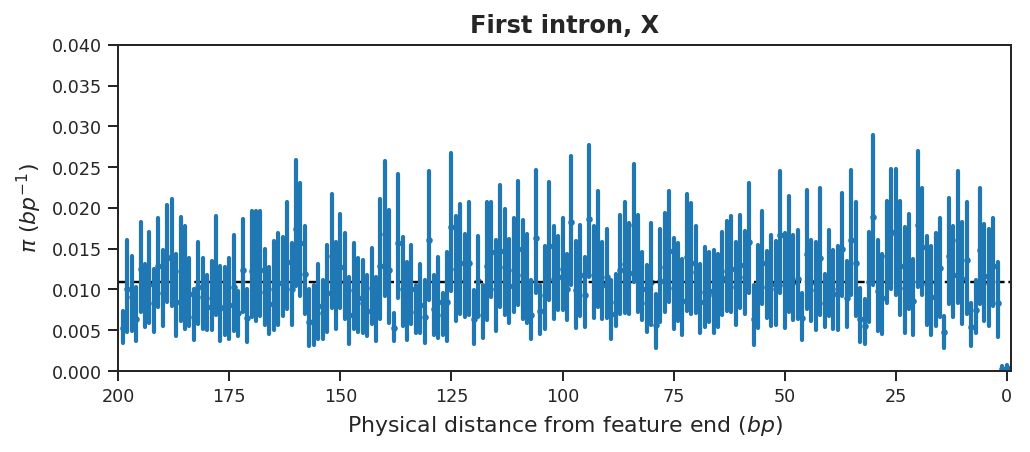

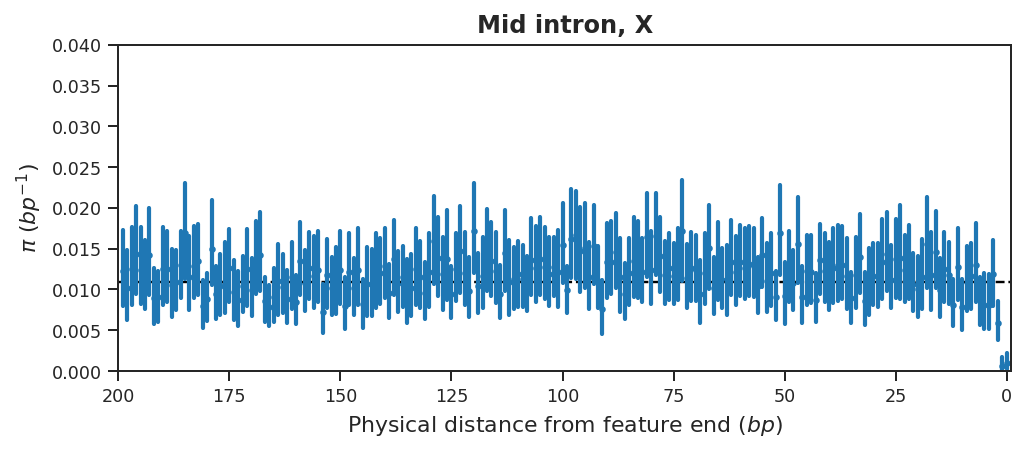

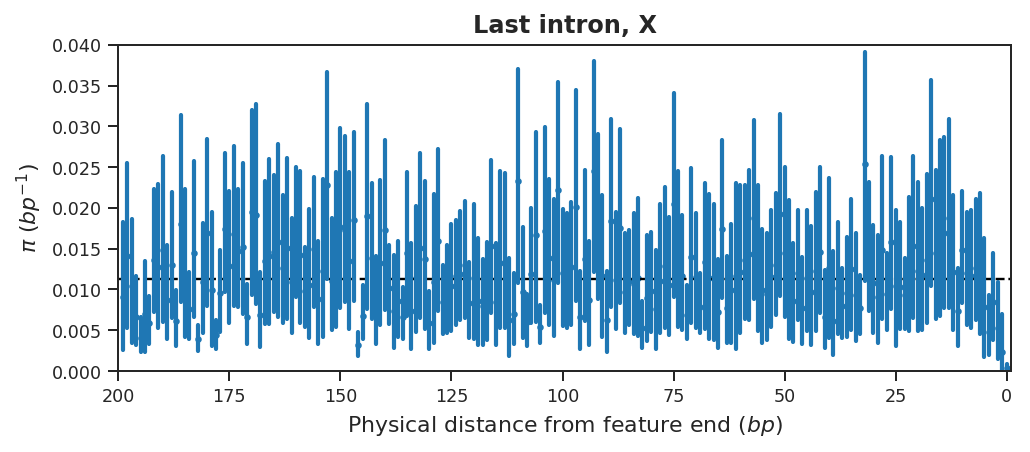

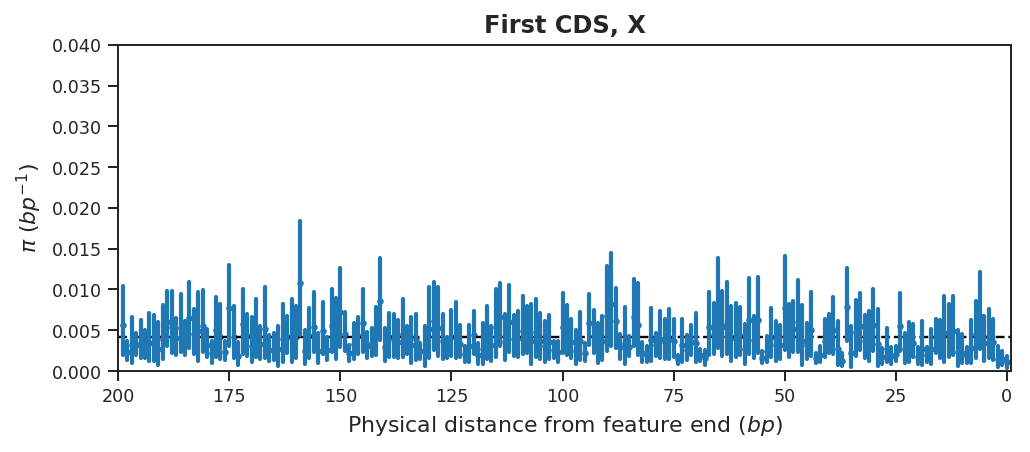

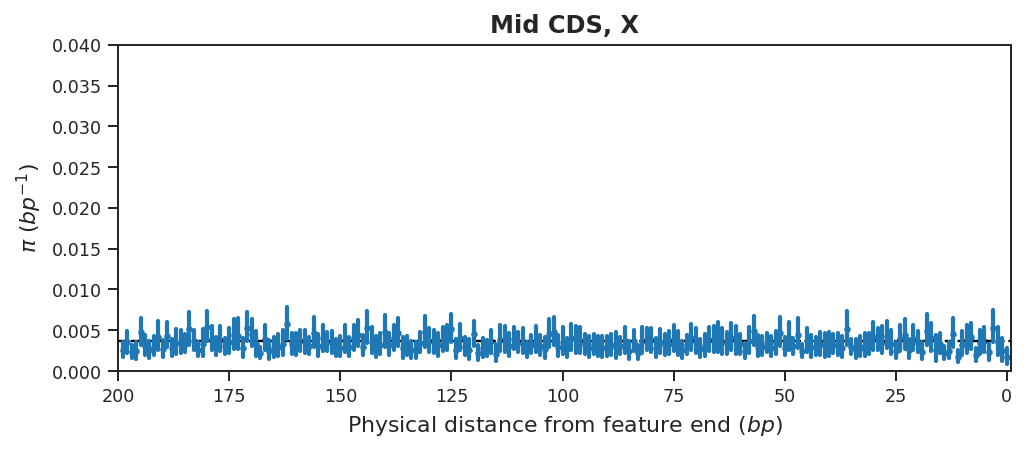

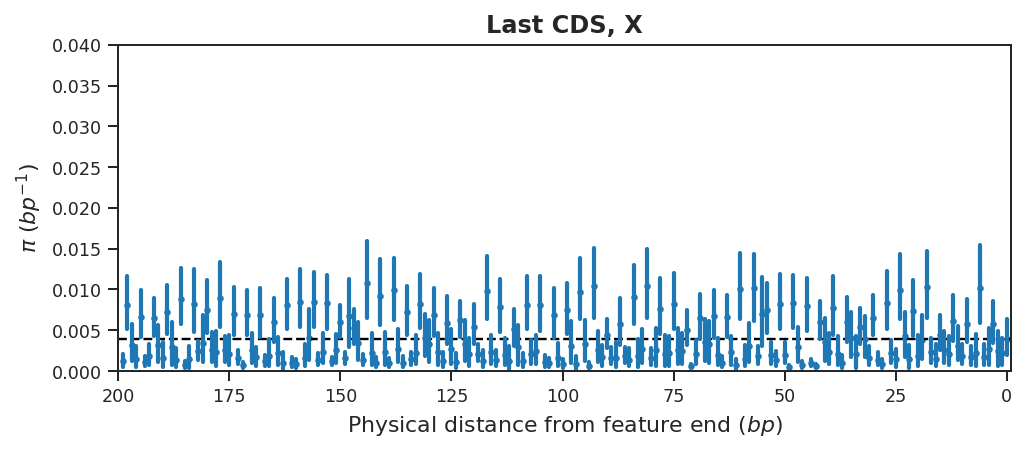

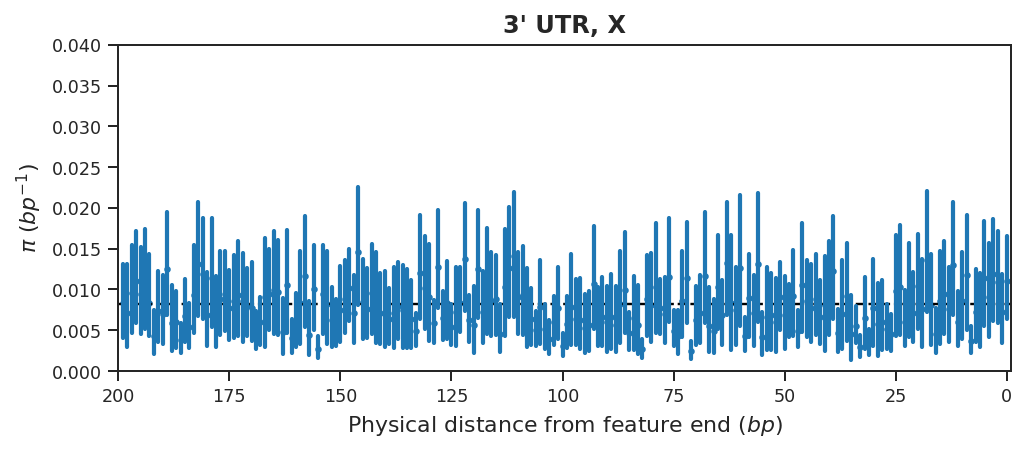

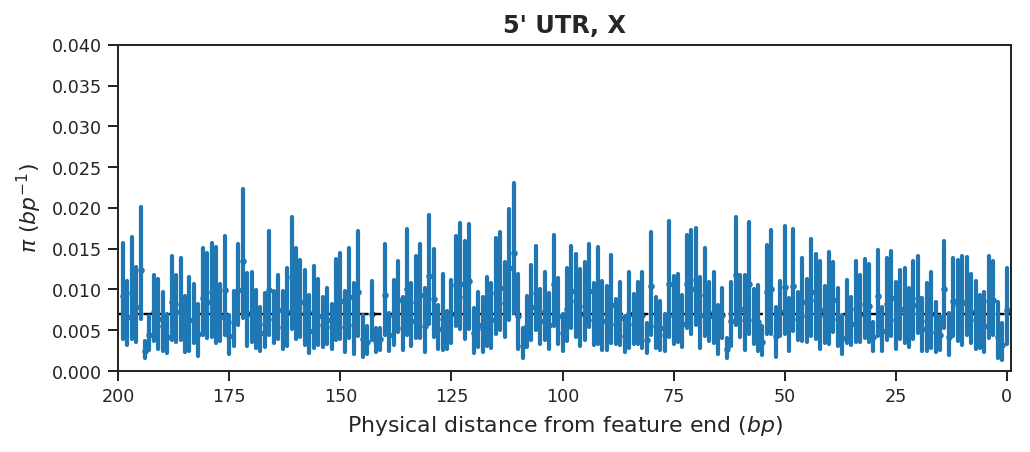

In [40]:
plot_all_feature_diversity_end('X', min_flen=200)

## Sandbox